#**PROBLEMA DE NEGOCIO**


---

Una empresa de telecomunicaciones desea mejorar la retención de sus clientes, identificando aquellos que tienen más chances de abandonar el servicio (Churn). Como científico de datos, tu objetivo será limpiar y preparar un conjunto de datos para el entrenamiento de un modelo de Churn. A continuación, se presentan las preguntas clave que guiarán el proceso de limpieza de datos:

### **Preguntas**

1. ¿Qué insights podemos obtener del análisis exploratorio inicial del conjunto de datos?

2. ¿Qué transformaciones básicas son necesarias para preparar los datos?

3. ¿Cómo podemos identificar y tratar los datos duplicados y los valores nulos?

4. ¿Cómo manejamos los outliers presentes en el dataset?

5. ¿Qué técnicas aplicamos para procesar las variables categóricas?

#**1. Configuración del Ambiente**


---

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import requests
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import io
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
global datos_churn

#**2. Obtención y Tratamiento de Datos**


---

##**2.1 Cargando las bases de datos**

In [3]:
## Leyendo la base de datos del repositorio GITHUB
url = 'https://github.com/davidcarrillo10288/Telecom_Churn/raw/master/base_clientes.json'

## Haciendo request para obtener el archivo del URL
response = requests.get(url)

# Cargamos el contenido json en una variable
data = json.loads(response.text)

In [4]:
## Dataframe sin normalizar
datos_churn_before = pd.DataFrame(data)
# datos_churn = pd.read_json("base_clientes.json")
datos_churn_before.head()

id_cliente Churn                                            cliente  \
0  0002-ORFBO    no  {'genero': 'femenino', 'anciano': 0, 'pareja':...   
1  0003-MKNFE    no  {'genero': 'masculino', 'anciano': 0, 'pareja'...   
2  0004-TLHLJ    si  {'genero': 'masculino', 'anciano': 0, 'pareja'...   
3  0011-IGKFF    si  {'genero': 'masculino', 'anciano': 1, 'pareja'...   
4  0013-EXCHZ    si  {'genero': 'femenino', 'anciano': 1, 'pareja':...   

                                            telefono  \
0  {'servicio_telefono': 'si', 'varias_lineas': '...   
1  {'servicio_telefono': 'si', 'varias_lineas': '...   
2  {'servicio_telefono': 'si', 'varias_lineas': '...   
3  {'servicio_telefono': 'si', 'varias_lineas': '...   
4  {'servicio_telefono': 'si', 'varias_lineas': '...   

                                            internet  \
0  {'servicio_internet': 'DSL', 'seguridad_online...   
1  {'servicio_internet': 'DSL', 'seguridad_online...   
2  {'servicio_internet': 'fibra optica', 'segurid...   
3  {'servicio_internet': 'fibra optica', 'segurid...   
4  {'servicio_internet': 'fibra optica', 'segurid...   

                                              cuenta  
0  {'contrato': None, 'facturacion_electronica': ...  
1  {'contrato': 'mensual', 'facturacion_electroni...  
2  {'contrato': 'mensual', 'facturacion_electroni...  
3  {'contrato': 'mensual', 'facturacion_electroni...  
4  {'contrato': 'mensual', 'facturacion_electroni...

In [5]:
## Aplicamos el json_normalize para aplanar el json
## Convierte datos aninados en forma tabular
datos_churn = pd.json_normalize(data)
datos_churn.head()

id_cliente Churn cliente.genero  cliente.anciano cliente.pareja  \
0  0002-ORFBO    no       femenino                0             si   
1  0003-MKNFE    no      masculino                0             no   
2  0004-TLHLJ    si      masculino                0             no   
3  0011-IGKFF    si      masculino                1             si   
4  0013-EXCHZ    si       femenino                1             si   

  cliente.dependientes  cliente.tiempo_servicio telefono.servicio_telefono  \
0                   si                      9.0                         si   
1                   no                      9.0                         si   
2                   no                      4.0                         si   
3                   no                     13.0                         si   
4                   no                      3.0                         si   

  telefono.varias_lineas internet.servicio_internet internet.seguridad_online  \
0                     no                        DSL                        no   
1                     si                        DSL                        no   
2                     no               fibra optica                        no   
3                     no               fibra optica                        no   
4                     no               fibra optica                        no   

  internet.backup_online internet.proteccion_dispositivo  \
0                     si                              no   
1                     no                              no   
2                     no                              si   
3                     si                              si   
4                     no                              no   

  internet.soporte_tecnico internet.tv_streaming internet.peliculas_streaming  \
0                       si                    si                           no   
1                       no                    no                           si   
2                       no                    no                           no   
3                       no                    si                           si   
4                       si                    si                           no   

  cuenta.contrato cuenta.facturacion_electronica  cuenta.metodo_pago  \
0            None                           None                None   
1         mensual                             no              cheque   
2         mensual                             si  cheque electronico   
3         mensual                             si  cheque electronico   
4         mensual                             si              cheque   

   cuenta.cobros.mensual cuenta.cobros.Total  
0                    NaN                None  
1                   59.9               542.4  
2                   73.9              280.85  
3                   98.0             1237.85  
4                   83.9               267.4

### **2.1.1 Información general de la base de datos**

In [6]:
## Visión general del dataframe
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       7344 non-null   object 
 1   Churn                            7344 non-null   object 
 2   cliente.genero                   7344 non-null   object 
 3   cliente.anciano                  7344 non-null   int64  
 4   cliente.pareja                   7344 non-null   object 
 5   cliente.dependientes             7344 non-null   object 
 6   cliente.tiempo_servicio          7336 non-null   float64
 7   telefono.servicio_telefono       7344 non-null   object 
 8   telefono.varias_lineas           7344 non-null   object 
 9   internet.servicio_internet       7344 non-null   object 
 10  internet.seguridad_online        7344 non-null   object 
 11  internet.backup_online           7344 non-null   object 
 12  internet.proteccion_

**<ins>OBSERVACIÓN:</ins>**
* Tenemos 21 columnas y 7344 filas en nuestro dataframe.
* Tenemos 3 tipos de datos: **Object, int64 y float64**. Se verificará posteriormente la correspondencia real de estos tipos de datos para sus respectivas variables.
* Observamos que tenemos **6 columnas** que tienen presencia de datos nulos: **cliente.tiempo_servicio, cuenta.contrato, cuenta.facturacion_electronica, cuenta.metodo_pago, cuenta.cobros.mensual y cuenta.cobros.Total**. Se realizará el tratamiento de estos valores nulos, ya sea imputandolos o eliminandolos de ser necesario.

##**2.2 Tratamiento de datos**

**VARIABLE OBJETIVO**

In [7]:
datos_churn['Churn'].unique()

array(['no', 'si', ''], dtype=object)

In [8]:
datos_churn['Churn'].isnull().sum()

0

* Observamos que tenemos un valor adicional ' ', el cual no corresponde a nuestra variable objetivo, por esta razón trataremos de convertirlo a NaN, ya que en el .info(), figura como si no existieran valores nulos.

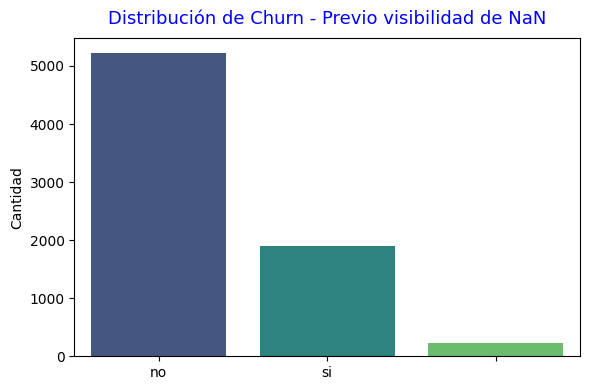

In [9]:
## Gráfica previo a poner visibles los valores NaN
plt.figure(figsize=(6, 4))
sns.countplot(data=datos_churn, x='Churn', palette='viridis')
plt.title('Distribución de Churn - Previo visibilidad de NaN', pad=10, fontdict={'fontsize': 13, 'color':'blue', 'fontweight': 'normal'})
plt.xlabel('')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

In [10]:
datos_churn['Churn'] = datos_churn['Churn'].replace(['None', None, 'null', 'NA', ''], np.nan)
datos_churn['Churn'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7344 entries, 0 to 7343
Series name: Churn
Non-Null Count  Dtype 
--------------  ----- 
7118 non-null   object
dtypes: object(1)
memory usage: 57.5+ KB


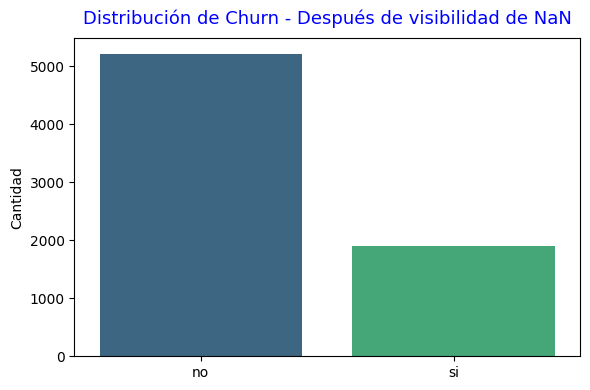

In [11]:
## Gráfica previo a poner visibles los valores NaN
plt.figure(figsize=(6, 4))
sns.countplot(data=datos_churn, x='Churn', palette='viridis')
plt.title('Distribución de Churn - Después de visibilidad de NaN', pad=10, fontdict={'fontsize': 13, 'color':'blue', 'fontweight': 'normal'})
plt.xlabel('')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

In [12]:
datos_churn['Churn'].value_counts()

Churn
no    5223
si    1895
Name: count, dtype: int64

In [13]:
datos_churn['Churn'].isnull().sum()

226

* Tenemos en totalidad 226 valores nulos en el dataframe con respecto a la variable CHURN.
* Después de analizar las demás variables, llegamos a la conclusión que esta variable al ser la variable objetivo, no podemos imputarla de manera aleatoria. Si bien es cierto se podría colocar como la moda, pero esto solo haría aumentar la cantidad de valores NO. Lo que requerimos en nuestro modelo posterior es determinar el valor SI, ya que implica que serían los que abandanarían la compañía.
* Por esta razón, decidimos eliminar estos valores nulos, dado que tenemos un dataset todavia amplio y 226 filas representan solo el 3% de todo el dataset.

In [14]:
# Eliminar las filas que tengan valores nulos en la columna 'Churn'
datos_churn = datos_churn.dropna(subset=['Churn'])

# Restablecer el índice para que sea consecutivo
datos_churn.reset_index(drop=True, inplace=True)

datos_churn['Churn'].isnull().sum()

0

In [15]:
datos_churn['Churn'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7118 entries, 0 to 7117
Series name: Churn
Non-Null Count  Dtype 
--------------  ----- 
7118 non-null   object
dtypes: object(1)
memory usage: 55.7+ KB


* Conseguimos eliminar los valores nulos satisfactoriamente de nuestra variable objetivo.

### **2.2.1 Analizando valores duplicados**

In [16]:
## Validando la cantidad de datos del dataframe con un shape
datos_churn.shape

(7118, 21)

In [17]:
## Verificando cantidad de datos duplicados
datos_churn.duplicated().sum()

75

* Notamos que tenemos 75 valores duplicados en nuestro dataframe. Realizaremos un drop_duplicates a fin de eliminar estos valores.

In [18]:
## Realizamos eliminación de valores duplicados en nuestro dataframe
datos_churn = datos_churn.drop_duplicates()
datos_churn.reset_index(drop=True, inplace=True)
datos_churn.shape

(7043, 21)

* Observamos que se eliminaron correctamente los valores duplicados y reseteamos el índice para evitar complicaciones posteriores.

### **2.2.2 Analizando valores Nulos**

In [19]:
## Visualizando la cantidad de nulos existentes en el dataframe con su correspondiente categoría
columns_with_null = datos_churn.columns[datos_churn.isnull().any() == True]
datos_churn[columns_with_null].isnull().sum().sort_values(ascending=False).rename('Cantidad de nulos')

cuenta.contrato                   31
cuenta.metodo_pago                26
cuenta.cobros.mensual             17
cuenta.facturacion_electronica    17
cuenta.cobros.Total               15
cliente.tiempo_servicio            8
Name: Cantidad de nulos, dtype: int64

In [20]:
columns_with_null

Index(['cliente.tiempo_servicio', 'cuenta.contrato',
       'cuenta.facturacion_electronica', 'cuenta.metodo_pago',
       'cuenta.cobros.mensual', 'cuenta.cobros.Total'],
      dtype='object')

In [21]:
## Verificando los tipos de datos para las variables a analizar
datos_churn[columns_with_null].dtypes.rename('Tipos de datos')

cliente.tiempo_servicio           float64
cuenta.contrato                    object
cuenta.facturacion_electronica     object
cuenta.metodo_pago                 object
cuenta.cobros.mensual             float64
cuenta.cobros.Total                object
Name: Tipos de datos, dtype: object

In [22]:
## Verificando la correspondencia del tipo de dato con su variable respectiva
for i in columns_with_null:
  print('*****'*5)
  print(f'<<<-----{i}----->>>')
  print(datos_churn[i].unique())
  print('*****'*5)
  print('')

*************************
<<<-----cliente.tiempo_servicio----->>>
[9.00e+00 4.00e+00 1.30e+01 3.00e+00 7.10e+01 6.30e+01 7.00e+00      nan
 5.40e+01 7.20e+01 5.00e+00 5.60e+01 3.40e+01 1.00e+00 4.50e+01 5.00e+01
 2.30e+01 5.50e+01 2.60e+01 6.90e+01 3.70e+01 4.90e+01 6.60e+01 6.70e+01
 2.00e+01 4.30e+01 5.90e+01 1.20e+01 2.70e+01 2.00e+00 2.50e+01 2.90e+01
 1.40e+01 3.50e+01 6.40e+01 3.90e+01 4.00e+01 1.10e+01 6.00e+00 3.00e+01
 7.00e+01 5.70e+01 5.80e+01 1.60e+01 3.20e+01 3.30e+01 1.00e+01 2.10e+01
 6.10e+01 1.50e+01 4.40e+01 2.20e+01 2.40e+01 1.90e+01 4.70e+01 6.20e+01
 4.60e+01 5.20e+01 8.00e+00 6.00e+01 4.80e+01 2.80e+01 4.10e+01 5.30e+01
 6.80e+01 3.10e+01 3.60e+01 1.70e+01 1.80e+01 6.50e+01 5.10e+01 3.80e+01
 4.20e+01 0.00e+00 1.08e+03 1.00e+03 9.50e+02 2.54e+02 3.21e+02 6.50e+02
 7.21e+02 5.55e+02 4.33e+02 5.12e+02]
*************************

*************************
<<<-----cuenta.contrato----->>>
[None 'mensual' 'dos años' 'un año']
*************************

*****************

* Observamos que de todas estas variables, la única que no corresponde el tipo de datos es la variable **cuenta.cobros.Total**, en la cual se tendrá que corregir el tipo de dato de **object** a **float64**

In [23]:
# Convertir las columnas 'cuenta.cobros.Total' y 'cuenta.cobros.mensual' a numérico
datos_churn['cuenta.cobros.Total'] = pd.to_numeric(datos_churn['cuenta.cobros.Total'], errors='coerce')

In [24]:
## Observando los tipos de datos de mis columnas con nulos
datos_churn[columns_with_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente.tiempo_servicio         7035 non-null   float64
 1   cuenta.contrato                 7012 non-null   object 
 2   cuenta.facturacion_electronica  7026 non-null   object 
 3   cuenta.metodo_pago              7017 non-null   object 
 4   cuenta.cobros.mensual           7026 non-null   float64
 5   cuenta.cobros.Total             7017 non-null   float64
dtypes: float64(3), object(3)
memory usage: 330.3+ KB


**<INS>GRÁFICA DE MATRIX DE NULOS</INS>**

<Axes: >

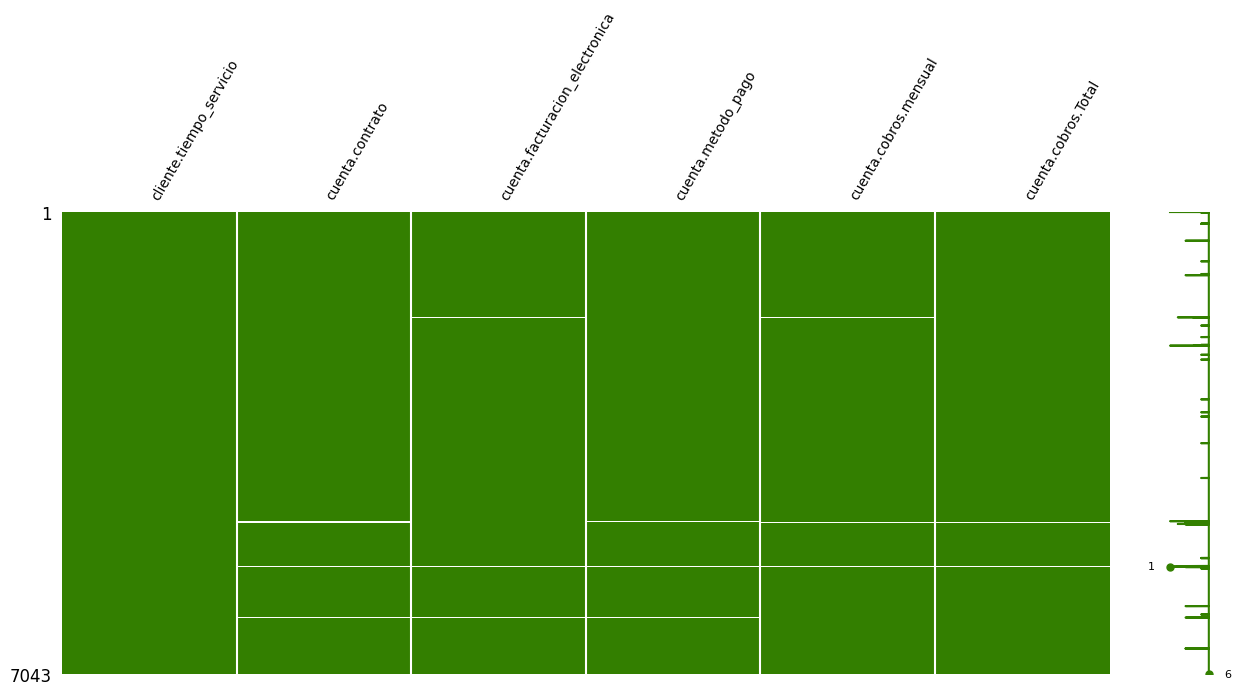

In [25]:
## Representando en gráfico nuestros valores nulos del dataframe
msno.matrix(datos_churn[columns_with_null], figsize=(15, 6), fontsize=10, color=(0.2, 0.5, 0), label_rotation=60)

In [26]:
# msno.bar(datos_churn[columns_with_null], figsize=(15, 10), fontsize=10, color=(0.2, 0.2, 0.4), label_rotation=60)

**<INS>GRÁFICA DE HEATMAP DE NULOS - CORRELACIÓN DE NULOS ENTRE VARIABLES</INS>**

<Axes: >

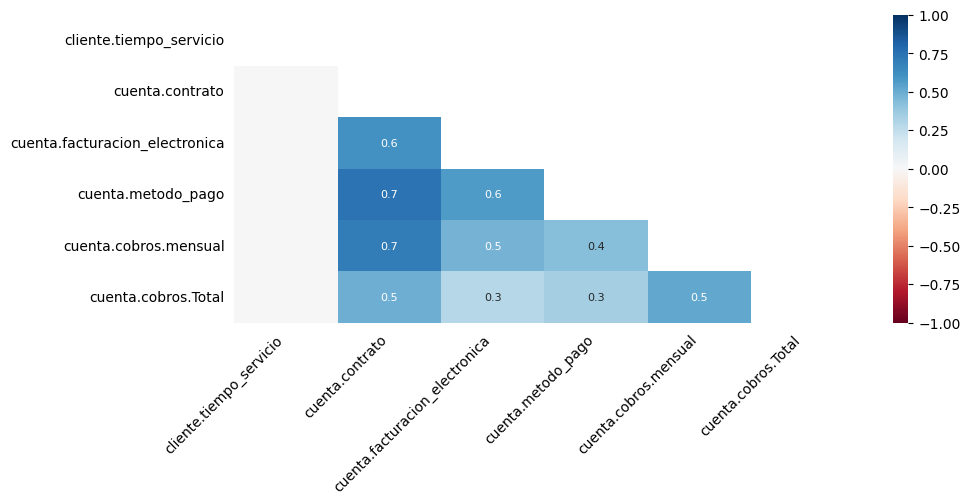

In [27]:
msno.heatmap(datos_churn, figsize=(10, 4), fontsize=10)

* Tanto en nuestra Matriz de Nulos como en nuestro Heatmap de correlación de valores nulos, observamos que casi todas las variables se relacionan entre nulos, es decir que en las mismas filas tenemos valores nulos para esas variables.
* Asimismo, observamos que la única variable que no tiene relación de nulos con las demás varaibles es **cliente.tiempo_servicio**, se empezará a analizar por esta variable a fin de ver si se puede imputar de alguna manera.

**<INS>GRÁFICA DE CORRELACIÓN DE NULOS ENTRE VARIABLES Y CANTIDAD DE NULOS POR VARIABLE</INS>**

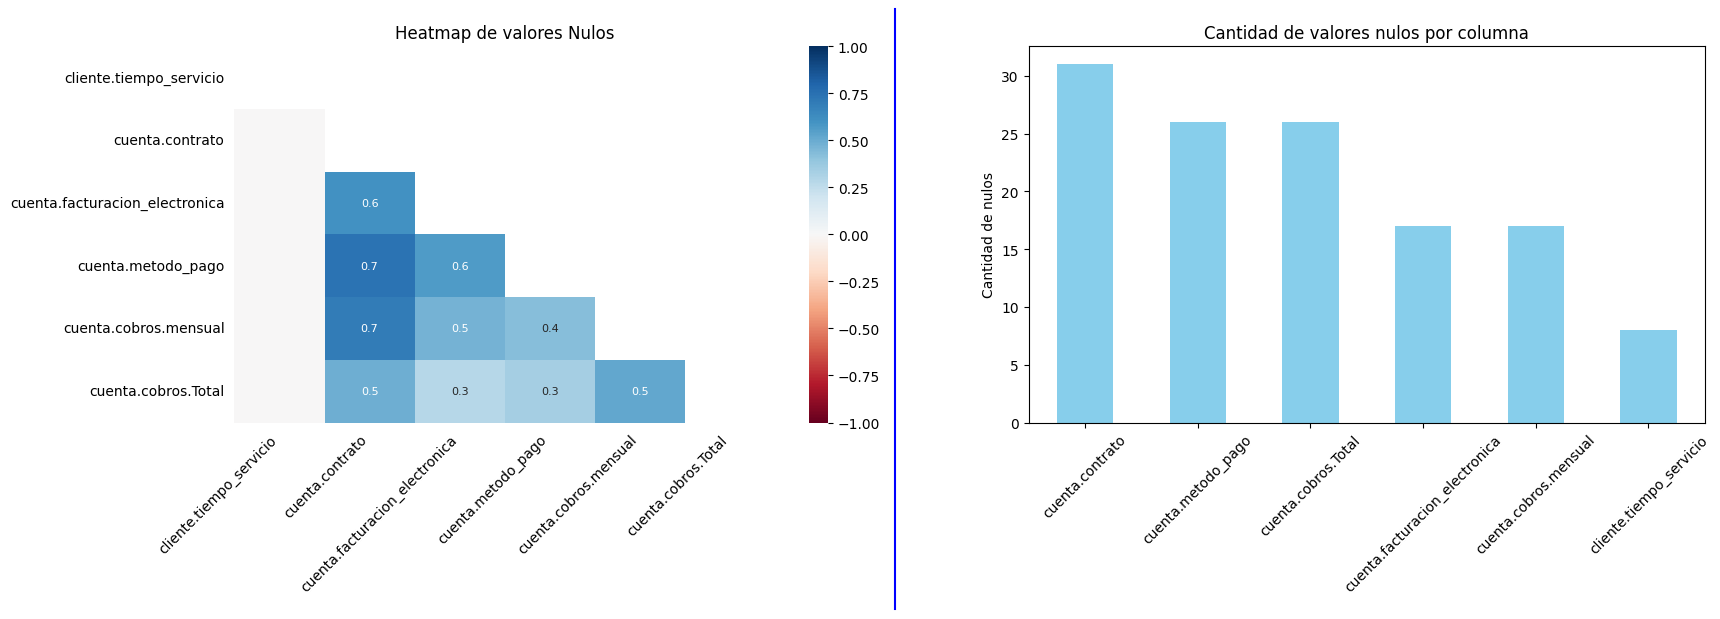

In [28]:
# Identificamos las columnas con valores nulos y calculamos la cantidad de nulos
columns_with_null = datos_churn.columns[datos_churn.isnull().any() == True]
null_counts = datos_churn[columns_with_null].isnull().sum().sort_values(ascending=False).rename('Cantidad de nulos')

# Creamos una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Graficamos el Heatmap de missingno en el primer subplot
ax1.set_title('Heatmap de valores Nulos')
msno.heatmap(datos_churn, ax=ax1, figsize=(10, 4), fontsize=10)

# Graficamos el Barplot para la cantidad de nulos por columna en el segundo subplot
null_counts.plot(kind='bar', ax=ax2, color='Skyblue', rot= 45)
ax2.set_title('Cantidad de valores nulos por columna')
ax2.set_ylabel('Cantidad de nulos')
ax2.set_xlabel('')

# Dibujar una línea de separación entre los gráficos
fig.subplots_adjust(wspace=100)  # Ajusta el espacio entre los subplots
fig.add_artist(plt.Line2D([0.5, 0.5], [0, 1], color='blue', linestyle='-'))  # Línea de separación

# Ajustamos el espaciado entre los subplots
plt.tight_layout()
plt.show()

* Podemos observar que tenemos 6 columnas con valores nulos, las cuales son: **'cliente.tiempo_servicio', 'cuenta.contrato',
'cuenta.facturacion_electronica', 'cuenta.metodo_pago',
'cuenta.cobros.mensual', 'cuenta.cobros.Total'**
* Notamos en el Heatmap, que muchas variables con nulos, están relacionadas entre sí, verificaremos si esta relación es a considerar.
* La variable **'cliente.tiempo_servicio'**, es la única que no tienen relación de nulos con las demás variables, esto quiere decir que en sus filas de nulos, no existen nulos para las otras variables.
* Notamos que **'cliente.tiempo_servicio'** es la variable que tiene menos cantidad de valores nulos en su composición.
* La variable **'cuenta.contrato'** es la variable que tiene mayor cantidad de nulos.

### **2.2.2.1 cliente.tiempo_servicio**

In [29]:
## Analizando los nulos en la variable 'cliente.tiempo_servicio'
datos_churn[datos_churn['cliente.tiempo_servicio'].isnull()][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
9                         NaN        dos años                             si   
176                       NaN         mensual                             si   
181                       NaN         mensual                             si   
751                       NaN        dos años                             si   
3523                      NaN        dos años                             no   
5273                      NaN          un año                             no   
5276                      NaN          un año                             si   
6134                      NaN          un año                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
9                                  cheque                  90.45   
176                                cheque                  29.30   
181       tarjeta de credito (automatico)                  63.95   
751   transferencia bancaria (automatica)                 101.05   
3523  transferencia bancaria (automatica)                  76.10   
5273                               cheque                  20.60   
5276  transferencia bancaria (automatica)                  73.85   
6134  transferencia bancaria (automatica)                  69.05   

      cuenta.cobros.Total  
9                 5957.90  
176                355.90  
181                318.10  
751               5971.25  
3523              1054.80  
5273               116.60  
5276              3581.40  
6134              1958.45

* Notamos que si bien tiene valores nulos, estos se pueden imputar aplicando una fórmula, ya que podemos observar que:

  > **$cliente.tiempo\_servicio \times cuenta.cobros.mensual = cuenta.cobros.Total$**

In [30]:
## Consiguiendo los índices de las filas de valores nulos para esta variable
idx = datos_churn[datos_churn['cliente.tiempo_servicio'].isnull()][columns_with_null].index
idx

Index([9, 176, 181, 751, 3523, 5273, 5276, 6134], dtype='int64')

In [31]:
## Aplicando la fórmula planteada e imputando los valores nulos de esta columna
# datos_churn.iloc[idx]['cliente.tiempo_servicio'] = datos_churn.iloc[idx]['cuenta.cobros.Total'] // datos_churn.iloc[idx]['cuenta.cobros.mensual']
datos_churn['cliente.tiempo_servicio'].fillna(datos_churn['cuenta.cobros.Total'] // datos_churn['cuenta.cobros.mensual'], inplace=True)
datos_churn['cliente.tiempo_servicio'].isnull().sum()

0

In [32]:
datos_churn.iloc[idx][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
9                        65.0        dos años                             si   
176                      12.0         mensual                             si   
181                       4.0         mensual                             si   
751                      59.0        dos años                             si   
3523                     13.0        dos años                             no   
5273                      5.0          un año                             no   
5276                     48.0          un año                             si   
6134                     28.0          un año                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
9                                  cheque                  90.45   
176                                cheque                  29.30   
181       tarjeta de credito (automatico)                  63.95   
751   transferencia bancaria (automatica)                 101.05   
3523  transferencia bancaria (automatica)                  76.10   
5273                               cheque                  20.60   
5276  transferencia bancaria (automatica)                  73.85   
6134  transferencia bancaria (automatica)                  69.05   

      cuenta.cobros.Total  
9                 5957.90  
176                355.90  
181                318.10  
751               5971.25  
3523              1054.80  
5273               116.60  
5276              3581.40  
6134              1958.45

* Notamos que la imputación se desarrolló de manera satisfactoria.

In [33]:
datos_churn[columns_with_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente.tiempo_servicio         7043 non-null   float64
 1   cuenta.contrato                 7012 non-null   object 
 2   cuenta.facturacion_electronica  7026 non-null   object 
 3   cuenta.metodo_pago              7017 non-null   object 
 4   cuenta.cobros.mensual           7026 non-null   float64
 5   cuenta.cobros.Total             7017 non-null   float64
dtypes: float64(3), object(3)
memory usage: 330.3+ KB


* La variable **cliente.tiempo_servicio** ya no presenta valores nulos.

### **2.2.2.2 cuenta.cobros.mensual y cuenta.cobros.Total**

* Ahora analizaremos las columnas **cuenta.cobros.mensual y cuenta.cobros.mensual**, ya que tienen relación de 0.7 en el **Heatmap**, lo cual es elevado. Validaremos si se puede imputar o eliminar. Haremos correspondendia con la fórmula planteada y si no se pudiera conseguir algún valor se vería la posibilidad de eliminar la fila.

In [34]:
## Verificando los valores nulos en 'cuenta.cobros.Total'
datos_churn[datos_churn['cuenta.cobros.Total'].isnull()][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
0                         9.0            None                           None   
945                       0.0        dos años                             no   
1604                     18.0            None                             no   
1605                     23.0            None                             no   
1606                     55.0            None                             si   
1731                      0.0        dos años                             no   
1906                      0.0        dos años                             si   
2025                      0.0        dos años                             si   
2037                     40.0            None                           None   
2176                      0.0        dos años                             no   
2250                      0.0        dos años                             no   
2855                      0.0        dos años                             no   
3052                      0.0        dos años                             no   
3118                      0.0        dos años                             si   
4054                      0.0        dos años                             no   
4712                      5.0            None                           None   
4716                     62.0            None                             si   
4721                      1.0            None                             si   
4728                     72.0            None                           None   
4731                     42.0            None                             si   
4733                     56.0            None                             si   
4745                     60.0        dos años                           None   
4755                     18.0            None                             no   
5402                     22.0            None                             no   
5404                     49.0            None                           None   
5433                      0.0        dos años                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
0                                    None                    NaN   
945       tarjeta de credito (automatico)                  56.05   
1604                                 None                  20.05   
1605                                 None                    NaN   
1606      tarjeta de credito (automatico)                    NaN   
1731                               cheque                  20.00   
1906  transferencia bancaria (automatica)                  61.90   
2025                               cheque                  19.70   
2037                                 None                    NaN   
2176                               cheque                  20.25   
2250                               cheque                  25.35   
2855                               cheque                  73.35   
3052                               cheque                  25.75   
3118  transferencia bancaria (automatica)                  52.55   
4054                               cheque                  80.85   
4712                                 None                    NaN   
4716                   cheque electronico                    NaN   
4721  transferencia bancaria (automatica)                    NaN   
4728      tarjeta de credito (automatico)                  83.55   
4731                                 None                 104.75   
4733                   cheque electronico                    NaN   
4745                                 None                  20.95   
4755                                 None                    NaN   
5402  transferencia bancaria (automatica)                    NaN   
5404                                 None                    NaN   
5433                               cheque                  19.85   

      cu

In [35]:
## Verificando los valores nulos en 'cuenta.cobros.mensual'
datos_churn[datos_churn['cuenta.cobros.mensual'].isnull()][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
0                         9.0            None                           None   
437                      67.0            None                           None   
963                      21.0            None                             si   
1605                     23.0            None                             no   
1606                     55.0            None                             si   
1608                      9.0         mensual                           None   
2037                     40.0            None                           None   
4712                      5.0            None                           None   
4716                     62.0            None                             si   
4721                      1.0            None                             si   
4733                     56.0            None                             si   
4755                     18.0            None                             no   
5397                     45.0            None                           None   
5402                     22.0            None                             no   
5404                     49.0            None                           None   
5410                     56.0            None                             si   
6007                     62.0            None                           None   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
0                                    None                    NaN   
437       tarjeta de credito (automatico)                    NaN   
963                                  None                    NaN   
1605                                 None                    NaN   
1606      tarjeta de credito (automatico)                    NaN   
1608                               cheque                    NaN   
2037                                 None                    NaN   
4712                                 None                    NaN   
4716                   cheque electronico                    NaN   
4721  transferencia bancaria (automatica)                    NaN   
4733                   cheque electronico                    NaN   
4755                                 None                    NaN   
5397                                 None                    NaN   
5402  transferencia bancaria (automatica)                    NaN   
5404                                 None                    NaN   
5410                                 None                    NaN   
6007  transferencia bancaria (automatica)                    NaN   

      cuenta.cobros.Total  
0                     NaN  
437               6886.25  
963               1565.70  
1605                  NaN  
1606                  NaN  
1608               890.60  
2037                  NaN  
4712                  NaN  
4716                  NaN  
4721                  NaN  
4733                  NaN  
4755                  NaN  
5397              4368.85  
5402                  NaN  
5404                  NaN  
5410              4824.45  
6007              7159.05

* Nos damos cuenta que hay varias filas con valores nulos, tienen relación entre estas dos variables. Realizando nuestro análisis, entendemos que si no podemos tener al menos uno de estos valores, no podremos conseguir el otro, es por eso que decidiremos eliminar las filas que tengan a ambos con valores nulos.
* Se analizarán los índices de las filas de los valores nulos para cada variable y se desarrollará una intersección.

In [36]:
## Índices de las filas con valores nulos para la variable 'cuenta.cobros.Total'
idx_total_null = datos_churn[datos_churn['cuenta.cobros.Total'].isnull() == True].index
idx_total_null

Index([   0,  945, 1604, 1605, 1606, 1731, 1906, 2025, 2037, 2176, 2250, 2855,
       3052, 3118, 4054, 4712, 4716, 4721, 4728, 4731, 4733, 4745, 4755, 5402,
       5404, 5433],
      dtype='int64')

In [37]:
## Índices de las filas con valores nulos para la variable 'cuenta.cobros.mensual'
idx_mensual_null = datos_churn[datos_churn['cuenta.cobros.mensual'].isnull() == True].index
idx_mensual_null

Index([   0,  437,  963, 1605, 1606, 1608, 2037, 4712, 4716, 4721, 4733, 4755,
       5397, 5402, 5404, 5410, 6007],
      dtype='int64')

In [38]:
## Consiguiendo las filas con nulos en ambas columnas
idx_combined = []
for i in idx_mensual_null:
  if i in idx_total_null:
    idx_combined.append(i)
idx_combined

[0, 1605, 1606, 2037, 4712, 4716, 4721, 4733, 4755, 5402, 5404]

In [39]:
datos_churn.iloc[idx_combined][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
0                         9.0            None                           None   
1605                     23.0            None                             no   
1606                     55.0            None                             si   
2037                     40.0            None                           None   
4712                      5.0            None                           None   
4716                     62.0            None                             si   
4721                      1.0            None                             si   
4733                     56.0            None                             si   
4755                     18.0            None                             no   
5402                     22.0            None                             no   
5404                     49.0            None                           None   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
0                                    None                    NaN   
1605                                 None                    NaN   
1606      tarjeta de credito (automatico)                    NaN   
2037                                 None                    NaN   
4712                                 None                    NaN   
4716                   cheque electronico                    NaN   
4721  transferencia bancaria (automatica)                    NaN   
4733                   cheque electronico                    NaN   
4755                                 None                    NaN   
5402  transferencia bancaria (automatica)                    NaN   
5404                                 None                    NaN   

      cuenta.cobros.Total  
0                     NaN  
1605                  NaN  
1606                  NaN  
2037                  NaN  
4712                  NaN  
4716                  NaN  
4721                  NaN  
4733                  NaN  
4755                  NaN  
5402                  NaN  
5404                  NaN

In [40]:
## Eliminado las filas que tienen nulos en ambas columnas
datos_churn.drop(idx_combined, inplace=True)
datos_churn.reset_index(drop=True, inplace=True)

In [41]:
datos_churn[columns_with_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente.tiempo_servicio         7032 non-null   float64
 1   cuenta.contrato                 7012 non-null   object 
 2   cuenta.facturacion_electronica  7019 non-null   object 
 3   cuenta.metodo_pago              7012 non-null   object 
 4   cuenta.cobros.mensual           7026 non-null   float64
 5   cuenta.cobros.Total             7017 non-null   float64
dtypes: float64(3), object(3)
memory usage: 329.8+ KB


* Observamos que se eliminaron las filas con nulos en ambas columnas satisfactoriamente.
* Vemos que tenemos menos valores nulos a analizar en esas columnas.

>>> <ins>**cuenta.cobros.mensual**</ins>

In [42]:
datos_churn[datos_churn['cuenta.cobros.mensual'].isnull()==True][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
436                      67.0            None                           None   
962                      21.0            None                             si   
1605                      9.0         mensual                           None   
5388                     45.0            None                           None   
5399                     56.0            None                             si   
5996                     62.0            None                           None   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
436       tarjeta de credito (automatico)                    NaN   
962                                  None                    NaN   
1605                               cheque                    NaN   
5388                                 None                    NaN   
5399                                 None                    NaN   
5996  transferencia bancaria (automatica)                    NaN   

      cuenta.cobros.Total  
436               6886.25  
962               1565.70  
1605               890.60  
5388              4368.85  
5399              4824.45  
5996              7159.05

* Aplicando la fórmula:
  > **$cliente.tiempo\_servicio \times cuenta.cobros.mensual = cuenta.cobros.Total$**

In [43]:
idx_cobros_mensual_null = datos_churn[datos_churn['cuenta.cobros.mensual'].isnull() == True].index
idx_cobros_mensual_null

Index([436, 962, 1605, 5388, 5399, 5996], dtype='int64')

In [44]:
datos_churn['cuenta.cobros.mensual'].fillna(round(datos_churn['cuenta.cobros.Total'] / datos_churn['cliente.tiempo_servicio'],2), inplace=True)

In [45]:
datos_churn.iloc[idx_cobros_mensual_null][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
436                      67.0            None                           None   
962                      21.0            None                             si   
1605                      9.0         mensual                           None   
5388                     45.0            None                           None   
5399                     56.0            None                             si   
5996                     62.0            None                           None   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
436       tarjeta de credito (automatico)                 102.78   
962                                  None                  74.56   
1605                               cheque                  98.96   
5388                                 None                  97.09   
5399                                 None                  86.15   
5996  transferencia bancaria (automatica)                 115.47   

      cuenta.cobros.Total  
436               6886.25  
962               1565.70  
1605               890.60  
5388              4368.85  
5399              4824.45  
5996              7159.05

In [46]:
datos_churn[columns_with_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente.tiempo_servicio         7032 non-null   float64
 1   cuenta.contrato                 7012 non-null   object 
 2   cuenta.facturacion_electronica  7019 non-null   object 
 3   cuenta.metodo_pago              7012 non-null   object 
 4   cuenta.cobros.mensual           7032 non-null   float64
 5   cuenta.cobros.Total             7017 non-null   float64
dtypes: float64(3), object(3)
memory usage: 329.8+ KB


* Observamos que **cuenta.cobros.mensual** ya se encuentra imputada.
* Ahora validaremos **cuenta.cobros.Total**

>>> <ins>**cuenta.cobros.Total**</ins>

In [47]:
datos_churn[datos_churn['cuenta.cobros.Total'].isnull()==True][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
944                       0.0        dos años                             no   
1603                     18.0            None                             no   
1728                      0.0        dos años                             no   
1903                      0.0        dos años                             si   
2022                      0.0        dos años                             si   
2172                      0.0        dos años                             no   
2246                      0.0        dos años                             no   
2851                      0.0        dos años                             no   
3048                      0.0        dos años                             no   
3114                      0.0        dos años                             si   
4050                      0.0        dos años                             no   
4721                     72.0            None                           None   
4724                     42.0            None                             si   
4737                     60.0        dos años                           None   
5422                      0.0        dos años                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
944       tarjeta de credito (automatico)                  56.05   
1603                                 None                  20.05   
1728                               cheque                  20.00   
1903  transferencia bancaria (automatica)                  61.90   
2022                               cheque                  19.70   
2172                               cheque                  20.25   
2246                               cheque                  25.35   
2851                               cheque                  73.35   
3048                               cheque                  25.75   
3114  transferencia bancaria (automatica)                  52.55   
4050                               cheque                  80.85   
4721      tarjeta de credito (automatico)                  83.55   
4724                                 None                 104.75   
4737                                 None                  20.95   
5422                               cheque                  19.85   

      cuenta.cobros.Total  
944                   NaN  
1603                  NaN  
1728                  NaN  
1903                  NaN  
2022                  NaN  
2172                  NaN  
2246                  NaN  
2851                  NaN  
3048                  NaN  
3114                  NaN  
4050                  NaN  
4721                  NaN  
4724                  NaN  
4737                  NaN  
5422                  NaN

* Notamos algo interesante para estas filas con valores nulos en **cuenta.cobros.Total**, la variable **cliente.tiempo_servicio** figura con valor **0.0**, lo cual no es correcto.
* Analizaremos en que índices figura este valor para nuestra variable **cliente.tiempo_servicio**

In [48]:
## Analizando cuando nuestra variable 'cliente.tiempo_servicio' == 0.0
datos_churn[datos_churn['cliente.tiempo_servicio'] == 0.0][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
944                       0.0        dos años                             no   
1728                      0.0        dos años                             no   
1903                      0.0        dos años                             si   
2022                      0.0        dos años                             si   
2172                      0.0        dos años                             no   
2246                      0.0        dos años                             no   
2851                      0.0        dos años                             no   
3048                      0.0        dos años                             no   
3114                      0.0        dos años                             si   
4050                      0.0        dos años                             no   
5422                      0.0        dos años                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
944       tarjeta de credito (automatico)                  56.05   
1728                               cheque                  20.00   
1903  transferencia bancaria (automatica)                  61.90   
2022                               cheque                  19.70   
2172                               cheque                  20.25   
2246                               cheque                  25.35   
2851                               cheque                  73.35   
3048                               cheque                  25.75   
3114  transferencia bancaria (automatica)                  52.55   
4050                               cheque                  80.85   
5422                               cheque                  19.85   

      cuenta.cobros.Total  
944                   NaN  
1728                  NaN  
1903                  NaN  
2022                  NaN  
2172                  NaN  
2246                  NaN  
2851                  NaN  
3048                  NaN  
3114                  NaN  
4050                  NaN  
5422                  NaN

* Observamos que para todos estos valores de **'cliente.tiempo_servicio' == 0-0**, tenemos que la **cuenta.contrato** es de **dos años**, lo cual nos indica que podríamos corregir estos valores ayudandonos de esta variable, ya que podemos decir que el tiempo de servicio seria de 24 meses, al estar esta variable en meses.

In [49]:
# ## Analizando
# datos_churn[(datos_churn['cuenta.contrato'] == 'dos años') & (datos_churn['cliente.tiempo_servicio'] == 0.0)][columns_with_null]

In [50]:
idx_cliente_tiempo_servicio_zero = datos_churn[datos_churn['cliente.tiempo_servicio'] == 0.0].index
idx_cliente_tiempo_servicio_zero

Index([944, 1728, 1903, 2022, 2172, 2246, 2851, 3048, 3114, 4050, 5422], dtype='int64')

In [51]:
# Usar .loc para modificar directamente el DataFrame original
datos_churn.loc[idx_cliente_tiempo_servicio_zero, 'cliente.tiempo_servicio'] = datos_churn.loc[idx_cliente_tiempo_servicio_zero, 'cliente.tiempo_servicio'] + 24.0
datos_churn.iloc[idx_cliente_tiempo_servicio_zero]['cliente.tiempo_servicio']

944     24.0
1728    24.0
1903    24.0
2022    24.0
2172    24.0
2246    24.0
2851    24.0
3048    24.0
3114    24.0
4050    24.0
5422    24.0
Name: cliente.tiempo_servicio, dtype: float64

In [52]:
## Volvemos al dataframe inicial de nulos para cuenta.cobros.Total
datos_churn[datos_churn['cuenta.cobros.Total'].isnull()==True][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
944                      24.0        dos años                             no   
1603                     18.0            None                             no   
1728                     24.0        dos años                             no   
1903                     24.0        dos años                             si   
2022                     24.0        dos años                             si   
2172                     24.0        dos años                             no   
2246                     24.0        dos años                             no   
2851                     24.0        dos años                             no   
3048                     24.0        dos años                             no   
3114                     24.0        dos años                             si   
4050                     24.0        dos años                             no   
4721                     72.0            None                           None   
4724                     42.0            None                             si   
4737                     60.0        dos años                           None   
5422                     24.0        dos años                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
944       tarjeta de credito (automatico)                  56.05   
1603                                 None                  20.05   
1728                               cheque                  20.00   
1903  transferencia bancaria (automatica)                  61.90   
2022                               cheque                  19.70   
2172                               cheque                  20.25   
2246                               cheque                  25.35   
2851                               cheque                  73.35   
3048                               cheque                  25.75   
3114  transferencia bancaria (automatica)                  52.55   
4050                               cheque                  80.85   
4721      tarjeta de credito (automatico)                  83.55   
4724                                 None                 104.75   
4737                                 None                  20.95   
5422                               cheque                  19.85   

      cuenta.cobros.Total  
944                   NaN  
1603                  NaN  
1728                  NaN  
1903                  NaN  
2022                  NaN  
2172                  NaN  
2246                  NaN  
2851                  NaN  
3048                  NaN  
3114                  NaN  
4050                  NaN  
4721                  NaN  
4724                  NaN  
4737                  NaN  
5422                  NaN

* Aplicando la fórmula:
  > **$cliente.tiempo\_servicio \times cuenta.cobros.mensual = cuenta.cobros.Total$**

In [53]:
idx_cobros_total_null = datos_churn[datos_churn['cuenta.cobros.Total'].isnull() == True].index
idx_cobros_total_null

Index([ 944, 1603, 1728, 1903, 2022, 2172, 2246, 2851, 3048, 3114, 4050, 4721,
       4724, 4737, 5422],
      dtype='int64')

In [54]:
datos_churn['cuenta.cobros.Total'].fillna(round(datos_churn['cliente.tiempo_servicio'] * datos_churn['cuenta.cobros.mensual'],2), inplace=True)

In [55]:
datos_churn.iloc[idx_cobros_total_null][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
944                      24.0        dos años                             no   
1603                     18.0            None                             no   
1728                     24.0        dos años                             no   
1903                     24.0        dos años                             si   
2022                     24.0        dos años                             si   
2172                     24.0        dos años                             no   
2246                     24.0        dos años                             no   
2851                     24.0        dos años                             no   
3048                     24.0        dos años                             no   
3114                     24.0        dos años                             si   
4050                     24.0        dos años                             no   
4721                     72.0            None                           None   
4724                     42.0            None                             si   
4737                     60.0        dos años                           None   
5422                     24.0        dos años                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
944       tarjeta de credito (automatico)                  56.05   
1603                                 None                  20.05   
1728                               cheque                  20.00   
1903  transferencia bancaria (automatica)                  61.90   
2022                               cheque                  19.70   
2172                               cheque                  20.25   
2246                               cheque                  25.35   
2851                               cheque                  73.35   
3048                               cheque                  25.75   
3114  transferencia bancaria (automatica)                  52.55   
4050                               cheque                  80.85   
4721      tarjeta de credito (automatico)                  83.55   
4724                                 None                 104.75   
4737                                 None                  20.95   
5422                               cheque                  19.85   

      cuenta.cobros.Total  
944                1345.2  
1603                360.9  
1728                480.0  
1903               1485.6  
2022                472.8  
2172                486.0  
2246                608.4  
2851               1760.4  
3048                618.0  
3114               1261.2  
4050               1940.4  
4721               6015.6  
4724               4399.5  
4737               1257.0  
5422                476.4

In [56]:
datos_churn[columns_with_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente.tiempo_servicio         7032 non-null   float64
 1   cuenta.contrato                 7012 non-null   object 
 2   cuenta.facturacion_electronica  7019 non-null   object 
 3   cuenta.metodo_pago              7012 non-null   object 
 4   cuenta.cobros.mensual           7032 non-null   float64
 5   cuenta.cobros.Total             7032 non-null   float64
dtypes: float64(3), object(3)
memory usage: 329.8+ KB


* Notamos que la variable **cuenta.cobros.Total** ya no tiene valores nulos.
* Todavía tenemos 3 variables que tenemos que analizar sus valores nulos.

### **2.2.1.3 Valores Atípicos - Outliers**

* Antes de continuar con la imputación de las demás variables, realizaremos el análisis de los valores atípicos de nuestro dataset.
* Esto debido a que para las otras variables con valores nulos, tendremos que realizar correlaciones a fin de imputar por métodos de KNN y Árboles de decisión.

In [57]:
datos_churn.describe()

cliente.anciano  cliente.tiempo_servicio  cuenta.cobros.mensual  \
count      7032.000000              7032.000000            7032.000000   
mean          0.162116                33.295648              64.752426   
std           0.368583                35.273030              30.091303   
min           0.000000                 1.000000              18.250000   
25%           0.000000                 9.000000              35.487500   
50%           0.000000                29.000000              70.350000   
75%           0.000000                56.000000              89.850000   
max           1.000000              1080.000000             118.750000   

       cuenta.cobros.Total  
count          7032.000000  
mean           2319.592200  
std            2874.845725  
min              18.800000  
25%             402.362500  
50%            1396.125000  
75%            3792.325000  
max          112212.000000

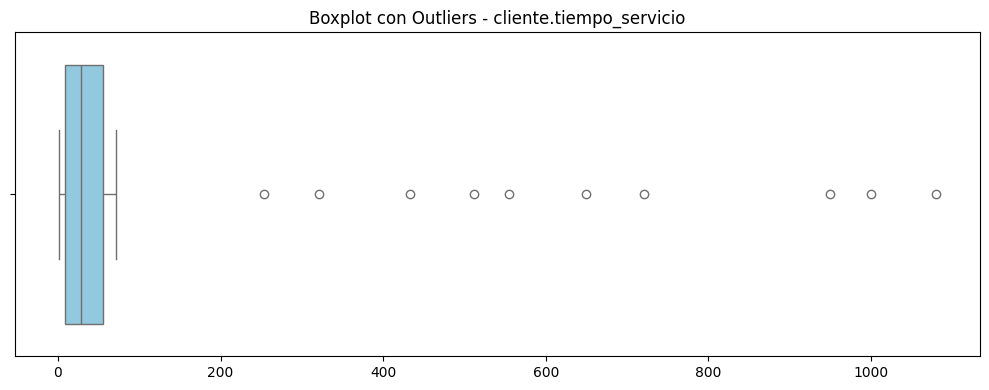

In [58]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=datos_churn, x='cliente.tiempo_servicio',color='skyblue')
plt.title('Boxplot con Outliers - cliente.tiempo_servicio')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [59]:
datos_churn.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.80,0.85,0.90,0.925, 0.95, 0.97,0.98, 0.99, 0.995])

cliente.anciano  cliente.tiempo_servicio  cuenta.cobros.mensual  \
count      7032.000000              7032.000000            7032.000000   
mean          0.162116                33.295648              64.752426   
std           0.368583                35.273030              30.091303   
min           0.000000                 1.000000              18.250000   
5%            0.000000                 1.000000              19.650000   
25%           0.000000                 9.000000              35.487500   
50%           0.000000                29.000000              70.350000   
75%           0.000000                56.000000              89.850000   
80%           0.000000                61.000000              94.250000   
85%           1.000000                65.000000              98.550000   
90%           1.000000                69.000000             102.600000   
92.5%         1.000000                71.000000             104.933750   
95%           1.000000                72.000000             107.372500   
97%           1.000000                72.000000             110.053500   
98%           1.000000                72.000000             111.519000   
99%           1.000000                72.000000             114.734500   
99.5%         1.000000                72.000000             115.842250   
max           1.000000              1080.000000             118.750000   

       cuenta.cobros.Total  
count          7032.000000  
mean           2319.592200  
std            2874.845725  
min              18.800000  
5%               49.650000  
25%             402.362500  
50%            1396.125000  
75%            3792.325000  
80%            4478.260000  
85%            5202.812500  
90%            5979.420000  
92.5%          6423.843750  
95%            6939.412500  
97%            7446.956000  
98%            7734.512000  
99%            8060.678500  
99.5%          8312.113250  
max          112212.000000

* Notamos que en cliente.tiempo_servicio existe unos valores atípicos muy grandes, se observa al analizar los percentiles, asi como la gráfica boxplot.
* Se decide eliminar estos valores atípicos, ya que si solo se truncan, tendríamos que corregir los demás valores de las otras columnas y podría generar inconvenientes posteriores.
* Decidimos eliminar los valores que sean mayores de 72, que es donde observamos en el percentil 99%, de esta manera tratamos de mantener el máximo de valores posibles del dataset.

In [60]:
datos_churn[datos_churn['cliente.tiempo_servicio']>72][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
1949                   1080.0          un año                             no   
1950                   1000.0         mensual                             si   
1956                    950.0         mensual                             no   
1960                    254.0         mensual                             no   
1962                    321.0         mensual                             si   
1967                    650.0          un año                             si   
1970                    721.0         mensual                             si   
1974                    555.0          un año                             no   
1977                    433.0         mensual                             si   
1978                    512.0         mensual                             no   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
1949      tarjeta de credito (automatico)                 103.90   
1950                   cheque electronico                  45.90   
1956                   cheque electronico                  84.10   
1960  transferencia bancaria (automatica)                  46.05   
1962                   cheque electronico                  99.80   
1967                   cheque electronico                  73.00   
1970                               cheque                  89.55   
1974                               cheque                  19.15   
1977                   cheque electronico                  89.20   
1978                               cheque                  19.55   

      cuenta.cobros.Total  
1949            112212.00  
1950             45900.00  
1956             79895.00  
1960                80.35  
1962              4259.30  
1967             47450.00  
1970              3856.75  
1974               124.40  
1977               346.20  
1978                19.55

* Si bien se podrían corregir algunos valores, consideramos que sería estar adivinando los valores de cliente.tiempo_servicio, es por eso que decidimos eliminar estos valores que serían Outliers, por más que en las demás variables se tenga valores a considerar.

In [61]:
datos_churn[datos_churn['cliente.tiempo_servicio']>72][columns_with_null].index

Index([1949, 1950, 1956, 1960, 1962, 1967, 1970, 1974, 1977, 1978], dtype='int64')

In [62]:
datos_churn.drop(datos_churn[datos_churn['cliente.tiempo_servicio']>72][columns_with_null].index, inplace=True)
datos_churn.reset_index(drop=True, inplace=True)

In [63]:
datos_churn.describe()

cliente.anciano  cliente.tiempo_servicio  cuenta.cobros.mensual  \
count      7022.000000              7022.000000            7022.000000   
mean          0.161777                32.420820              64.749197   
std           0.368273                24.534421              30.090856   
min           0.000000                 1.000000              18.250000   
25%           0.000000                 9.000000              35.462500   
50%           0.000000                29.000000              70.350000   
75%           0.000000                55.000000              89.850000   
max           1.000000                72.000000             118.750000   

       cuenta.cobros.Total  
count          7022.000000  
mean           2281.006665  
std            2265.759951  
min              18.800000  
25%             402.600000  
50%            1395.525000  
75%            3781.512500  
max            8684.800000

* COmo observamos, ya quedo corregido el dataset, sin outliers posibles.
* COmo no eran demasiados outliers, decidimos eliminarlos y asi no complicarnos posteriormente corrigiendo otras variables relacionadas.

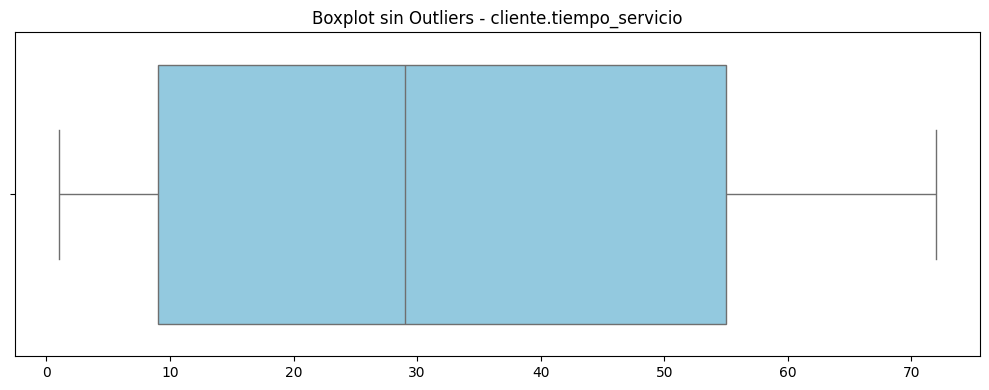

In [64]:
## Gráfica después de tratar los valores atípicos
plt.figure(figsize=(10, 4))
sns.boxplot(data=datos_churn, x='cliente.tiempo_servicio',color='skyblue')
plt.title('Boxplot sin Outliers - cliente.tiempo_servicio')
plt.xlabel('')
plt.tight_layout()
plt.show()

### **2.2.2.4 cuenta.facturacion_electronica, cuenta.metodo_pago y cuenta.contrato**

>>> <ins>**cuenta.facturacion_electronica**</ins>

In [65]:
datos_churn[datos_churn['cuenta.facturacion_electronica'].isnull()==True][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
436                      67.0            None                           None   
1605                      9.0         mensual                           None   
2025                     50.0            None                           None   
4711                     72.0            None                           None   
4727                     60.0        dos años                           None   
4731                      5.0         mensual                           None   
4743                      1.0            None                           None   
5378                     45.0            None                           None   
5391                      6.0            None                           None   
5986                     62.0            None                           None   
6160                     19.0            None                           None   
6631                     32.0            None                           None   
6634                     26.0            None                           None   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
436       tarjeta de credito (automatico)                 102.78   
1605                               cheque                  98.96   
2025                               cheque                 103.05   
4711      tarjeta de credito (automatico)                  83.55   
4727                                 None                  20.95   
4731                                 None                  78.95   
4743                                 None                  43.30   
5378                                 None                  97.09   
5391                                 None                  19.70   
5986  transferencia bancaria (automatica)                 115.47   
6160                                 None                  19.90   
6631                                 None                  78.90   
6634                                 None                  82.00   

      cuenta.cobros.Total  
436               6886.25  
1605               890.60  
2025              5153.50  
4711              6015.60  
4727              1257.00  
4731               378.40  
4743                43.30  
5378              4368.85  
5391               111.65  
5986              7159.05  
6160               357.70  
6631              2447.95  
6634              2083.10

In [66]:
datos_churn['cuenta.facturacion_electronica'].unique()

array(['no', 'si', None], dtype=object)

In [67]:
datos_churn['cuenta.facturacion_electronica'].isnull().sum()

13

* Sabemos que la facturación electrónica es si el cliente quiere recibir el recibo en línea o no. Por ende el valor de None, entendemos que es porque no hay referencia de este dato.
* Dada esta situación, y tratandose de un aspecto binario y de decisión del cliente que quizás no se pudo conseguir, trataremos de analizar las cantidad que tenemos en nuestra base de datos para estas subcategorías.
* Decidimos imputar estos valores con el **most frecuente (moda)**, debido a que la cantidad de nulos que se tiene en esta variable es pequeña comparado con el dataset total y consideramos no afectaría en gran medida realizar este ajuste. Además, se tienen valores numéricos en otras variables para estos índices, por ende eliminarlos, quizás no sea la mejor opción, ya que podemos utilizar los demás datos para nuestro modelo.

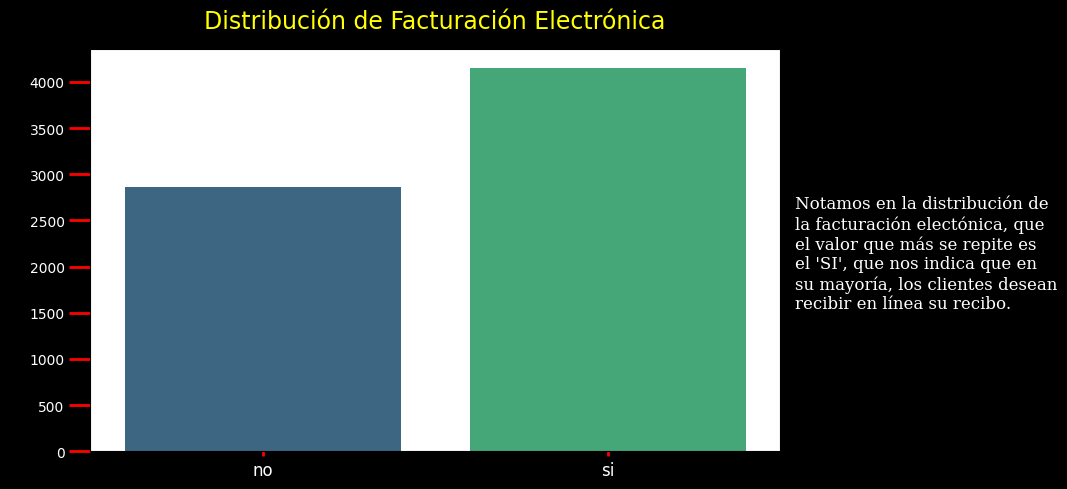

In [68]:
plt.figure(figsize=(8, 5))
sns.countplot(data=datos_churn, x='cuenta.facturacion_electronica', palette='viridis')

# Añadir texto de conclusión
conclusion_text = '''
Notamos en la distribución de
la facturación electónica, que
el valor que más se repite es
el 'SI', que nos indica que en
su mayoría, los clientes desean
recibir en línea su recibo.'''

plt.figtext(1, 0.5, conclusion_text, fontdict={'fontsize': 12, 'fontfamily':'serif', 'fontstyle':'normal', 'fontweight': 'normal', 'color': 'white'}, va='center', ha='left')

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('black')

# Cambiar el color de las etiquetas en el eje x - y
plt.tick_params(axis='y', labelcolor='white', width=2, length = 15, colors='r', grid_color='r',grid_alpha=0.2)
plt.tick_params(axis='x', labelcolor='white', width=2, labelsize='large', colors='r', grid_color='r',grid_alpha=0.2)

# # Agregar los porcentajes sobre las barras
# for bar in bars.patches:
#     width = bar.get_width()
#     height = bar.get_height()
#     y = bar.get_y()
#     media = bar.get_y() + bar.get_height() / 2
#     # print((width, height, y, media))
#     percentage = f'{100 * width / total:.1f}%'
#     plt.text(width, media, percentage,  # Ajustando posición horizontal y vertical
#               ha='left', va='center', color='black')  #, fontweight='bold'

plt.title('Distribución de Facturación Electrónica', pad=15, fontdict={'fontsize': 17, 'color':'yellow', 'fontweight': 'normal'})
plt.xlabel('')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

In [69]:
datos_churn['cuenta.facturacion_electronica'].value_counts()

cuenta.facturacion_electronica
si    4150
no    2859
Name: count, dtype: int64

In [70]:
datos_churn['cuenta.facturacion_electronica'].mode()[0]

'si'

In [71]:
## consiguiendo los índices con valores nulos en esta variable, para validar posterior a la imputación
idx_facturacion_electronica_null = datos_churn[datos_churn['cuenta.facturacion_electronica'].isnull() == True].index
idx_facturacion_electronica_null

Index([436, 1605, 2025, 4711, 4727, 4731, 4743, 5378, 5391, 5986, 6160, 6631,
       6634],
      dtype='int64')

In [72]:
datos_churn['cuenta.facturacion_electronica'].fillna(datos_churn['cuenta.facturacion_electronica'].mode()[0], inplace=True)

In [73]:
datos_churn.iloc[idx_facturacion_electronica_null][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
436                      67.0            None                             si   
1605                      9.0         mensual                             si   
2025                     50.0            None                             si   
4711                     72.0            None                             si   
4727                     60.0        dos años                             si   
4731                      5.0         mensual                             si   
4743                      1.0            None                             si   
5378                     45.0            None                             si   
5391                      6.0            None                             si   
5986                     62.0            None                             si   
6160                     19.0            None                             si   
6631                     32.0            None                             si   
6634                     26.0            None                             si   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
436       tarjeta de credito (automatico)                 102.78   
1605                               cheque                  98.96   
2025                               cheque                 103.05   
4711      tarjeta de credito (automatico)                  83.55   
4727                                 None                  20.95   
4731                                 None                  78.95   
4743                                 None                  43.30   
5378                                 None                  97.09   
5391                                 None                  19.70   
5986  transferencia bancaria (automatica)                 115.47   
6160                                 None                  19.90   
6631                                 None                  78.90   
6634                                 None                  82.00   

      cuenta.cobros.Total  
436               6886.25  
1605               890.60  
2025              5153.50  
4711              6015.60  
4727              1257.00  
4731               378.40  
4743                43.30  
5378              4368.85  
5391               111.65  
5986              7159.05  
6160               357.70  
6631              2447.95  
6634              2083.10

* Observamos que nuestra imputación por la moda se realizó de manera satisfactoria.

In [74]:
datos_churn[columns_with_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente.tiempo_servicio         7022 non-null   float64
 1   cuenta.contrato                 7002 non-null   object 
 2   cuenta.facturacion_electronica  7022 non-null   object 
 3   cuenta.metodo_pago              7002 non-null   object 
 4   cuenta.cobros.mensual           7022 non-null   float64
 5   cuenta.cobros.Total             7022 non-null   float64
dtypes: float64(3), object(3)
memory usage: 329.3+ KB


* Solo nos quedan dos variables a analizar sus valores nulos

>>> <ins>**cuenta.metodo_pago**</ins>

* En este caso, al ser variables categóricas, decidimos evaluar bien nuestro dataset y ver de que forma se le puede imputar, podría ser la moda, o alguna relación entre filas.
* De no encontrar algo óptimo, decidiremos eliminar las filas, pero como última opción.

In [75]:
datos_churn['cuenta.metodo_pago'].unique()

array(['cheque', 'cheque electronico', 'tarjeta de credito (automatico)',
       'transferencia bancaria (automatica)', None], dtype=object)

In [76]:
idx_metodo_null = datos_churn[datos_churn['cuenta.metodo_pago'].isnull() == True].index
idx_metodo_null

Index([ 962, 1603, 2023, 4702, 4708, 4714, 4720, 4722, 4727, 4731, 4733, 4743,
       5378, 5389, 5391, 5394, 6160, 6631, 6634, 6635],
      dtype='int64')

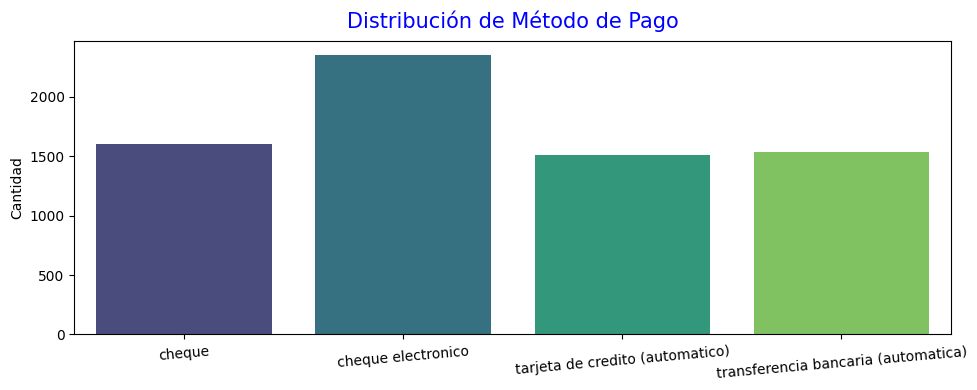

In [77]:
plt.figure(figsize=(10, 4))
sns.countplot(data=datos_churn, x='cuenta.metodo_pago', palette='viridis')
plt.title('Distribución de Método de Pago', pad=10, fontdict={'fontsize': 15, 'color':'Blue', 'fontweight': 'normal'})
plt.xlabel('')
plt.xticks(rotation=5)
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

In [78]:
datos_churn.iloc[idx_metodo_null][list(columns_with_null) + ['Churn']]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
962                      21.0            None                             si   
1603                     18.0            None                             no   
2023                     13.0         mensual                             si   
4702                     30.0            None                             no   
4708                      1.0            None                             si   
4714                     42.0            None                             si   
4720                     43.0            None                             si   
4722                     56.0        dos años                             no   
4727                     60.0        dos años                             si   
4731                      5.0         mensual                             si   
4733                     62.0            None                             si   
4743                      1.0            None                             si   
5378                     45.0            None                             si   
5389                     56.0            None                             si   
5391                      6.0            None                             si   
5394                     37.0         mensual                             si   
6160                     19.0            None                             si   
6631                     32.0            None                             si   
6634                     26.0            None                             si   
6635                     35.0            None                             si   

     cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total Churn  
962                None                  74.56              1565.70    si  
1603               None                  20.05               360.90    no  
2023               None                  59.90               788.35    no  
4702               None                 110.45              3327.05    no  
4708               None                  70.30                70.30    si  
4714               None                 104.75              4399.50    si  
4720               None                 104.60              4759.85    si  
4722               None                  59.50              3389.25    no  
4727               None                  20.95              1257.00    no  
4731               None                  78.95               378.40    si  
4733               None                  84.95              5150.55    no  
4743               None                  43.30                43.30    si  
5378               None                  97.09              4368.85    no  
5389               None                  86.15              4824.45    no  
5391               None                  19.70               111.65    no  
5394               None                  78.95              2839.65    si  
6160               None                  19.90               357.70    no  
6631               None                  78.90              2447.95    si  
6634               None                  82.00              2083.10    no  
6635               None                  89.65              3161.60    no

In [79]:
from scipy.stats import chi2_contingency

# Creamos una tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn['Churn'], datos_churn['cuenta.metodo_pago'])

# Realizamos la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

# Imprimimimos el valor **p** para ver si la relación es significativa
print(f'Valor p: {p}')

# Si el valor p es pequeño (por ejemplo, < 0.05), entonces hay una relación significativa
if p < 0.05:
    print(f'Existe una relación significativa entre Churn y cuenta metodo_pago')
    print('*****'*5)
else:
    print(f'No hay relación significativa entre Churn y cuenta metodo_pago')
    print('*****'*5)

################################################################################
################################################################################

# Creamos una tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn['Churn'], datos_churn['cuenta.contrato'])

# Realizamos la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

# Imprimimimos el valor **p** para ver si la relación es significativa
print(f'Valor p: {p}')

# Si el valor p es pequeño (por ejemplo, < 0.05), entonces hay una relación significativa
if p < 0.05:
    print(f'Existe una relación significativa entre Churn y cuenta contrato')
    print('*****'*5)
else:
    print(f'No hay relación significativa entre Churn y cuenta contrato')
    print('*****'*5)

Valor p: 1.4552636966710934e-138
Existe una relación significativa entre Churn y cuenta metodo_pago
*************************
Valor p: 3.7802691142460995e-257
Existe una relación significativa entre Churn y cuenta contrato
*************************


* Debido a que poseo más valores NO en CHURN que valores SI, y considerando que existe una relación significativa entre la variable objetivo con las variables contrato y metodo_pago, decidimos eliminar cuando el CHURN sea NO y existan valores NONE en las otras columnas. Esto porque tengo más valores NO en variable objetivo.
* No eliminamos el CHURN cuando es SI, ya que al tener relación significativa, puede ser de gran utilidad al momento de realizar el análisis, y como quedarían menos variables a imputar, el sesgo sería menor.

In [80]:
## Consiguiendo para los índices donde tengo nulos en método_pago, que sea CHURN NO
df = datos_churn.loc[idx_metodo_null][datos_churn.loc[idx_metodo_null]['Churn'] == 'no'][columns_with_null]
df

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
1603                     18.0            None                             no   
2023                     13.0         mensual                             si   
4702                     30.0            None                             no   
4722                     56.0        dos años                             no   
4727                     60.0        dos años                             si   
4733                     62.0            None                             si   
5378                     45.0            None                             si   
5389                     56.0            None                             si   
5391                      6.0            None                             si   
6160                     19.0            None                             si   
6634                     26.0            None                             si   
6635                     35.0            None                             si   

     cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
1603               None                  20.05               360.90  
2023               None                  59.90               788.35  
4702               None                 110.45              3327.05  
4722               None                  59.50              3389.25  
4727               None                  20.95              1257.00  
4733               None                  84.95              5150.55  
5378               None                  97.09              4368.85  
5389               None                  86.15              4824.45  
5391               None                  19.70               111.65  
6160               None                  19.90               357.70  
6634               None                  82.00              2083.10  
6635               None                  89.65              3161.60

In [81]:
## Ahora validamos que metodo_pago y contrato, ambos sean NONE
df[(df['cuenta.metodo_pago'].isnull() == True) & (df['cuenta.contrato'].isnull() == True)]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
1603                     18.0            None                             no   
4702                     30.0            None                             no   
4733                     62.0            None                             si   
5378                     45.0            None                             si   
5389                     56.0            None                             si   
5391                      6.0            None                             si   
6160                     19.0            None                             si   
6634                     26.0            None                             si   
6635                     35.0            None                             si   

     cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
1603               None                  20.05               360.90  
4702               None                 110.45              3327.05  
4733               None                  84.95              5150.55  
5378               None                  97.09              4368.85  
5389               None                  86.15              4824.45  
5391               None                  19.70               111.65  
6160               None                  19.90               357.70  
6634               None                  82.00              2083.10  
6635               None                  89.65              3161.60

In [82]:
## Conseguimos los índices para eliminar estas filas y reseteamos el índice
idx_new_drop = df[(df['cuenta.metodo_pago'].isnull() == True) & (df['cuenta.contrato'].isnull() == True)].index
idx_new_drop

Index([1603, 4702, 4733, 5378, 5389, 5391, 6160, 6634, 6635], dtype='int64')

In [83]:
## Eliminamos las filas con estos índices en el dataframe original
datos_churn.drop(idx_new_drop, inplace=True)
datos_churn.reset_index(drop=True, inplace=True)

In [84]:
## Validamos los nulos que ahora tenemos
datos_churn[columns_with_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7013 entries, 0 to 7012
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente.tiempo_servicio         7013 non-null   float64
 1   cuenta.contrato                 7002 non-null   object 
 2   cuenta.facturacion_electronica  7013 non-null   object 
 3   cuenta.metodo_pago              7002 non-null   object 
 4   cuenta.cobros.mensual           7013 non-null   float64
 5   cuenta.cobros.Total             7013 non-null   float64
dtypes: float64(3), object(3)
memory usage: 328.9+ KB


* Vemos que tenemos menos nulos que antes, la eliminación fue exitosa
* Ahora solo tenemos Nan, cuando el CHURN es SI, esto tenemos que imputarlo, para esto usaremos la moda

In [85]:
idx_metodo_null_2 = datos_churn[datos_churn['cuenta.metodo_pago'].isnull() == True].index
idx_metodo_null_2

Index([962, 2022, 4706, 4712, 4718, 4720, 4725, 4729, 4740, 5388, 6624], dtype='int64')

In [86]:
datos_churn.iloc[idx_metodo_null_2][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
962                      21.0            None                             si   
2022                     13.0         mensual                             si   
4706                      1.0            None                             si   
4712                     42.0            None                             si   
4718                     43.0            None                             si   
4720                     56.0        dos años                             no   
4725                     60.0        dos años                             si   
4729                      5.0         mensual                             si   
4740                      1.0            None                             si   
5388                     37.0         mensual                             si   
6624                     32.0            None                             si   

     cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
962                None                  74.56              1565.70  
2022               None                  59.90               788.35  
4706               None                  70.30                70.30  
4712               None                 104.75              4399.50  
4718               None                 104.60              4759.85  
4720               None                  59.50              3389.25  
4725               None                  20.95              1257.00  
4729               None                  78.95               378.40  
4740               None                  43.30                43.30  
5388               None                  78.95              2839.65  
6624               None                  78.90              2447.95

* Si bien vemos que en las dos variables con nulos, se tienen para las mismas filas, no las eliminamos porque estas estan en el CHURN SI.

In [87]:
## Llenamos con la moda, que sería cheque electrónico
datos_churn['cuenta.metodo_pago'].fillna(datos_churn['cuenta.metodo_pago'].mode()[0], inplace=True)

In [88]:
## validamos que se haya realizado satisfactoriamente la imputación
datos_churn.iloc[idx_metodo_null_2][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
962                      21.0            None                             si   
2022                     13.0         mensual                             si   
4706                      1.0            None                             si   
4712                     42.0            None                             si   
4718                     43.0            None                             si   
4720                     56.0        dos años                             no   
4725                     60.0        dos años                             si   
4729                      5.0         mensual                             si   
4740                      1.0            None                             si   
5388                     37.0         mensual                             si   
6624                     32.0            None                             si   

      cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
962   cheque electronico                  74.56              1565.70  
2022  cheque electronico                  59.90               788.35  
4706  cheque electronico                  70.30                70.30  
4712  cheque electronico                 104.75              4399.50  
4718  cheque electronico                 104.60              4759.85  
4720  cheque electronico                  59.50              3389.25  
4725  cheque electronico                  20.95              1257.00  
4729  cheque electronico                  78.95               378.40  
4740  cheque electronico                  43.30                43.30  
5388  cheque electronico                  78.95              2839.65  
6624  cheque electronico                  78.90              2447.95

* La imputación se realizó satisfactoriamente para el método de pago

>>> <ins>**cuenta.contrato**</ins>

In [89]:
datos_churn['cuenta.contrato'].unique()

array(['mensual', 'dos años', 'un año', None], dtype=object)

In [90]:
idx_contrato_null = datos_churn[datos_churn['cuenta.contrato'].isnull() == True].index
idx_contrato_null

Index([436, 962, 2024, 4706, 4709, 4712, 4718, 4740, 5374, 5980, 6624], dtype='int64')

In [91]:
datos_churn.iloc[idx_contrato_null][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
436                      67.0            None                             si   
962                      21.0            None                             si   
2024                     50.0            None                             si   
4706                      1.0            None                             si   
4709                     72.0            None                             si   
4712                     42.0            None                             si   
4718                     43.0            None                             si   
4740                      1.0            None                             si   
5374                     72.0            None                             si   
5980                     62.0            None                             si   
6624                     32.0            None                             si   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
436       tarjeta de credito (automatico)                 102.78   
962                    cheque electronico                  74.56   
2024                               cheque                 103.05   
4706                   cheque electronico                  70.30   
4709      tarjeta de credito (automatico)                  83.55   
4712                   cheque electronico                 104.75   
4718                   cheque electronico                 104.60   
4740                   cheque electronico                  43.30   
5374      tarjeta de credito (automatico)                  19.80   
5980  transferencia bancaria (automatica)                 115.47   
6624                   cheque electronico                  78.90   

      cuenta.cobros.Total  
436               6886.25  
962               1565.70  
2024              5153.50  
4706                70.30  
4709              6015.60  
4712              4399.50  
4718              4759.85  
4740                43.30  
5374              1468.75  
5980              7159.05  
6624              2447.95

* Recordemos que ahora solo tenemos None para cuando el CHURN es SI, así que lo imputaremos.
* Para esto realizaremos otra forma, como sabemos que esta variable, esta relacionada con el tiempo_servicio, decidimos validar en lo más común del tiempo de servicio con la finalidad de compararlo con esta variable.

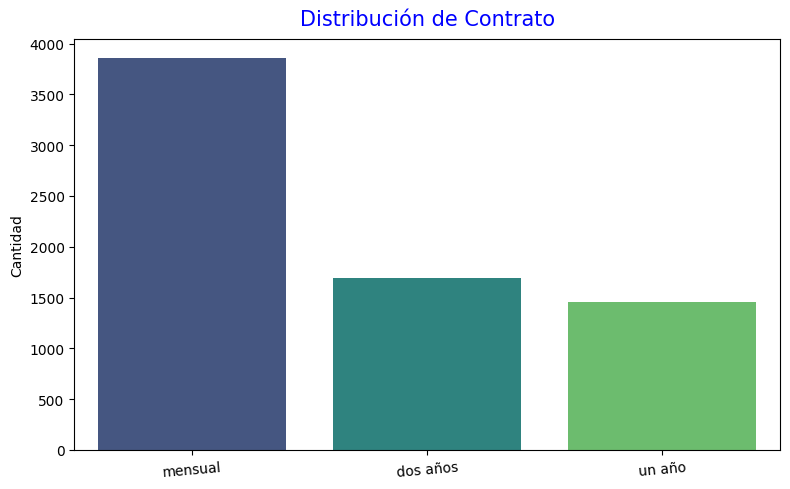

In [92]:
plt.figure(figsize=(8, 5))
sns.countplot(data=datos_churn, x='cuenta.contrato', palette='viridis')
plt.title('Distribución de Contrato', pad=10, fontdict={'fontsize': 15, 'color':'Blue', 'fontweight': 'normal'})
plt.xlabel('')
plt.xticks(rotation=5)
plt.ylabel('Cantidad')
plt.tight_layout()

* Notamos que la moda es mensual. Sin embargo, no solo analizaremos con la moda, sino también con el tiempo de servicio. Visualizar la gráfica posterior

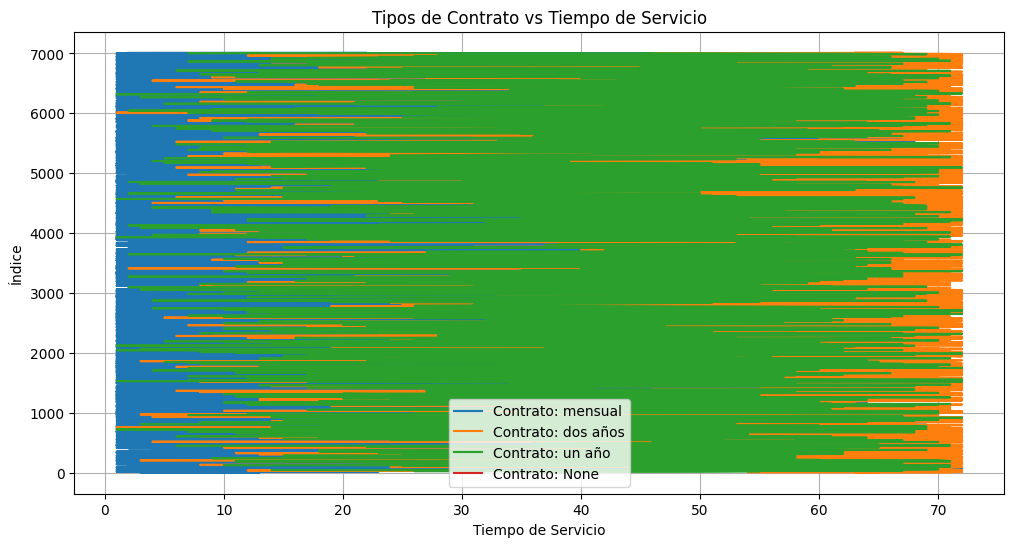

In [93]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
plt.figure(figsize=(12, 6))

# Obtener los tipos únicos de contratos
tipos_contrato = datos_churn['cuenta.contrato'].unique()

# Graficar cada tipo de contrato
for contrato in tipos_contrato:
    # Filtrar datos por tipo de contrato
    datos_filtrados = datos_churn[datos_churn['cuenta.contrato'] == contrato]

    # Graficar 'cliente.tiempo_servicio' en el eje x y algún valor de y (por ejemplo, el índice o una métrica)
    plt.plot(datos_filtrados['cliente.tiempo_servicio'],
             datos_filtrados.index,  # Usar el índice o algún valor numérico
             label=f'Contrato: {contrato}')  # Leyenda para cada tipo de contrato

# Personalizar el gráfico
plt.title('Tipos de Contrato vs Tiempo de Servicio')
plt.xlabel('Tiempo de Servicio')
plt.ylabel('Índice')
plt.legend()  # Mostrar leyenda
plt.grid()    # Añadir cuadrícula para mejor visualización

# Mostrar el gráfico
plt.show()

* En la gráfica observamos que el contrato mensual, por lo general esta referenciado con tiempos de servicio menores de 20 en promedio.
* Tmabién observamos que el contrato de año, se mantiene perenme en general para tiempos de servicio de 20 a 60 en promedio.
* Y los contratos de dos años, se mantienen por lo general para tiempos de servicio mayores de 60.
* Esto no es una regla, pero consideramos que es mejor que solo imputar por la moda, ya que se podría generar cierto sesgo, y de esta manera quizás reducimos el sesgo.

In [94]:
## Validando los promedios para los tiempos de servicio
datos_churn.groupby('cuenta.contrato')['cliente.tiempo_servicio'].mean()

cuenta.contrato
dos años    56.883294
mensual     18.006746
un año      42.110959
Name: cliente.tiempo_servicio, dtype: float64

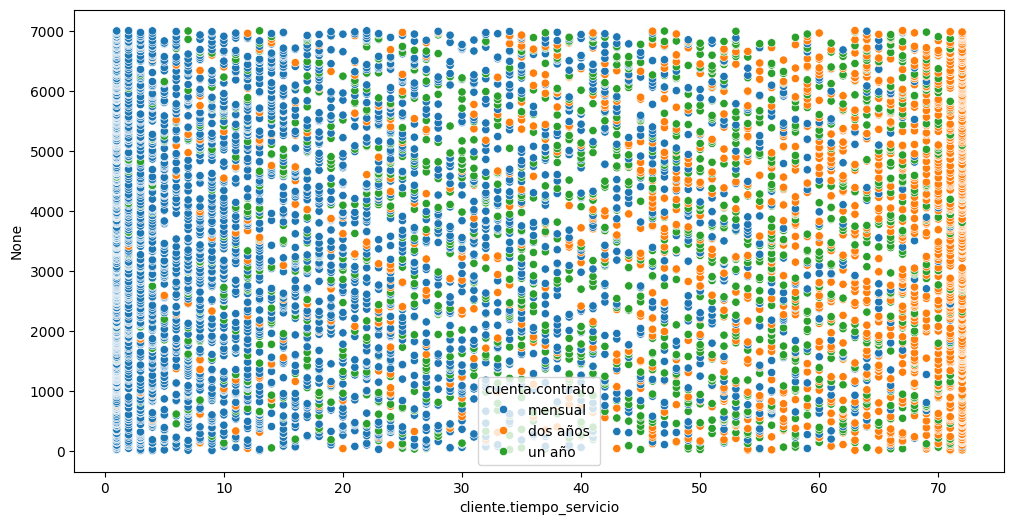

In [95]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=datos_churn,
                x='cliente.tiempo_servicio',
                y=datos_churn.index,  # Eje Y como los índices del DataFrame
                hue='cuenta.contrato')

# Mostrar el gráfico
plt.show()

* COnsiderando esto, decidimos realizar una imputación como sigue:
  > Menos de 25 se colocará MENSUAL

  > Entre 25 y 55 se colocará UN AÑO

  > Mayor de 55 se colocará DOS AÑOS

In [96]:
datos_churn.iloc[idx_contrato_null][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
436                      67.0            None                             si   
962                      21.0            None                             si   
2024                     50.0            None                             si   
4706                      1.0            None                             si   
4709                     72.0            None                             si   
4712                     42.0            None                             si   
4718                     43.0            None                             si   
4740                      1.0            None                             si   
5374                     72.0            None                             si   
5980                     62.0            None                             si   
6624                     32.0            None                             si   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
436       tarjeta de credito (automatico)                 102.78   
962                    cheque electronico                  74.56   
2024                               cheque                 103.05   
4706                   cheque electronico                  70.30   
4709      tarjeta de credito (automatico)                  83.55   
4712                   cheque electronico                 104.75   
4718                   cheque electronico                 104.60   
4740                   cheque electronico                  43.30   
5374      tarjeta de credito (automatico)                  19.80   
5980  transferencia bancaria (automatica)                 115.47   
6624                   cheque electronico                  78.90   

      cuenta.cobros.Total  
436               6886.25  
962               1565.70  
2024              5153.50  
4706                70.30  
4709              6015.60  
4712              4399.50  
4718              4759.85  
4740                43.30  
5374              1468.75  
5980              7159.05  
6624              2447.95

In [97]:
# Imputación basada en los tiempos de servicio
def imputar_contrato(row):
    if pd.isna(row['cuenta.contrato']):  # Solo imputar si el valor es NaN
        if row['cliente.tiempo_servicio'] < 25:
            return 'mensual'
        elif 25 <= row['cliente.tiempo_servicio'] <= 55:
            return 'un año'
        else:
            return 'dos años'
    return row['cuenta.contrato']  # Mantener el valor original si no es NaN

# Aplicar la función a la columna 'cuenta.contrato'
datos_churn['cuenta.contrato'] = datos_churn.apply(imputar_contrato, axis=1)

# Verificar los cambios
print(datos_churn['cuenta.contrato'].isnull().sum())

0


In [98]:
datos_churn.iloc[idx_contrato_null][columns_with_null]

cliente.tiempo_servicio cuenta.contrato cuenta.facturacion_electronica  \
436                      67.0        dos años                             si   
962                      21.0         mensual                             si   
2024                     50.0          un año                             si   
4706                      1.0         mensual                             si   
4709                     72.0        dos años                             si   
4712                     42.0          un año                             si   
4718                     43.0          un año                             si   
4740                      1.0         mensual                             si   
5374                     72.0        dos años                             si   
5980                     62.0        dos años                             si   
6624                     32.0          un año                             si   

                       cuenta.metodo_pago  cuenta.cobros.mensual  \
436       tarjeta de credito (automatico)                 102.78   
962                    cheque electronico                  74.56   
2024                               cheque                 103.05   
4706                   cheque electronico                  70.30   
4709      tarjeta de credito (automatico)                  83.55   
4712                   cheque electronico                 104.75   
4718                   cheque electronico                 104.60   
4740                   cheque electronico                  43.30   
5374      tarjeta de credito (automatico)                  19.80   
5980  transferencia bancaria (automatica)                 115.47   
6624                   cheque electronico                  78.90   

      cuenta.cobros.Total  
436               6886.25  
962               1565.70  
2024              5153.50  
4706                70.30  
4709              6015.60  
4712              4399.50  
4718              4759.85  
4740                43.30  
5374              1468.75  
5980              7159.05  
6624              2447.95

* Validamos que la imputación fue realizada satisfactoriamente para variable contrato.

In [99]:
## Verificamos que ya no tenemos valores nulos en el dataframe final
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7013 entries, 0 to 7012
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       7013 non-null   object 
 1   Churn                            7013 non-null   object 
 2   cliente.genero                   7013 non-null   object 
 3   cliente.anciano                  7013 non-null   int64  
 4   cliente.pareja                   7013 non-null   object 
 5   cliente.dependientes             7013 non-null   object 
 6   cliente.tiempo_servicio          7013 non-null   float64
 7   telefono.servicio_telefono       7013 non-null   object 
 8   telefono.varias_lineas           7013 non-null   object 
 9   internet.servicio_internet       7013 non-null   object 
 10  internet.seguridad_online        7013 non-null   object 
 11  internet.backup_online           7013 non-null   object 
 12  internet.proteccion_

* NO TENEMOS MÁS VALORES NULOS EN NUESTRO DATASET.
* AHORA SI PODEMOS TRABAJARLO PARA REALIZAR NUESTRO MODELO

##**2.3 Normalizacion de datos**

###**2.3.1 Sin segmentar las variables continuas**

In [100]:
datos_churn_new = datos_churn.copy()
datos_churn_new.head()

id_cliente Churn cliente.genero  cliente.anciano cliente.pareja  \
0  0003-MKNFE    no      masculino                0             no   
1  0004-TLHLJ    si      masculino                0             no   
2  0011-IGKFF    si      masculino                1             si   
3  0013-EXCHZ    si       femenino                1             si   
4  0013-MHZWF    no       femenino                0             no   

  cliente.dependientes  cliente.tiempo_servicio telefono.servicio_telefono  \
0                   no                      9.0                         si   
1                   no                      4.0                         si   
2                   no                     13.0                         si   
3                   no                      3.0                         si   
4                   si                      9.0                         si   

  telefono.varias_lineas internet.servicio_internet internet.seguridad_online  \
0                     si                        DSL                        no   
1                     no               fibra optica                        no   
2                     no               fibra optica                        no   
3                     no               fibra optica                        no   
4                     no                        DSL                        no   

  internet.backup_online internet.proteccion_dispositivo  \
0                     no                              no   
1                     no                              si   
2                     si                              si   
3                     no                              no   
4                     no                              no   

  internet.soporte_tecnico internet.tv_streaming internet.peliculas_streaming  \
0                       no                    no                           si   
1                       no                    no                           no   
2                       no                    si                           si   
3                       si                    si                           no   
4                       si                    si                           si   

  cuenta.contrato cuenta.facturacion_electronica  \
0         mensual                             no   
1         mensual                             si   
2         mensual                             si   
3         mensual                             si   
4         mensual                             si   

                cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
0                           cheque                   59.9               542.40  
1               cheque electronico                   73.9               280.85  
2               cheque electronico                   98.0              1237.85  
3                           cheque                   83.9               267.40  
4  tarjeta de credito (automatico)                   69.4               571.45

* Observamos que tenemos columnas binarias y con más de dos subcategorías.
* La variable id_cliente, se procede a eliminarla, ya que no aporta valor a nuestro objetivo.
* Se procederá a realizar una transformación de las variables binarias en 0 y 1
* Las variables con más de dos valores, se procederá a realizar un one_hot_encoding ya que no presentan una relación de jerarquía.

In [101]:
## Eliminado columna id_cliente
datos_churn_new.drop('id_cliente', axis=1, inplace=True)
datos_churn_new.head()

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   

   cliente.tiempo_servicio telefono.servicio_telefono telefono.varias_lineas  \
0                      9.0                         si                     si   
1                      4.0                         si                     no   
2                     13.0                         si                     no   
3                      3.0                         si                     no   
4                      9.0                         si                     no   

  internet.servicio_internet internet.seguridad_online internet.backup_online  \
0                        DSL                        no                     no   
1               fibra optica                        no                     no   
2               fibra optica                        no                     si   
3               fibra optica                        no                     no   
4                        DSL                        no                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   

  cuenta.facturacion_electronica               cuenta.metodo_pago  \
0                             no                           cheque   
1                             si               cheque electronico   
2                             si               cheque electronico   
3                             si                           cheque   
4                             si  tarjeta de credito (automatico)   

   cuenta.cobros.mensual  cuenta.cobros.Total  
0                   59.9               542.40  
1                   73.9               280.85  
2                   98.0              1237.85  
3                   83.9               267.40  
4                   69.4               571.45

In [102]:
## verificando nuestras variables categóricas
variables_categoricas = datos_churn_new.select_dtypes(include=['object']).columns
variables_categoricas

Index(['Churn', 'cliente.genero', 'cliente.pareja', 'cliente.dependientes',
       'telefono.servicio_telefono', 'telefono.varias_lineas',
       'internet.servicio_internet', 'internet.seguridad_online',
       'internet.backup_online', 'internet.proteccion_dispositivo',
       'internet.soporte_tecnico', 'internet.tv_streaming',
       'internet.peliculas_streaming', 'cuenta.contrato',
       'cuenta.facturacion_electronica', 'cuenta.metodo_pago'],
      dtype='object')

In [103]:
# Verificar cuántas categorías tiene cada variable categórica

variables_categoricas_binarias = []
variables_categoricas_multiples = []

for col in variables_categoricas:
    unique_values = datos_churn[col].nunique()

    if unique_values == 2:
        variables_categoricas_binarias.append(col)
    else:
        variables_categoricas_multiples.append(col)

print("Variables categóricas binarias:")
print(variables_categoricas_binarias)
print("\nVariables categóricas con múltiples categorías:")
print(variables_categoricas_multiples)

Variables categóricas binarias:
['Churn', 'cliente.genero', 'cliente.pareja', 'cliente.dependientes', 'telefono.servicio_telefono', 'cuenta.facturacion_electronica']

Variables categóricas con múltiples categorías:
['telefono.varias_lineas', 'internet.servicio_internet', 'internet.seguridad_online', 'internet.backup_online', 'internet.proteccion_dispositivo', 'internet.soporte_tecnico', 'internet.tv_streaming', 'internet.peliculas_streaming', 'cuenta.contrato', 'cuenta.metodo_pago']


In [104]:
## Transformando las variables binarias en 0 y 1
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for col in variables_categoricas_binarias:
    datos_churn_new[col] = label_encoder.fit_transform(datos_churn_new[col])

In [105]:
datos_churn_new[variables_categoricas_binarias].head(10)

Churn  cliente.genero  cliente.pareja  cliente.dependientes  \
0      0               1               0                     0   
1      1               1               0                     0   
2      1               1               1                     0   
3      1               0               1                     0   
4      0               0               0                     1   
5      0               0               1                     0   
6      0               1               1                     0   
7      0               0               0                     0   
8      0               0               1                     1   
9      0               1               0                     0   

   telefono.servicio_telefono  cuenta.facturacion_electronica  
0                           1                               0  
1                           1                               1  
2                           1                               1  
3                           1                               1  
4                           1                               1  
5                           1                               1  
6                           1                               1  
7                           1                               1  
8                           1                               1  
9                           0                               0

* Solo para recordar, notamos que el CHURN NO == 0 y el CHURN SI = 1

In [106]:
## Aplicando one-hot-encoding a las demás variables categóricas múltiples
datos_churn_new = pd.get_dummies(datos_churn_new, columns=variables_categoricas_multiples, drop_first=True)

In [107]:
datos_churn_new.replace(True, 1, inplace=True)
datos_churn_new.replace(False, 0, inplace=True)

In [108]:
datos_churn_new.head(8)

Churn  cliente.genero  cliente.anciano  cliente.pareja  \
0      0               1                0               0   
1      1               1                0               0   
2      1               1                1               1   
3      1               0                1               1   
4      0               0                0               0   
5      0               0                1               1   
6      0               1                0               1   
7      0               0                1               0   

   cliente.dependientes  cliente.tiempo_servicio  telefono.servicio_telefono  \
0                     0                      9.0                           1   
1                     0                      4.0                           1   
2                     0                     13.0                           1   
3                     0                      3.0                           1   
4                     1                      9.0                           1   
5                     0                     71.0                           1   
6                     0                     63.0                           1   
7                     0                      7.0                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0                  59.90               542.40   
1                               1                  73.90               280.85   
2                               1                  98.00              1237.85   
3                               1                  83.90               267.40   
4                               1                  69.40               571.45   
5                               1                 109.70              7904.25   
6                               1                  84.65              5377.80   
7                               1                  48.20               340.35   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   
5                          0                                                0   
6                          1                                                0   
7                          0                                                0   

   internet.servicio_internet_fibra optica  internet.servicio_internet_no  \
0                                        0                              0   
1                                        1                              0   
2                                        1                              0   
3                                        1                              0   
4                                        0                              0   
5                                        1                              0   
6                                        1                              0   
7                                        0                              0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   
5                             1   
6                             1   
7                             1   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                 

* Validamos que se haya realizado la Normalización de variables correctamente.

###**2.3.2 Segmentando las variables continuas**

In [109]:
datos_churn_segmentado = datos_churn.copy()
datos_churn_segmentado.head()

id_cliente Churn cliente.genero  cliente.anciano cliente.pareja  \
0  0003-MKNFE    no      masculino                0             no   
1  0004-TLHLJ    si      masculino                0             no   
2  0011-IGKFF    si      masculino                1             si   
3  0013-EXCHZ    si       femenino                1             si   
4  0013-MHZWF    no       femenino                0             no   

  cliente.dependientes  cliente.tiempo_servicio telefono.servicio_telefono  \
0                   no                      9.0                         si   
1                   no                      4.0                         si   
2                   no                     13.0                         si   
3                   no                      3.0                         si   
4                   si                      9.0                         si   

  telefono.varias_lineas internet.servicio_internet internet.seguridad_online  \
0                     si                        DSL                        no   
1                     no               fibra optica                        no   
2                     no               fibra optica                        no   
3                     no               fibra optica                        no   
4                     no                        DSL                        no   

  internet.backup_online internet.proteccion_dispositivo  \
0                     no                              no   
1                     no                              si   
2                     si                              si   
3                     no                              no   
4                     no                              no   

  internet.soporte_tecnico internet.tv_streaming internet.peliculas_streaming  \
0                       no                    no                           si   
1                       no                    no                           no   
2                       no                    si                           si   
3                       si                    si                           no   
4                       si                    si                           si   

  cuenta.contrato cuenta.facturacion_electronica  \
0         mensual                             no   
1         mensual                             si   
2         mensual                             si   
3         mensual                             si   
4         mensual                             si   

                cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
0                           cheque                   59.9               542.40  
1               cheque electronico                   73.9               280.85  
2               cheque electronico                   98.0              1237.85  
3                           cheque                   83.9               267.40  
4  tarjeta de credito (automatico)                   69.4               571.45

In [110]:
datos_churn_segmentado['id_cliente'].unique()

array(['0003-MKNFE', '0004-TLHLJ', '0011-IGKFF', ..., '9992-UJOEL',
       '9993-LHIEB', '9995-HOTOH'], dtype=object)

* No existe alguna relación en id_cliente y tiene demasiados valores diferentes que según vemos no podemos agrupar

In [111]:
## Eliminamos id_cliente
datos_churn_segmentado.drop('id_cliente', axis=1, inplace=True)
datos_churn_segmentado.head()

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   

   cliente.tiempo_servicio telefono.servicio_telefono telefono.varias_lineas  \
0                      9.0                         si                     si   
1                      4.0                         si                     no   
2                     13.0                         si                     no   
3                      3.0                         si                     no   
4                      9.0                         si                     no   

  internet.servicio_internet internet.seguridad_online internet.backup_online  \
0                        DSL                        no                     no   
1               fibra optica                        no                     no   
2               fibra optica                        no                     si   
3               fibra optica                        no                     no   
4                        DSL                        no                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   

  cuenta.facturacion_electronica               cuenta.metodo_pago  \
0                             no                           cheque   
1                             si               cheque electronico   
2                             si               cheque electronico   
3                             si                           cheque   
4                             si  tarjeta de credito (automatico)   

   cuenta.cobros.mensual  cuenta.cobros.Total  
0                   59.9               542.40  
1                   73.9               280.85  
2                   98.0              1237.85  
3                   83.9               267.40  
4                   69.4               571.45

>>> **cliente.tiempo_servicio**

<Axes: xlabel='None', ylabel='cliente.tiempo_servicio'>

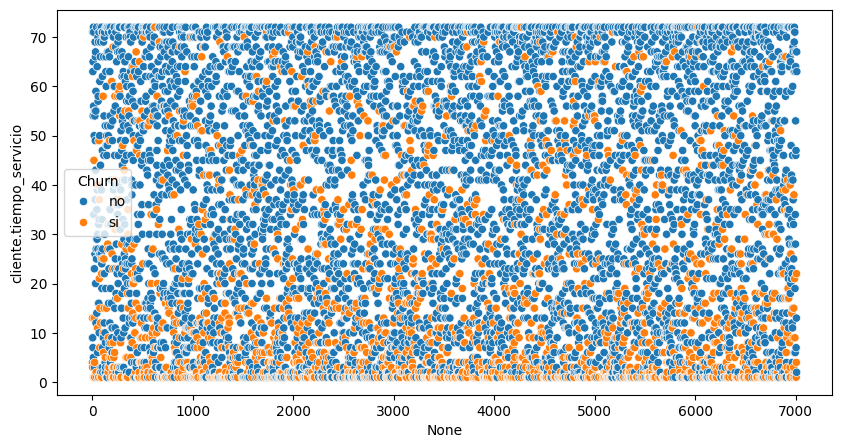

In [112]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=datos_churn, x=datos_churn.index, y='cliente.tiempo_servicio', hue='Churn')

In [113]:
datos_churn_segmentado['cliente.tiempo_servicio'].unique()

array([ 9.,  4., 13.,  3., 71., 63.,  7., 65., 54., 72.,  5., 56., 34.,
        1., 45., 50., 23., 55., 26., 69., 37., 49., 66., 67., 20., 43.,
       59., 12., 27.,  2., 25., 29., 14., 35., 64., 39., 40., 11.,  6.,
       30., 70., 57., 58., 16., 32., 33., 10., 21., 61., 15., 44., 22.,
       24., 19., 47., 62., 46., 52.,  8., 60., 48., 28., 41., 53., 68.,
       31., 36., 17., 18., 51., 38., 42.])

* Tal como habiamos observado en las gráficas anteriores, notamos que el tiempo_servicio seguía un patrón en general con respecto al contrato.
* También podemos indicar que se generan aglomeraciones para tiempos de servicios bajos y muy altos, dando un desbalance en el dataset, por esta razón, decidimos segmentar por tiempo:

  > Menor de 6 meses == Demasiado Bajo == 1

  > Entre 6 y 18 meses == Bajo == 2

  > Entre 18 y 36 meses == Medio == 3

  > Entre 36 y 50 meses == Alto == 4

  > Entre 50 y 65 meses == Muy alto == 5
  
  > Mayor de 65 meses == Demasiado Alto == 6

In [114]:
## mapeando para la variable cliente.tiempo_servicio

# Crear los segmentos para tiempo de servicio
# bins = [0, 24, 48, float('inf')]  # Intervalos: <24, 24-48, >48
# labels = [1, 2, 3]  # 1 = Bajo, 2 = Medio, 3 = Alto

bins = [0, 6, 18, 36, 50, 65, float('inf')]
labels = [1, 2, 3, 4, 5, 6]

# Sobrescribir la columna 'cliente.tiempo_servicio' con los valores segmentados
datos_churn_segmentado['cliente.tiempo_servicio'] = pd.cut(datos_churn_segmentado['cliente.tiempo_servicio'], bins=bins, labels=labels, right=False)

# Verificar el resultado
datos_churn_segmentado.head(12)

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0     no      masculino                0             no                   no   
1     si      masculino                0             no                   no   
2     si      masculino                1             si                   no   
3     si       femenino                1             si                   no   
4     no       femenino                0             no                   si   
5     no       femenino                1             si                   no   
6     no      masculino                0             si                   no   
7     no       femenino                1             no                   no   
8     no       femenino                0             si                   si   
9     no      masculino                0             no                   no   
10    no       femenino                0             si                   si   
11    no       femenino                0             si                   no   

   cliente.tiempo_servicio telefono.servicio_telefono  \
0                        2                         si   
1                        1                         si   
2                        2                         si   
3                        1                         si   
4                        2                         si   
5                        6                         si   
6                        5                         si   
7                        2                         si   
8                        6                         si   
9                        5                         no   
10                       6                         si   
11                       1                         si   

      telefono.varias_lineas internet.servicio_internet  \
0                         si                        DSL   
1                         no               fibra optica   
2                         no               fibra optica   
3                         no               fibra optica   
4                         no                        DSL   
5                         no               fibra optica   
6                         si               fibra optica   
7                         no                        DSL   
8                         si                        DSL   
9   sin servicio de telefono                        DSL   
10                        si               fibra optica   
11                        no               fibra optica   

   internet.seguridad_online internet.backup_online  \
0                         no                     no   
1                         no                     no   
2                         no                     si   
3                         no                     no   
4                         no                     no   
5                         si                     si   
6                         si                     no   
7                         si                     no   
8                         si                     si   
9                         si                     no   
10                        si                     si   
11                        no                     no   

   internet.proteccion_dispositivo internet.soporte_tecnico  \
0                               no                       no   
1                               si                       no   
2                               si                       no   
3                               no                       si   
4                               no                       si   
5                               si                       si   
6                               no                       si   
7                               no                       no   
8                               si                       si   
9                               no                       si   
10                              si         

* Se observa buena variabilidad en nuestra segmentación, para evitar sesgo

>>> **cuenta.cobros.mensual**

In [115]:
datos_churn_segmentado['cuenta.cobros.mensual'].unique(), datos_churn_segmentado['cuenta.cobros.mensual'].min(), datos_churn_segmentado['cuenta.cobros.mensual'].max()

(array([59.9 , 73.9 , 98.  , ..., 91.75, 68.8 , 67.85]), 18.25, 118.75)

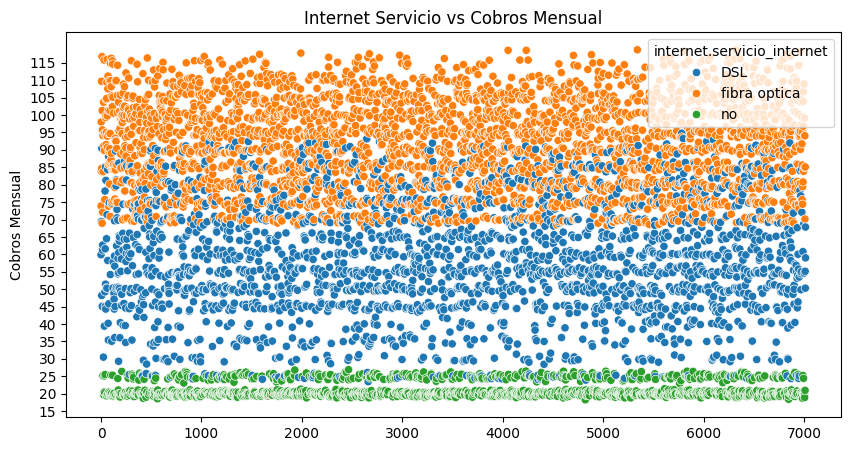

In [116]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=datos_churn_segmentado, x=datos_churn_segmentado.index, y='cuenta.cobros.mensual', hue ='internet.servicio_internet')
plt.title('Internet Servicio vs Cobros Mensual')
plt.xlabel('')
plt.ylabel('Cobros Mensual')
plt.yticks(np.arange(datos_churn_segmentado['cuenta.cobros.mensual'].min()-3.25, datos_churn_segmentado['cuenta.cobros.mensual'].max()+1.25, 5))
plt.show()

* Tal como observamos en la gráfica scatterplot, notamos que el cobros.mensual esta relacionado intimamente con el tipo de servicio proporcionado, por esta razón, decidimos segmentar en varios niveles:

  > Menor de 30 == 1

  > Entre 30 y 60 == 2

  > Entre 60 y 80 == 3

  > Entre 80 y 95 == 4
  
  > Mayor de 95 == Alto == 5

In [117]:
## mapeando para la variable cuenta.cobros.mensual

# Crear los segmentos para cuenta.cobros.mensual
# bins = [0, 30, 80, float('inf')]  # Intervalos: <30, 30-80, >80
# labels = [1, 2, 3]  # 1 = Bajo, 2 = Medio, 3 = Alto

bins = [0, 30, 60, 80, 95, float('inf')]
labels = [1, 2, 3, 4, 5]

# Sobrescribir la columna 'cuenta.cobros.mensual' con los valores segmentados
datos_churn_segmentado['cuenta.cobros.mensual'] = pd.cut(datos_churn_segmentado['cuenta.cobros.mensual'], bins=bins, labels=labels, right=False)

# Verificar el resultado
datos_churn_segmentado.head(10)

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   
5    no       femenino                1             si                   no   
6    no      masculino                0             si                   no   
7    no       femenino                1             no                   no   
8    no       femenino                0             si                   si   
9    no      masculino                0             no                   no   

  cliente.tiempo_servicio telefono.servicio_telefono  \
0                       2                         si   
1                       1                         si   
2                       2                         si   
3                       1                         si   
4                       2                         si   
5                       6                         si   
6                       5                         si   
7                       2                         si   
8                       6                         si   
9                       5                         no   

     telefono.varias_lineas internet.servicio_internet  \
0                        si                        DSL   
1                        no               fibra optica   
2                        no               fibra optica   
3                        no               fibra optica   
4                        no                        DSL   
5                        no               fibra optica   
6                        si               fibra optica   
7                        no                        DSL   
8                        si                        DSL   
9  sin servicio de telefono                        DSL   

  internet.seguridad_online internet.backup_online  \
0                        no                     no   
1                        no                     no   
2                        no                     si   
3                        no                     no   
4                        no                     no   
5                        si                     si   
6                        si                     no   
7                        si                     no   
8                        si                     si   
9                        si                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   
5                              si                       si   
6                              no                       si   
7                              no                       no   
8                              si                       si   
9                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   
5                    si                           si        dos años   
6                    no                           no        dos años   
7                    n

* Observamos buena variabilidad en nuestros datos

>>> **cuenta.cobros.Total**

* Sabemos que esta variable esta relacionada con el tiempo_servicio y cobros.mensual, asi que analizaremos por estos puntos.

In [118]:
datos_churn_segmentado['cuenta.cobros.Total'].unique(), datos_churn_segmentado['cuenta.cobros.Total'].min(), datos_churn_segmentado['cuenta.cobros.Total'].max()

(array([ 542.4 ,  280.85, 1237.85, ...,  742.9 , 4627.65, 3707.6 ]),
 18.8,
 8684.8)

In [119]:
# Creamos una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

# Graficamos el primer subplot
ax1.set_title('Cobro Total Segmentada por Tiempo de Servicio')
sns.scatterplot(x=datos_churn_segmentado.index, y='cuenta.cobros.Total', hue='cliente.tiempo_servicio', data=datos_churn_segmentado, ax=ax1)

# Graficamos el primer subplot
ax2.set_title('Cobro Total Segmentada por cobro mensual')
sns.scatterplot(x=datos_churn_segmentado.index, y='cuenta.cobros.Total', hue='cuenta.cobros.mensual', data=datos_churn_segmentado, ax=ax2)

# Personalizamos los ticks del eje y para el heatmap
ax1.set_yticks(np.arange(0, datos_churn_segmentado['cuenta.cobros.Total'].max(), 250))
ax2.set_yticks(np.arange(0, datos_churn_segmentado['cuenta.cobros.Total'].max(), 250))

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

* Tal como observamos en la gráfica doble de scatterplot, notamos que el cobros.Total esta relacionado intimamente con estas dos variables tiempo_servicio y cobros.mensual.
* También notamos que los valores tienden en su mayoria a montos bajos, es por eso que nuestra segmentación se dividirá de la forma en que se pueda reducir el sesgo y las proporciones de datos:

  > Menor de 1500 == Bajo == 1

  > Entre 1500 y 4500 == Medio == 2
  
  > Mayor de 4500 == Alto == 3

In [120]:
## mapeando para la variable cuenta.cobros.mensual

# Crear los segmentos para cuenta.cobros.mensual
# bins = [0, 1500, 4500, float('inf')]  # Intervalos: <1500, 1500-4500, >4500
# labels = [1, 2, 3]  # 1 = Bajo, 2 = Medio, 3 = Alto

bins = [0, 100, 300, 550, 1000, 2000, 3500, 5500, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]

# Sobrescribir la columna 'cuenta.cobros.mensual' con los valores segmentados
datos_churn_segmentado['cuenta.cobros.Total'] = pd.cut(datos_churn_segmentado['cuenta.cobros.Total'], bins=bins, labels=labels, right=False)

# Verificar el resultado
datos_churn_segmentado.head(10)

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   
5    no       femenino                1             si                   no   
6    no      masculino                0             si                   no   
7    no       femenino                1             no                   no   
8    no       femenino                0             si                   si   
9    no      masculino                0             no                   no   

  cliente.tiempo_servicio telefono.servicio_telefono  \
0                       2                         si   
1                       1                         si   
2                       2                         si   
3                       1                         si   
4                       2                         si   
5                       6                         si   
6                       5                         si   
7                       2                         si   
8                       6                         si   
9                       5                         no   

     telefono.varias_lineas internet.servicio_internet  \
0                        si                        DSL   
1                        no               fibra optica   
2                        no               fibra optica   
3                        no               fibra optica   
4                        no                        DSL   
5                        no               fibra optica   
6                        si               fibra optica   
7                        no                        DSL   
8                        si                        DSL   
9  sin servicio de telefono                        DSL   

  internet.seguridad_online internet.backup_online  \
0                        no                     no   
1                        no                     no   
2                        no                     si   
3                        no                     no   
4                        no                     no   
5                        si                     si   
6                        si                     no   
7                        si                     no   
8                        si                     si   
9                        si                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   
5                              si                       si   
6                              no                       si   
7                              no                       no   
8                              si                       si   
9                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   
5                    si                           si        dos años   
6                    no                           no        dos años   
7                    n

* Con esto temrinamos de segmentar los valores continuos de nuestro dataframe. COnsideramos que de esta manera podemos incorporarlo a nuestro modelo de machine learning y obtener mejores resultados.

In [121]:
## Transformando las variables binarias en 0 y 1
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for col in variables_categoricas_binarias:
    datos_churn_segmentado[col] = label_encoder.fit_transform(datos_churn_segmentado[col])

In [122]:
datos_churn_segmentado[variables_categoricas_binarias].head(8)

Churn  cliente.genero  cliente.pareja  cliente.dependientes  \
0      0               1               0                     0   
1      1               1               0                     0   
2      1               1               1                     0   
3      1               0               1                     0   
4      0               0               0                     1   
5      0               0               1                     0   
6      0               1               1                     0   
7      0               0               0                     0   

   telefono.servicio_telefono  cuenta.facturacion_electronica  
0                           1                               0  
1                           1                               1  
2                           1                               1  
3                           1                               1  
4                           1                               1  
5                           1                               1  
6                           1                               1  
7                           1                               1

In [123]:
## Aplicando one-hot-encoding a las demás variables categóricas múltiples
datos_churn_segmentado = pd.get_dummies(datos_churn_segmentado, columns=variables_categoricas_multiples, drop_first=True)

In [124]:
datos_churn_segmentado.replace(True, 1, inplace=True)
datos_churn_segmentado.replace(False, 0, inplace=True)

In [125]:
datos_churn_segmentado.head(8)

Churn  cliente.genero  cliente.anciano  cliente.pareja  \
0      0               1                0               0   
1      1               1                0               0   
2      1               1                1               1   
3      1               0                1               1   
4      0               0                0               0   
5      0               0                1               1   
6      0               1                0               1   
7      0               0                1               0   

   cliente.dependientes cliente.tiempo_servicio  telefono.servicio_telefono  \
0                     0                       2                           1   
1                     0                       1                           1   
2                     0                       2                           1   
3                     0                       1                           1   
4                     1                       2                           1   
5                     0                       6                           1   
6                     0                       5                           1   
7                     0                       2                           1   

   cuenta.facturacion_electronica cuenta.cobros.mensual cuenta.cobros.Total  \
0                               0                     2                   3   
1                               1                     3                   2   
2                               1                     5                   5   
3                               1                     4                   2   
4                               1                     3                   4   
5                               1                     5                   8   
6                               1                     4                   7   
7                               1                     2                   3   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   
5                          0                                                0   
6                          1                                                0   
7                          0                                                0   

   internet.servicio_internet_fibra optica  internet.servicio_internet_no  \
0                                        0                              0   
1                                        1                              0   
2                                        1                              0   
3                                        1                              0   
4                                        0                              0   
5                                        1                              0   
6                                        1                              0   
7                                        0                              0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   
5                             1   
6                             1   
7                             1   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4   

* Quedo listo para incorporarlo a nuestor modelo

###**2.3.3 Transformación Logarítmica y Exponencial Inversa para las variables continuas**

https://chatgpt.com/share/66f5dc64-cd94-800f-8e66-308335ec8391

In [126]:
datos_churn_log = datos_churn.copy()
datos_churn_log.head()

id_cliente Churn cliente.genero  cliente.anciano cliente.pareja  \
0  0003-MKNFE    no      masculino                0             no   
1  0004-TLHLJ    si      masculino                0             no   
2  0011-IGKFF    si      masculino                1             si   
3  0013-EXCHZ    si       femenino                1             si   
4  0013-MHZWF    no       femenino                0             no   

  cliente.dependientes  cliente.tiempo_servicio telefono.servicio_telefono  \
0                   no                      9.0                         si   
1                   no                      4.0                         si   
2                   no                     13.0                         si   
3                   no                      3.0                         si   
4                   si                      9.0                         si   

  telefono.varias_lineas internet.servicio_internet internet.seguridad_online  \
0                     si                        DSL                        no   
1                     no               fibra optica                        no   
2                     no               fibra optica                        no   
3                     no               fibra optica                        no   
4                     no                        DSL                        no   

  internet.backup_online internet.proteccion_dispositivo  \
0                     no                              no   
1                     no                              si   
2                     si                              si   
3                     no                              no   
4                     no                              no   

  internet.soporte_tecnico internet.tv_streaming internet.peliculas_streaming  \
0                       no                    no                           si   
1                       no                    no                           no   
2                       no                    si                           si   
3                       si                    si                           no   
4                       si                    si                           si   

  cuenta.contrato cuenta.facturacion_electronica  \
0         mensual                             no   
1         mensual                             si   
2         mensual                             si   
3         mensual                             si   
4         mensual                             si   

                cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
0                           cheque                   59.9               542.40  
1               cheque electronico                   73.9               280.85  
2               cheque electronico                   98.0              1237.85  
3                           cheque                   83.9               267.40  
4  tarjeta de credito (automatico)                   69.4               571.45

In [127]:
datos_churn_log.drop('id_cliente', axis=1, inplace=True)
datos_churn_log.head()

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   

   cliente.tiempo_servicio telefono.servicio_telefono telefono.varias_lineas  \
0                      9.0                         si                     si   
1                      4.0                         si                     no   
2                     13.0                         si                     no   
3                      3.0                         si                     no   
4                      9.0                         si                     no   

  internet.servicio_internet internet.seguridad_online internet.backup_online  \
0                        DSL                        no                     no   
1               fibra optica                        no                     no   
2               fibra optica                        no                     si   
3               fibra optica                        no                     no   
4                        DSL                        no                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   

  cuenta.facturacion_electronica               cuenta.metodo_pago  \
0                             no                           cheque   
1                             si               cheque electronico   
2                             si               cheque electronico   
3                             si                           cheque   
4                             si  tarjeta de credito (automatico)   

   cuenta.cobros.mensual  cuenta.cobros.Total  
0                   59.9               542.40  
1                   73.9               280.85  
2                   98.0              1237.85  
3                   83.9               267.40  
4                   69.4               571.45

**VARIABLES CONTÍNUAS**

* Ahora analizaremos el sesgo que puede estar presente en nuestras variables contínuas:  **cliente.tiempo_servicio, cuenta.cobros.mensual y cuenta.cobros.Total**

verificar el sesgo de las variables continuas es importante antes de aplicar cualquier transformación, y también es clave saber si el sesgo es hacia la derecha o la izquierda, ya que eso determinará qué tipo de transformación podría ser más efectiva.

* Tipos de Sesgo:

 > Sesgo hacia la derecha (Right Skewed): La mayoría de los valores están concentrados en el extremo izquierdo, con una "cola" extendiéndose hacia la derecha. Esto indica que tienes muchos valores pequeños y algunos grandes. La transformación logarítmica es útil en este caso.

 > Sesgo hacia la izquierda (Left Skewed): La mayoría de los valores están en el extremo derecho, con una "cola" extendiéndose hacia la izquierda. En este caso, una transformación como la exponencial inversa o elevar a una potencia menor que 1 puede ser más apropiada.

* Cómo verificar el sesgo:
Puedes usar histogramas y la métrica de asimetría (skewness) para medir si las distribuciones están sesgadas y hacia qué lado. El valor de la asimetría indica lo siguiente:

 > Asimetría positiva (>0): Sesgo hacia la derecha.

 > Asimetría negativa (<0): Sesgo hacia la izquierda.

 > Cercano a 0: Distribución aproximadamente simétrica.

In [128]:
from scipy.stats import skew

# Seleccionar las columnas que contienen variables continuas
variables_continuas = ['cliente.tiempo_servicio', 'cuenta.cobros.mensual' , 'cuenta.cobros.Total']

# Calcular el sesgo (asimetría)
skewness = datos_churn_log[variables_continuas].apply(lambda x: skew(x))

# Mostrar el sesgo
print(skewness)

cliente.tiempo_servicio    0.239308
cuenta.cobros.mensual     -0.220211
cuenta.cobros.Total        0.965633
dtype: float64


* Observamos que, **cliente.tiempo_servicio y cuenta.cobros.Total** tienen sesgo hacia la derecha por lo cuál sería recomendable aplicar transformación logarítimica. Por otro lado **cuenta.cobros.mensual** tiene sesgo hacia la izquierda, en este caso aplicaríamos exponencial inversa.

* También es importante analizar los histogramas, que nos podrán mostrar la tendencia de los datos en estas variables, y corroborar nuestra información.

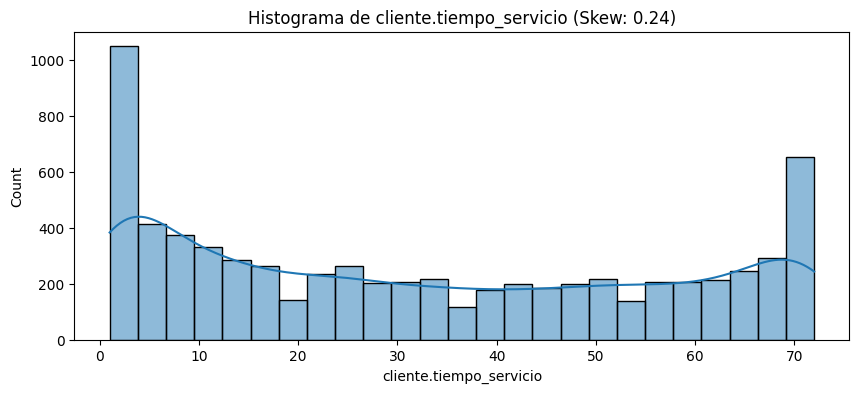

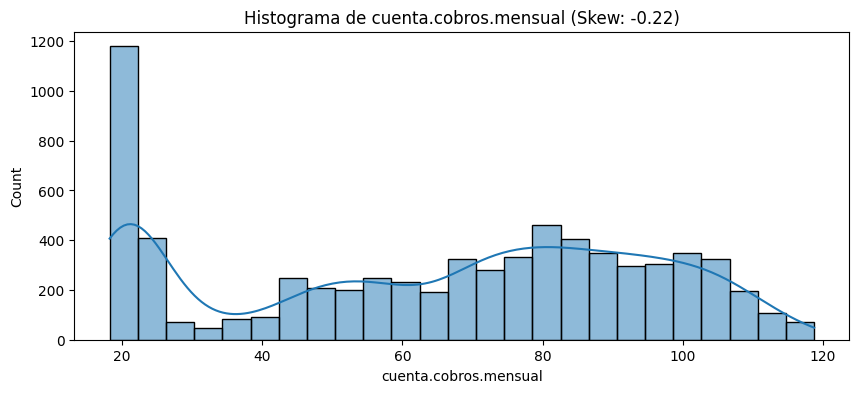

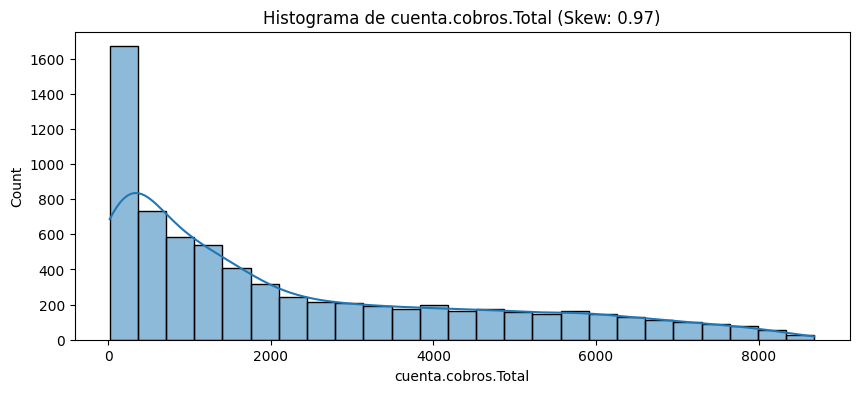

In [129]:
# Graficando  histogramas para ver la distribución de las variables contínuas
for var in variables_continuas:
    plt.figure(figsize=(10, 4))
    sns.histplot(datos_churn_log[var], bins=25, kde=True)
    plt.title(f'Histograma de {var} (Skew: {skew(datos_churn_log[var]):.2f})')
    plt.show()

* Observamos que la cobros.Total es la que tiene mayor tendencia hacia la derecha. Sesgo de tener mucha data concentrada en esos valores.
* Las otras dos variables tienen un sesgo moderado, tanto para la derecha como para la izquierda.
* Se procederá a aplicar la transformación logarítmica y exponencial inversa de acuerdo sea el caso.
* Luego se observará nuevamente el gráfico a ver como mejora

OBS:

* np.log1p(): Aplica logaritmo natural (base e) a 1 + x, lo cual es útil si hay valores cercanos a cero (log(0) es indefinido).

> Sesgo hacia la derecha: La transformación logarítmica es más efectiva.

> Sesgo hacia la izquierda: Prueba la raíz cuadrada o cúbica (inversas exponenciales) para reducir el sesgo negativo.

In [130]:
# Aplicar la transformación logarítmica
# Usamos log1p para evitar problemas con valores 0 o cercanos a 0.
datos_churn_log['cliente.tiempo_servicio'] = np.log1p(datos_churn_log['cliente.tiempo_servicio'])
datos_churn_log['cuenta.cobros.Total'] = np.log1p(datos_churn_log['cuenta.cobros.Total'])

# Aplicar la transformación exponencial inversa
# Invertimos los valores, luego aplicamos la transformación exponencial
datos_churn_log['cuenta.cobros.mensual'] = np.power(datos_churn_log['cuenta.cobros.mensual'], 0.5)  # Elevar a 0.5 (raíz cuadrada) reduce el sesgo negativo

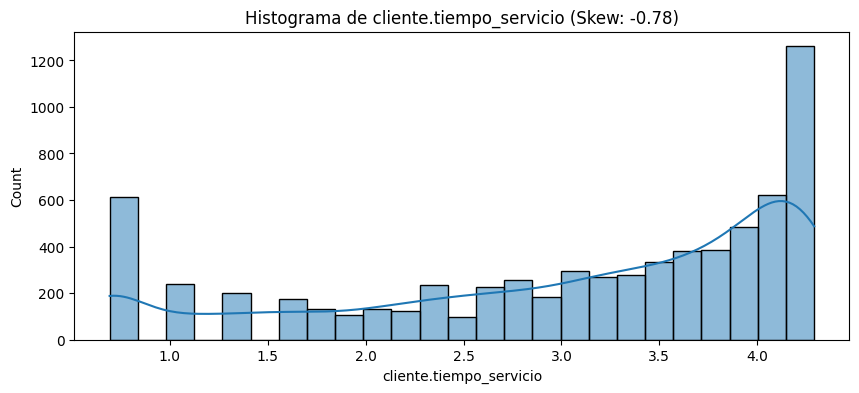

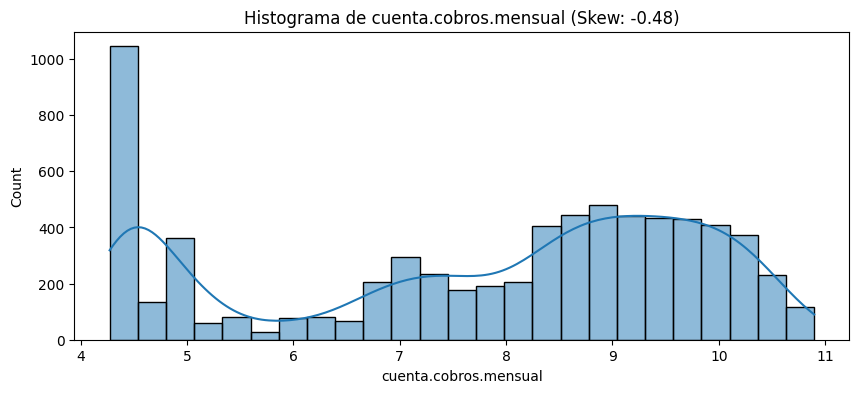

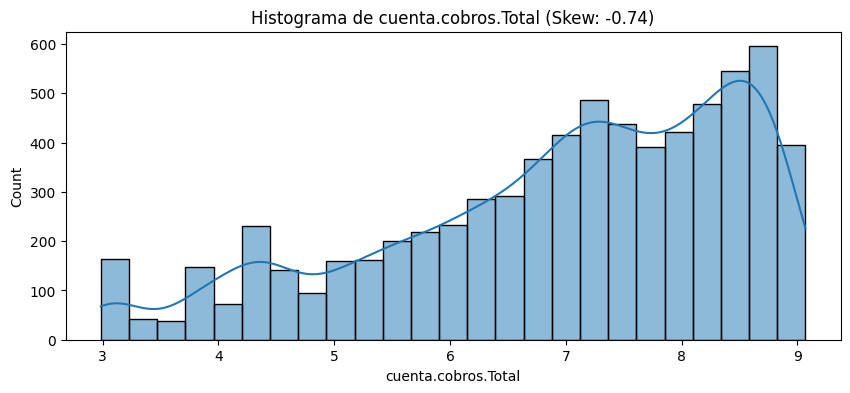

In [131]:
# Graficando  histogramas para ver la distribución de las variables contínuas después de las Transformaciones
for i in variables_continuas:
    plt.figure(figsize=(10, 4))
    sns.histplot(datos_churn_log[i], bins=25, kde=True)
    plt.title(f'Histograma de {i} (Skew: {skew(datos_churn_log[i]):.2f})')
    plt.show()

* Observamos que no mejoró nuestra distribución, de todas maneras lo incorporaremos al modelo para observar como se comporta, porque se bajo la escala de todas maneras.

In [132]:
## Transformando las variables binarias en 0 y 1
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for col in variables_categoricas_binarias:
    datos_churn_log[col] = label_encoder.fit_transform(datos_churn_log[col])

datos_churn_log[variables_categoricas_binarias].head(8)

Churn  cliente.genero  cliente.pareja  cliente.dependientes  \
0      0               1               0                     0   
1      1               1               0                     0   
2      1               1               1                     0   
3      1               0               1                     0   
4      0               0               0                     1   
5      0               0               1                     0   
6      0               1               1                     0   
7      0               0               0                     0   

   telefono.servicio_telefono  cuenta.facturacion_electronica  
0                           1                               0  
1                           1                               1  
2                           1                               1  
3                           1                               1  
4                           1                               1  
5                           1                               1  
6                           1                               1  
7                           1                               1

In [133]:
## Aplicando one-hot-encoding a las demás variables categóricas múltiples
datos_churn_log = pd.get_dummies(datos_churn_log, columns=variables_categoricas_multiples, drop_first=True)

datos_churn_log.replace(True, 1, inplace=True)
datos_churn_log.replace(False, 0, inplace=True)

datos_churn_log.head(8)

Churn  cliente.genero  cliente.anciano  cliente.pareja  \
0      0               1                0               0   
1      1               1                0               0   
2      1               1                1               1   
3      1               0                1               1   
4      0               0                0               0   
5      0               0                1               1   
6      0               1                0               1   
7      0               0                1               0   

   cliente.dependientes  cliente.tiempo_servicio  telefono.servicio_telefono  \
0                     0                 2.302585                           1   
1                     0                 1.609438                           1   
2                     0                 2.639057                           1   
3                     0                 1.386294                           1   
4                     1                 2.302585                           1   
5                     0                 4.276666                           1   
6                     0                 4.158883                           1   
7                     0                 2.079442                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0               7.739509             6.297846   
1                               1               8.596511             5.641375   
2                               1               9.899495             7.121939   
3                               1               9.159694             5.592478   
4                               1               8.330666             6.349925   
5                               1              10.473777             8.975282   
6                               1               9.200543             8.590221   
7                               1               6.942622             5.832908   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   
5                          0                                                0   
6                          1                                                0   
7                          0                                                0   

   internet.servicio_internet_fibra optica  internet.servicio_internet_no  \
0                                        0                              0   
1                                        1                              0   
2                                        1                              0   
3                                        1                              0   
4                                        0                              0   
5                                        1                              0   
6                                        1                              0   
7                                        0                              0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   
5                             1   
6                             1   
7                             1   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                 

###**2.3.4 Transformación Box-Cox para las variables continuas**

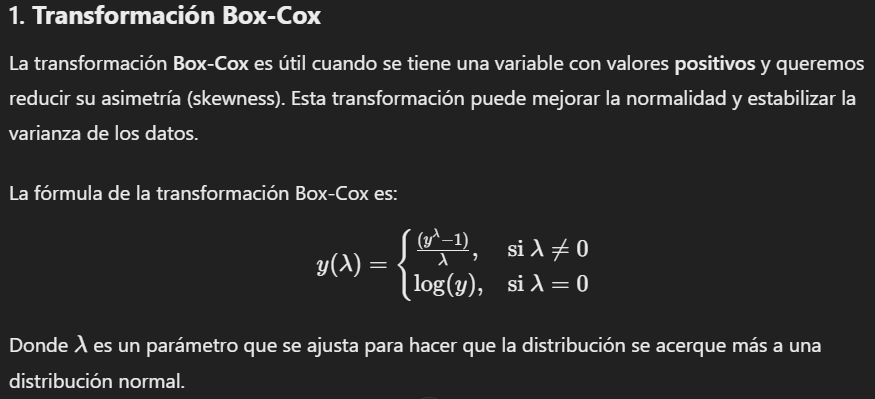

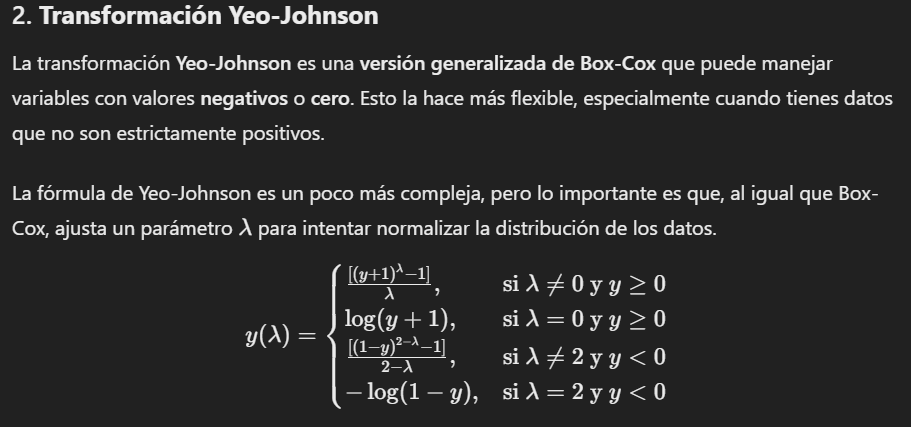

In [134]:
datos_churn_box = datos_churn.copy()
datos_churn_box.head()

id_cliente Churn cliente.genero  cliente.anciano cliente.pareja  \
0  0003-MKNFE    no      masculino                0             no   
1  0004-TLHLJ    si      masculino                0             no   
2  0011-IGKFF    si      masculino                1             si   
3  0013-EXCHZ    si       femenino                1             si   
4  0013-MHZWF    no       femenino                0             no   

  cliente.dependientes  cliente.tiempo_servicio telefono.servicio_telefono  \
0                   no                      9.0                         si   
1                   no                      4.0                         si   
2                   no                     13.0                         si   
3                   no                      3.0                         si   
4                   si                      9.0                         si   

  telefono.varias_lineas internet.servicio_internet internet.seguridad_online  \
0                     si                        DSL                        no   
1                     no               fibra optica                        no   
2                     no               fibra optica                        no   
3                     no               fibra optica                        no   
4                     no                        DSL                        no   

  internet.backup_online internet.proteccion_dispositivo  \
0                     no                              no   
1                     no                              si   
2                     si                              si   
3                     no                              no   
4                     no                              no   

  internet.soporte_tecnico internet.tv_streaming internet.peliculas_streaming  \
0                       no                    no                           si   
1                       no                    no                           no   
2                       no                    si                           si   
3                       si                    si                           no   
4                       si                    si                           si   

  cuenta.contrato cuenta.facturacion_electronica  \
0         mensual                             no   
1         mensual                             si   
2         mensual                             si   
3         mensual                             si   
4         mensual                             si   

                cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
0                           cheque                   59.9               542.40  
1               cheque electronico                   73.9               280.85  
2               cheque electronico                   98.0              1237.85  
3                           cheque                   83.9               267.40  
4  tarjeta de credito (automatico)                   69.4               571.45

In [135]:
datos_churn_box.drop('id_cliente', axis=1, inplace=True)
datos_churn_box.head()

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   

   cliente.tiempo_servicio telefono.servicio_telefono telefono.varias_lineas  \
0                      9.0                         si                     si   
1                      4.0                         si                     no   
2                     13.0                         si                     no   
3                      3.0                         si                     no   
4                      9.0                         si                     no   

  internet.servicio_internet internet.seguridad_online internet.backup_online  \
0                        DSL                        no                     no   
1               fibra optica                        no                     no   
2               fibra optica                        no                     si   
3               fibra optica                        no                     no   
4                        DSL                        no                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   

  cuenta.facturacion_electronica               cuenta.metodo_pago  \
0                             no                           cheque   
1                             si               cheque electronico   
2                             si               cheque electronico   
3                             si                           cheque   
4                             si  tarjeta de credito (automatico)   

   cuenta.cobros.mensual  cuenta.cobros.Total  
0                   59.9               542.40  
1                   73.9               280.85  
2                   98.0              1237.85  
3                   83.9               267.40  
4                   69.4               571.45

**VARIABLES CONTÍNUAS**

* Ahora aplicaremos la transformación Box-Cox para reducir el sesgo presente en nuestras variables continúas:  **cliente.tiempo_servicio, cuenta.cobros.mensual y cuenta.cobros.Total**
* De esta manera también reducimos su dimensionalidad presente por el amplio rango que se maneja.

In [136]:
from scipy import stats

# Aplicar la transformación Box-Cox
variables_continuas = ['cliente.tiempo_servicio', 'cuenta.cobros.mensual', 'cuenta.cobros.Total']
for col in variables_continuas:
    # # Asegú de que no haya valores negativos, ya que Box-Cox requiere datos positivos
    # if (df[col] <= 0).any():
    #     raise ValueError(f"La columna {col} contiene valores cero o negativos. Box-Cox no puede aplicarse.")
    datos_churn_box[col], lambda_param = stats.boxcox(datos_churn_box[col])
    print(f"Transformación de {col} realizada con lambda = {lambda_param}")

Transformación de cliente.tiempo_servicio realizada con lambda = 0.4572353615331576
Transformación de cuenta.cobros.mensual realizada con lambda = 0.9186693800595223
Transformación de cuenta.cobros.Total realizada con lambda = 0.25418792223376596


In [137]:
datos_churn_box.head()

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   

   cliente.tiempo_servicio telefono.servicio_telefono telefono.varias_lineas  \
0                 3.785683                         si                     si   
1                 1.935278                         si                     no   
2                 4.879282                         si                     no   
3                 1.427182                         si                     no   
4                 3.785683                         si                     no   

  internet.servicio_internet internet.seguridad_online internet.backup_online  \
0                        DSL                        no                     no   
1               fibra optica                        no                     no   
2               fibra optica                        no                     si   
3               fibra optica                        no                     no   
4                        DSL                        no                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   

  cuenta.facturacion_electronica               cuenta.metodo_pago  \
0                             no                           cheque   
1                             si               cheque electronico   
2                             si               cheque electronico   
3                             si                           cheque   
4                             si  tarjeta de credito (automatico)   

   cuenta.cobros.mensual  cuenta.cobros.Total  
0              45.653584            15.558788  
1              55.601564            12.555791  
2              72.383016            20.107535  
3              62.611841            12.351369  
4              52.422254            15.819021

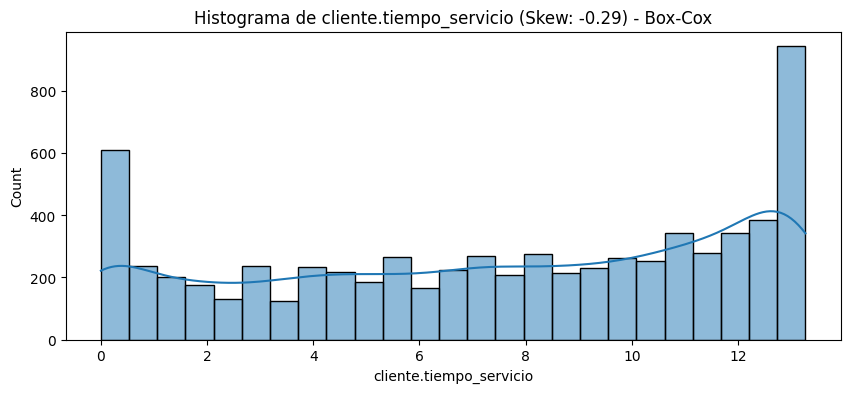

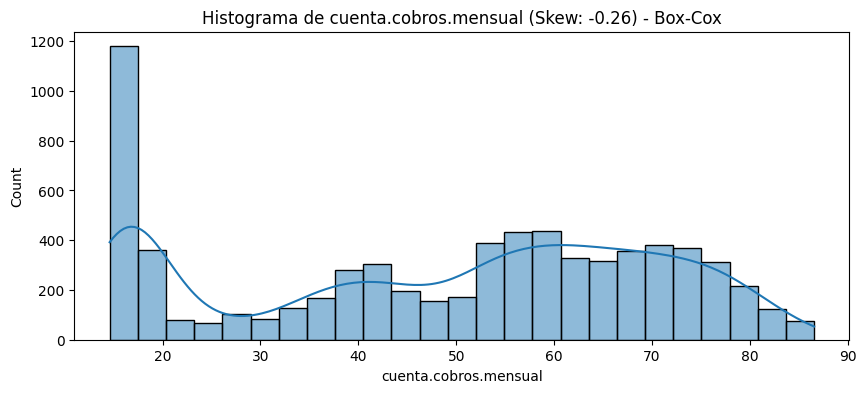

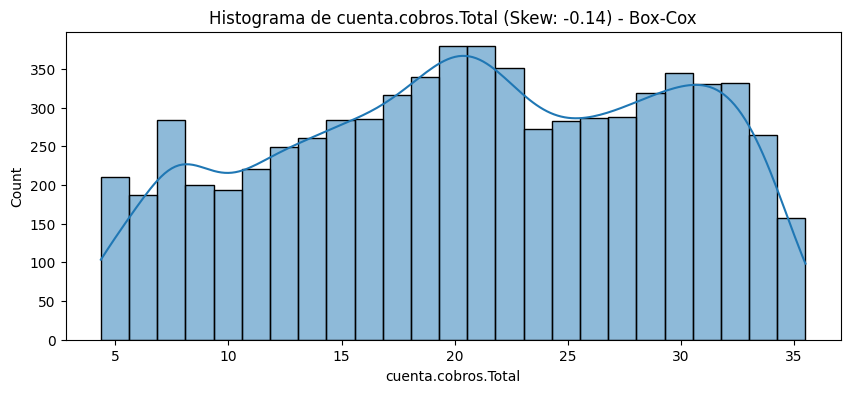

In [138]:
# Graficando  histogramas para ver la distribución de las variables contínuas después de las Transformaciones
for i in variables_continuas:
    plt.figure(figsize=(10, 4))
    sns.histplot(datos_churn_box[i], bins=25, kde=True)
    plt.title(f'Histograma de {i} (Skew: {skew(datos_churn_box[i]):.2f}) - Box-Cox')
    plt.show()

* Observamos que ayudo a bajar la dimensionalidad de los valores, reducción de rangos.
* La variable cobros.Total fue beneficiada con la transformación, se redujo el sesgo.

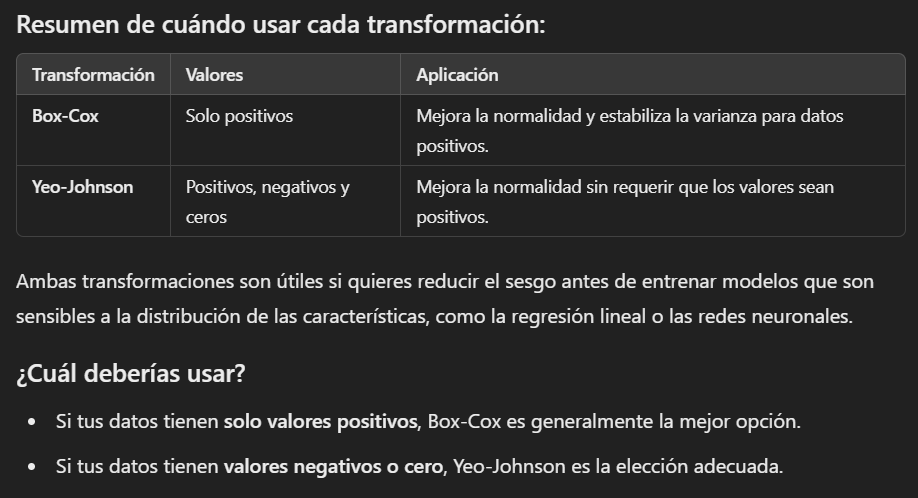

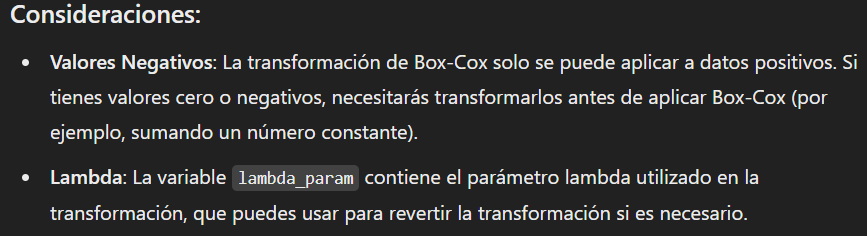

In [139]:
## Transformando las variables binarias en 0 y 1
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for col in variables_categoricas_binarias:
    datos_churn_box[col] = label_encoder.fit_transform(datos_churn_box[col])

datos_churn_box[variables_categoricas_binarias].head(8)

Churn  cliente.genero  cliente.pareja  cliente.dependientes  \
0      0               1               0                     0   
1      1               1               0                     0   
2      1               1               1                     0   
3      1               0               1                     0   
4      0               0               0                     1   
5      0               0               1                     0   
6      0               1               1                     0   
7      0               0               0                     0   

   telefono.servicio_telefono  cuenta.facturacion_electronica  
0                           1                               0  
1                           1                               1  
2                           1                               1  
3                           1                               1  
4                           1                               1  
5                           1                               1  
6                           1                               1  
7                           1                               1

In [140]:
## Aplicando one-hot-encoding a las demás variables categóricas múltiples
datos_churn_box = pd.get_dummies(datos_churn_box, columns=variables_categoricas_multiples, drop_first=True)

datos_churn_box.replace(True, 1, inplace=True)
datos_churn_box.replace(False, 0, inplace=True)

datos_churn_box.head(8)

Churn  cliente.genero  cliente.anciano  cliente.pareja  \
0      0               1                0               0   
1      1               1                0               0   
2      1               1                1               1   
3      1               0                1               1   
4      0               0                0               0   
5      0               0                1               1   
6      0               1                0               1   
7      0               0                1               0   

   cliente.dependientes  cliente.tiempo_servicio  telefono.servicio_telefono  \
0                     0                 3.785683                           1   
1                     0                 1.935278                           1   
2                     0                 4.879282                           1   
3                     0                 1.427182                           1   
4                     1                 3.785683                           1   
5                     0                13.170458                           1   
6                     0                12.353542                           1   
7                     0                 3.137321                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0              45.653584            15.558788   
1                               1              55.601564            12.555791   
2                               1              72.383016            20.107535   
3                               1              62.611841            12.351369   
4                               1              52.422254            15.819021   
5                               1              80.403683            34.581283   
6                               1              63.134770            30.989561   
7                               1              37.194343            13.381203   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   
5                          0                                                0   
6                          1                                                0   
7                          0                                                0   

   internet.servicio_internet_fibra optica  internet.servicio_internet_no  \
0                                        0                              0   
1                                        1                              0   
2                                        1                              0   
3                                        1                              0   
4                                        0                              0   
5                                        1                              0   
6                                        1                              0   
7                                        0                              0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   
5                             1   
6                             1   
7                             1   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                 

###**2.3.5 Normalización de datos usando Transformación Box-Cox y eliminando variables - Análisis gráfico y Entendimiento del Negocio**

* En este apartado, analizaremos eliminar algunas variables que consideramos no relevantes y crear otras que puedan ser importantes, pero sin utilizar técnicas de selección de variables, importancia de variables o reducción de dimensionalidad.

* Nos guiaremos del diccionario del dataset, el cual nos puede dar algún indicio sobre que variables son más importantes y cuales se podrían descartar.

In [141]:
datos_churn_norm = datos_churn_box.copy()
datos_churn_norm.head()

Churn  cliente.genero  cliente.anciano  cliente.pareja  \
0      0               1                0               0   
1      1               1                0               0   
2      1               1                1               1   
3      1               0                1               1   
4      0               0                0               0   

   cliente.dependientes  cliente.tiempo_servicio  telefono.servicio_telefono  \
0                     0                 3.785683                           1   
1                     0                 1.935278                           1   
2                     0                 4.879282                           1   
3                     0                 1.427182                           1   
4                     1                 3.785683                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0              45.653584            15.558788   
1                               1              55.601564            12.555791   
2                               1              72.383016            20.107535   
3                               1              62.611841            12.351369   
4                               1              52.422254            15.819021   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.servicio_internet_fibra optica  internet.servicio_internet_no  \
0                                        0                              0   
1                                        1                              0   
2                                        1                              0   
3                                        1                              0   
4                                        0                              0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   internet.backup_online_si  internet.backup_online_sin servicio de internet  \
0                          0                                                0   
1                          0                                                0   
2                          1                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.proteccion_dispositivo_si  \
0                                   0   
1                                   1   
2                                   1   
3                                   0   
4                                   0   

   internet.proteccion_dispositivo_sin servicio de internet  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   internet.soporte_tecnico_si  \
0                

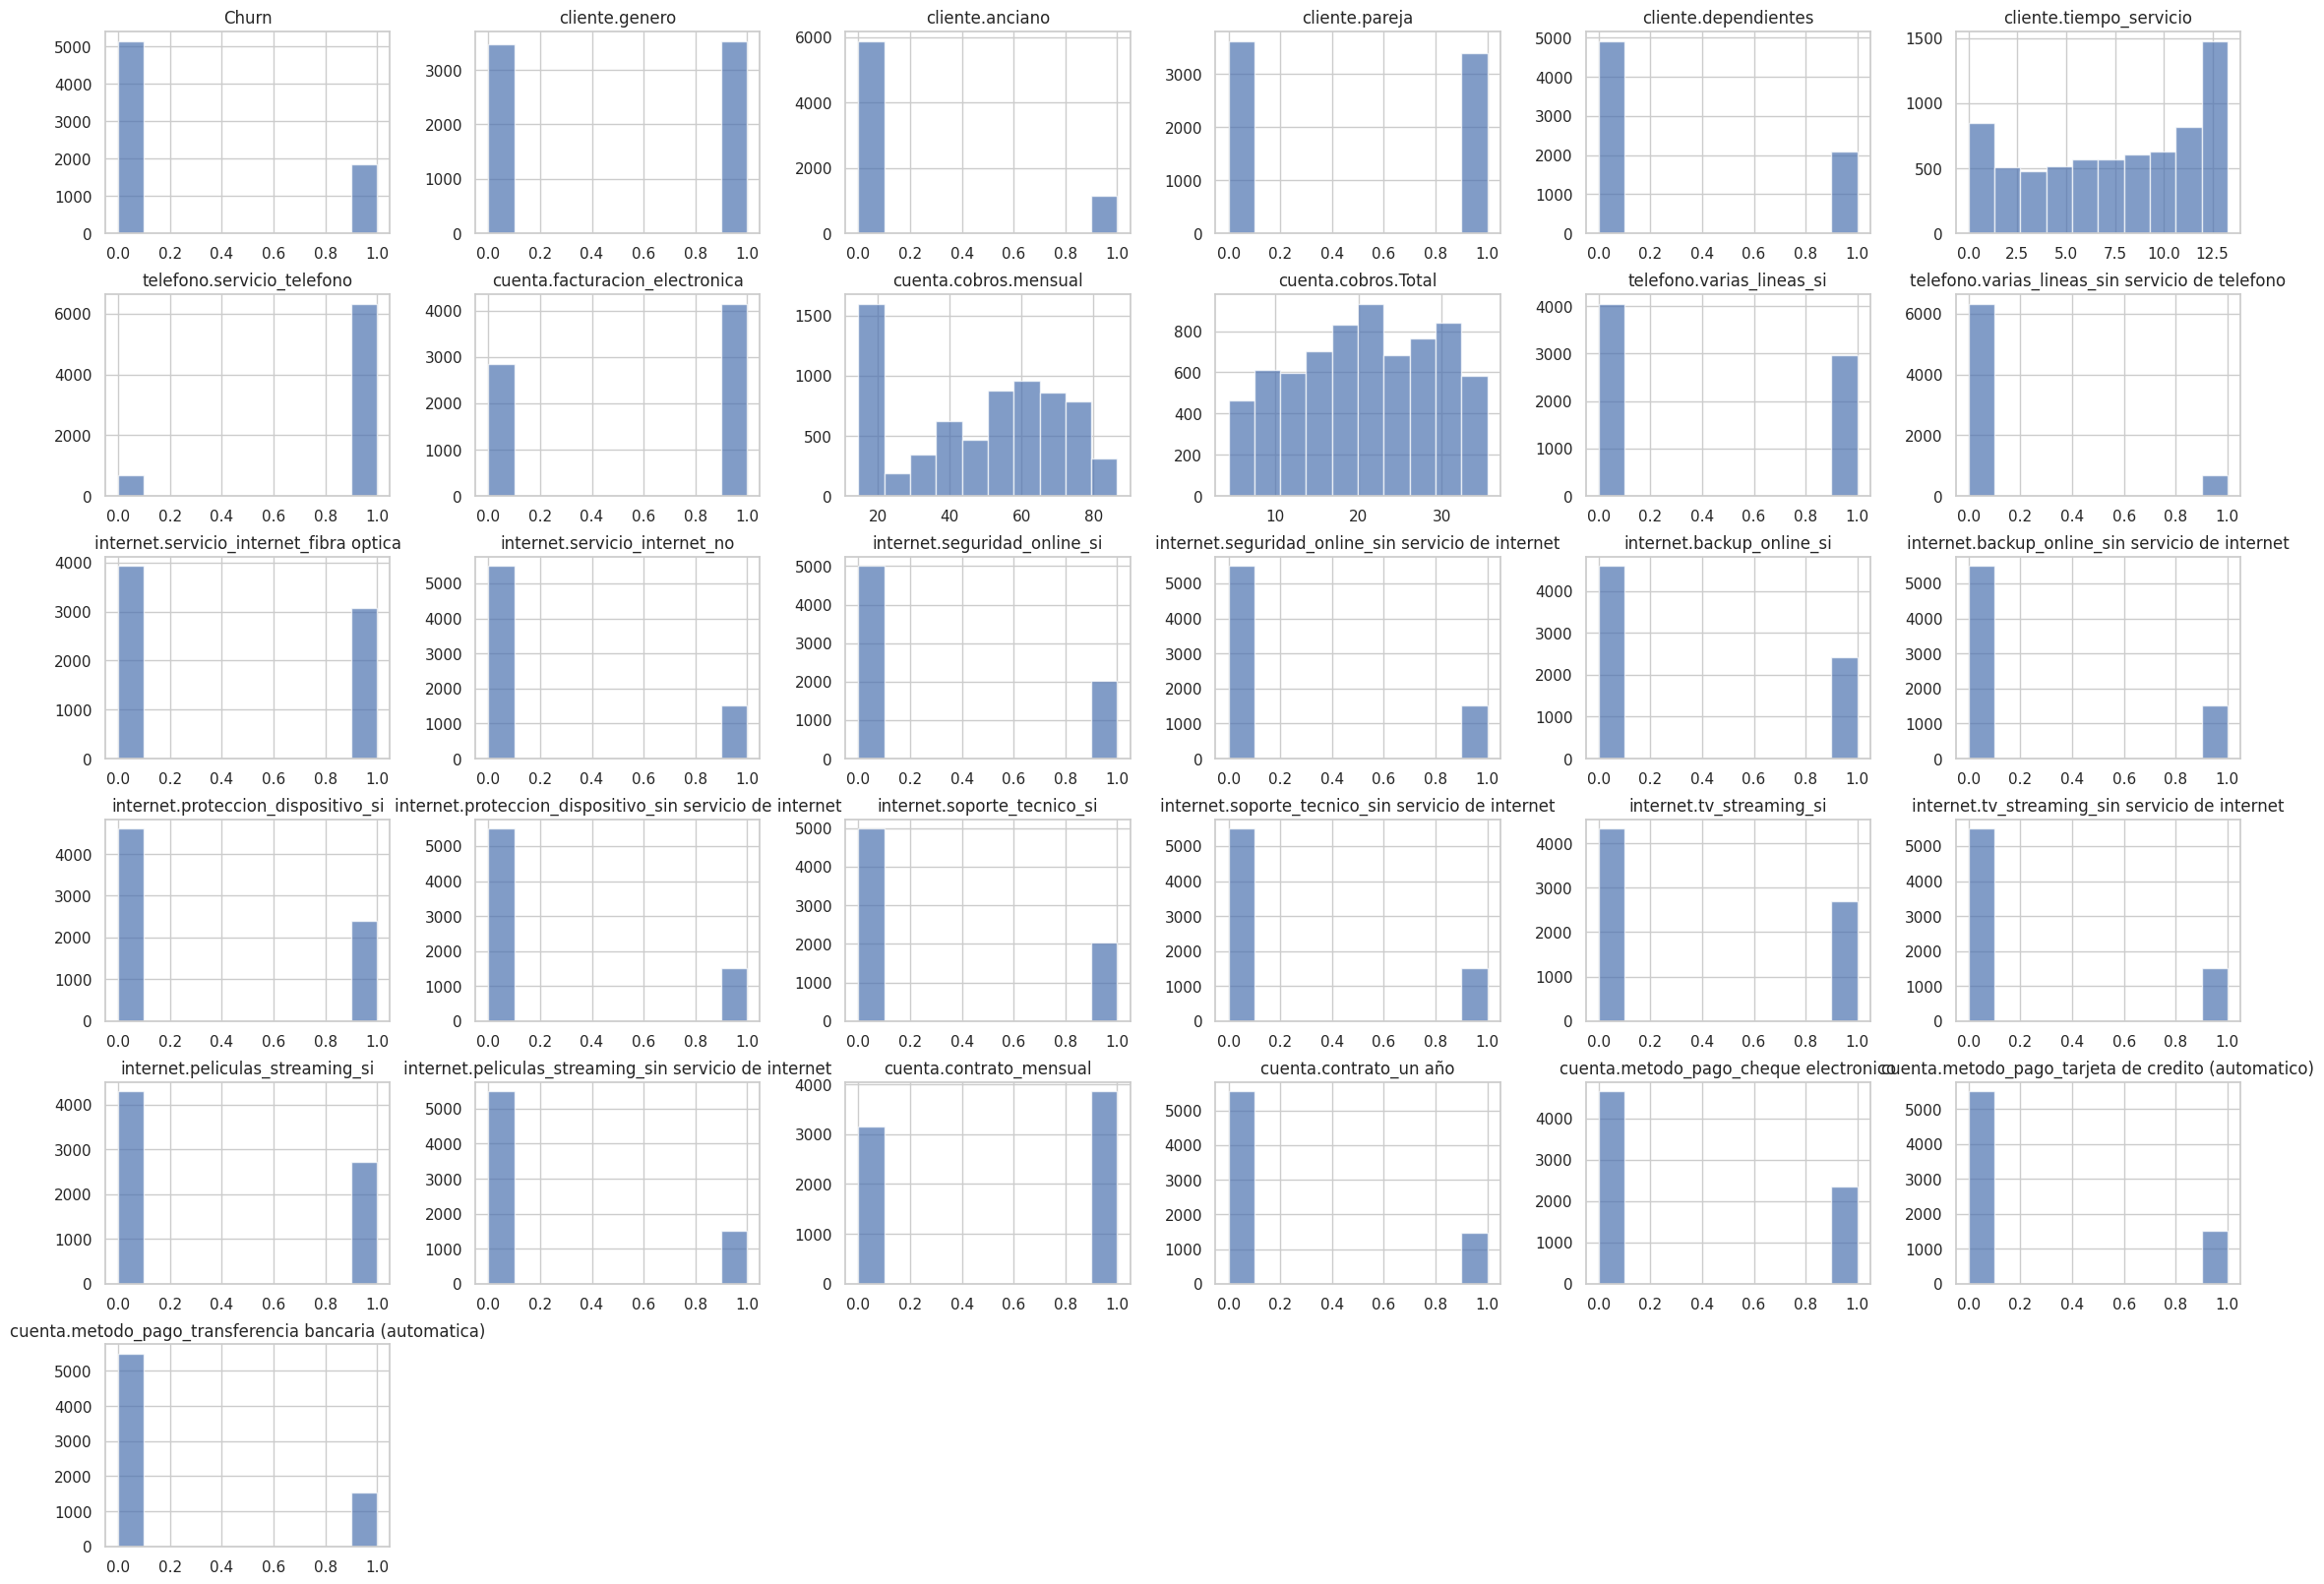

In [142]:
# Configuración de rcParams
# plt.rcParams['figure.figsize'] = (20, 15)   # Tamaño de la figura
plt.rcParams['axes.titlesize'] = 'large'    # Tamaño del título
plt.rcParams['axes.labelsize'] = 'medium'   # Tamaño de las etiquetas
plt.rcParams['xtick.labelsize'] = 'medium'   # Tamaño de las etiquetas del eje x
plt.rcParams['ytick.labelsize'] = 'medium'   # Tamaño de las etiquetas del eje y
plt.rcParams['legend.fontsize'] = 'medium'   # Tamaño de la leyenda
plt.rcParams['lines.linewidth'] = 2           # Ancho de línea
plt.rcParams['lines.color'] = 'blue'          # Color de las líneas

# Graficar un histograma de los datos transformados
# plt.hist(datos_churn_norm, bins=30, alpha=0.7, edgecolor='black')
# plt.title('Histograma de Valores Transformados por Box-Cox')
# plt.xlabel('Valores')
# plt.ylabel('Frecuencia')
# plt.grid(True)
# plt.show()

plt.rcParams['figure.figsize'] = [28,20];
sns.set(style="whitegrid")
datos_churn_norm.hist(alpha=0.7)
plt.show()

* Según el gráfico de histograma que realizamos para todas las variables, observamos que tenemos casi todas las variables binarias y 3 contínuas.
* Nos damos cuenta que en las variables contínuas se tiene información en todo el rango, por esta razon no podemos eliminarlas, aportan valor en todos sus niveles.
* Observamos que de las variables binarias, la mayoría siempre tiene una tendencia para un lado. Sin embargo observamos unas 3 variables que podemos considerar que no nos aportarian cierto valor al modelo, ya que si casi en su totalidad es de una clase, el modelo siempre tendería para esa clase, el sesgo sería grande. Estas variables, las cuales no podemos eliminar por que sí, son: **telefono.varias_lineas_sin servicio de telefono, servicio.servicio_telefono y cliente.anciano**
* De todas maneras, estas variables tenemos que cotejarlo con la variable objetivo, para ver si en realidad se puede eliminar. Por ejemplo, si tenemos que la clase minoritaria para esta variable tiene CHURN SI, no es recomendable eliminar, por que es lo que en sí queremos conseguir, perderíamos este valor de la variable.

In [143]:
%%capture
!pip install tabulate


Relación entre telefono.varias_lineas_sin servicio de telefono y churn:
+-------------------------------------------------+--------------------+---------------------+---------------------+
| telefono.varias_lineas_sin servicio de telefono |         0          |          1          |  Proporción Churn   |
+-------------------------------------------------+--------------------+---------------------+---------------------+
|                        0                        | 0.7328702241869277 | 0.2671297758130723  | 0.2671297758130723  |
|                        1                        | 0.7511045655375552 | 0.24889543446244478 | 0.24889543446244478 |
+-------------------------------------------------+--------------------+---------------------+---------------------+


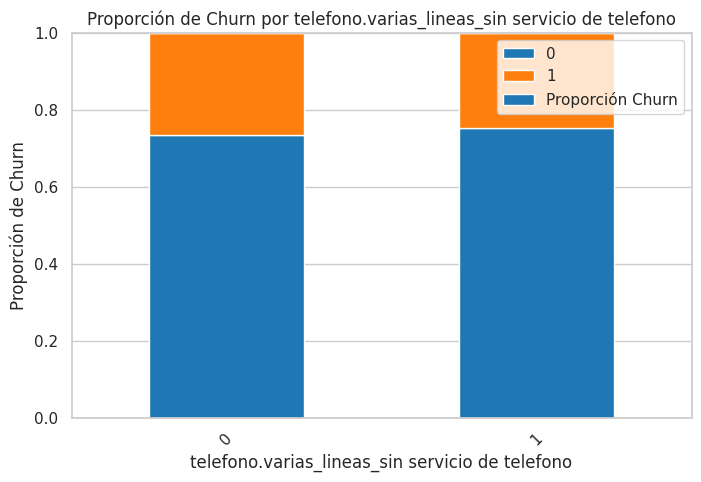


Relación entre telefono.servicio_telefono y churn:
+----------------------------+--------------------+---------------------+---------------------+
| telefono.servicio_telefono |         0          |          1          |  Proporción Churn   |
+----------------------------+--------------------+---------------------+---------------------+
|             0              | 0.7511045655375552 | 0.24889543446244478 | 0.24889543446244478 |
|             1              | 0.7328702241869277 | 0.2671297758130723  | 0.2671297758130723  |
+----------------------------+--------------------+---------------------+---------------------+


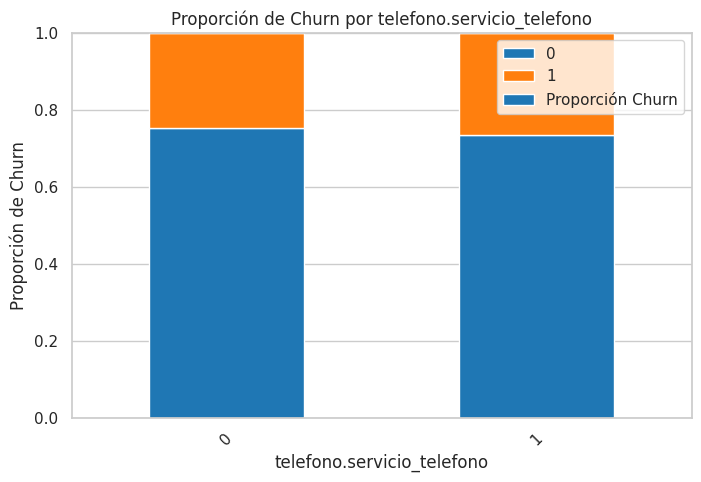


Relación entre cliente.anciano y churn:
+-----------------+--------------------+---------------------+---------------------+
| cliente.anciano |         0          |          1          |  Proporción Churn   |
+-----------------+--------------------+---------------------+---------------------+
|        0        | 0.7635250085062947 | 0.23647499149370535 | 0.23647499149370535 |
|        1        | 0.5850220264317181 | 0.4149779735682819  | 0.4149779735682819  |
+-----------------+--------------------+---------------------+---------------------+


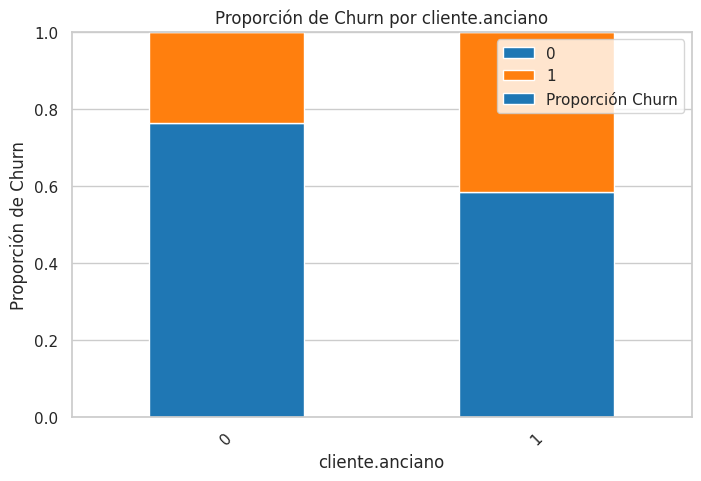

In [144]:
from tabulate import tabulate
## Analizando las variables posibles a eliminar, y 'churn' que indica si hay churn (1) o no (0)
variables_eliminar = ['telefono.varias_lineas_sin servicio de telefono', 'telefono.servicio_telefono', 'cliente.anciano']

# Analizar la relación de las variables con churn
for var in variables_eliminar:
    # Crear tabla de contingencia entre la variable y el churn
    tabla_contingencia = pd.crosstab(datos_churn_norm[var], datos_churn_norm['Churn'], normalize='index')

    # Calcular las proporciones de churn por cada categoría
    tabla_contingencia['Proporción Churn'] = tabla_contingencia[1] / (tabla_contingencia[0] + tabla_contingencia[1])

    # # Mostrar la tabla de resultados
    # print(f"\nRelación entre {var} y churn:")
    # print(tabla_contingencia)

    # Mostrar la tabla de resultados en formato tabulado
    print(f"\nRelación entre {var} y churn:")
    print(tabulate(tabla_contingencia, headers='keys', tablefmt='pretty'))

    # Graficar la proporción de churn
    # Graficar el stacked barplot
    tabla_contingencia.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], figsize=(8, 5))
    plt.title(f'Proporción de Churn por {var}')
    plt.xlabel(var)
    plt.ylabel('Proporción de Churn')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.ylim(0, 1)  # Limitar el eje y de 0 a 1
    plt.legend()
    plt.show()

* Según esto, notamos que la variable anciano es la que nos aporta más valor, ya que si el cliente es anciano, tiene más tendencia a salir con CHURN SI.
* Las otras dos variables, se mantienen en proporción de acuerdo a sus cantidades.

* La otra variable a analizar es cliente.genero, ya que vemos en el histograma que practicamente tienen la misma proporción, lo cual nos indicaría que tenemos datos de ambos géneros. Sin embargo, si analizamos su relación con churn obtenemos:

Text(0, 0.5, 'Número de Clientes')

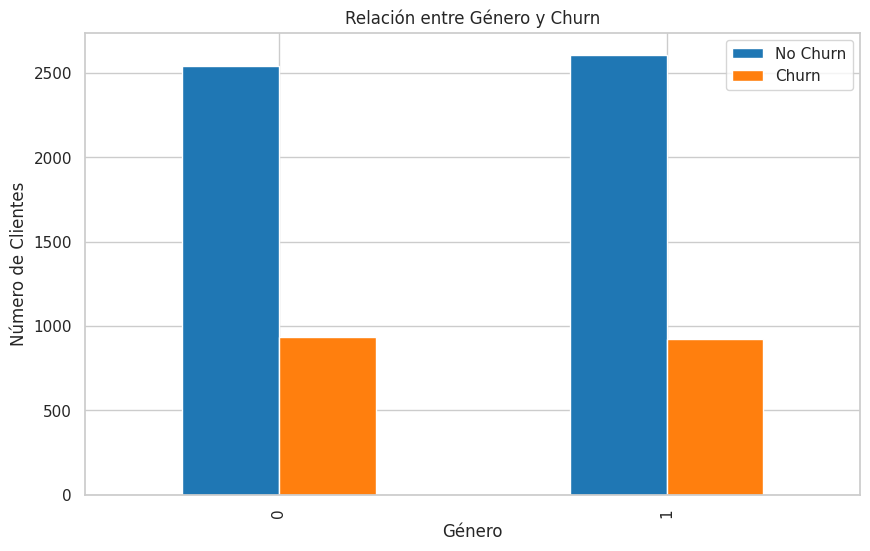

In [145]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm['cliente.genero'], datos_churn_norm['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre Género y Churn')
plt.xlabel('Género')
plt.ylabel('Número de Clientes')

* Vemos que tienen la misma proporción en todo, por ende consideramos no relevante, ya que para cualquier clase tiene la misma proporción de churn.

In [146]:
## Eliminado las variables que consideramos no aportaran valor al modelo
datos_churn_norm.drop(columns=['telefono.varias_lineas_sin servicio de telefono', 'telefono.servicio_telefono', 'cliente.genero'], inplace=True)
datos_churn_norm.head()

Churn  cliente.anciano  cliente.pareja  cliente.dependientes  \
0      0                0               0                     0   
1      1                0               0                     0   
2      1                1               1                     0   
3      1                1               1                     0   
4      0                0               0                     1   

   cliente.tiempo_servicio  cuenta.facturacion_electronica  \
0                 3.785683                               0   
1                 1.935278                               1   
2                 4.879282                               1   
3                 1.427182                               1   
4                 3.785683                               1   

   cuenta.cobros.mensual  cuenta.cobros.Total  telefono.varias_lineas_si  \
0              45.653584            15.558788                          1   
1              55.601564            12.555791                          0   
2              72.383016            20.107535                          0   
3              62.611841            12.351369                          0   
4              52.422254            15.819021                          0   

   internet.servicio_internet_fibra optica  internet.servicio_internet_no  \
0                                        0                              0   
1                                        1                              0   
2                                        1                              0   
3                                        1                              0   
4                                        0                              0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   internet.backup_online_si  internet.backup_online_sin servicio de internet  \
0                          0                                                0   
1                          0                                                0   
2                          1                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.proteccion_dispositivo_si  \
0                                   0   
1                                   1   
2                                   1   
3                                   0   
4                                   0   

   internet.proteccion_dispositivo_sin servicio de internet  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   internet.soporte_tecnico_si  \
0                            0   
1                            0   
2                            0   
3                            1   
4                            1   

   internet.soporte_tecnico_sin servicio de internet  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   internet.tv_streaming_si  internet.tv_streaming_sin servicio de internet  \
0                  

###**2.3.6 Normalización de datos usando Transformación Box-Cox, Feature engineering y eliminando variables - Análisis gráfico y Entendimiento del Negocio**

* En este apartado, analizaremos eliminar algunas variables que consideramos no relevantes y crear otras que puedan ser importantes, pero sin utilizar técnicas de selección de variables, importancia de variables o reducción de dimensionalidad.

* Nos guiaremos del diccionario del dataset, el cual nos puede dar algún indicio sobre que variables son más importantes y cuales se podrían descartar.

In [147]:
datos_churn_norm_2 = datos_churn.copy()
datos_churn_norm_2.head()

id_cliente Churn cliente.genero  cliente.anciano cliente.pareja  \
0  0003-MKNFE    no      masculino                0             no   
1  0004-TLHLJ    si      masculino                0             no   
2  0011-IGKFF    si      masculino                1             si   
3  0013-EXCHZ    si       femenino                1             si   
4  0013-MHZWF    no       femenino                0             no   

  cliente.dependientes  cliente.tiempo_servicio telefono.servicio_telefono  \
0                   no                      9.0                         si   
1                   no                      4.0                         si   
2                   no                     13.0                         si   
3                   no                      3.0                         si   
4                   si                      9.0                         si   

  telefono.varias_lineas internet.servicio_internet internet.seguridad_online  \
0                     si                        DSL                        no   
1                     no               fibra optica                        no   
2                     no               fibra optica                        no   
3                     no               fibra optica                        no   
4                     no                        DSL                        no   

  internet.backup_online internet.proteccion_dispositivo  \
0                     no                              no   
1                     no                              si   
2                     si                              si   
3                     no                              no   
4                     no                              no   

  internet.soporte_tecnico internet.tv_streaming internet.peliculas_streaming  \
0                       no                    no                           si   
1                       no                    no                           no   
2                       no                    si                           si   
3                       si                    si                           no   
4                       si                    si                           si   

  cuenta.contrato cuenta.facturacion_electronica  \
0         mensual                             no   
1         mensual                             si   
2         mensual                             si   
3         mensual                             si   
4         mensual                             si   

                cuenta.metodo_pago  cuenta.cobros.mensual  cuenta.cobros.Total  
0                           cheque                   59.9               542.40  
1               cheque electronico                   73.9               280.85  
2               cheque electronico                   98.0              1237.85  
3                           cheque                   83.9               267.40  
4  tarjeta de credito (automatico)                   69.4               571.45

In [148]:
datos_churn_norm_2.drop(columns='id_cliente', inplace=True)
datos_churn_norm_2.head()

Churn cliente.genero  cliente.anciano cliente.pareja cliente.dependientes  \
0    no      masculino                0             no                   no   
1    si      masculino                0             no                   no   
2    si      masculino                1             si                   no   
3    si       femenino                1             si                   no   
4    no       femenino                0             no                   si   

   cliente.tiempo_servicio telefono.servicio_telefono telefono.varias_lineas  \
0                      9.0                         si                     si   
1                      4.0                         si                     no   
2                     13.0                         si                     no   
3                      3.0                         si                     no   
4                      9.0                         si                     no   

  internet.servicio_internet internet.seguridad_online internet.backup_online  \
0                        DSL                        no                     no   
1               fibra optica                        no                     no   
2               fibra optica                        no                     si   
3               fibra optica                        no                     no   
4                        DSL                        no                     no   

  internet.proteccion_dispositivo internet.soporte_tecnico  \
0                              no                       no   
1                              si                       no   
2                              si                       no   
3                              no                       si   
4                              no                       si   

  internet.tv_streaming internet.peliculas_streaming cuenta.contrato  \
0                    no                           si         mensual   
1                    no                           no         mensual   
2                    si                           si         mensual   
3                    si                           no         mensual   
4                    si                           si         mensual   

  cuenta.facturacion_electronica               cuenta.metodo_pago  \
0                             no                           cheque   
1                             si               cheque electronico   
2                             si               cheque electronico   
3                             si                           cheque   
4                             si  tarjeta de credito (automatico)   

   cuenta.cobros.mensual  cuenta.cobros.Total  
0                   59.9               542.40  
1                   73.9               280.85  
2                   98.0              1237.85  
3                   83.9               267.40  
4                   69.4               571.45

In [149]:
## Transformando las variables binarias en 0 y 1
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for col in variables_categoricas_binarias:
    datos_churn_norm_2[col] = label_encoder.fit_transform(datos_churn_norm_2[col])

datos_churn_norm_2[variables_categoricas_binarias].head(8)

Churn  cliente.genero  cliente.pareja  cliente.dependientes  \
0      0               1               0                     0   
1      1               1               0                     0   
2      1               1               1                     0   
3      1               0               1                     0   
4      0               0               0                     1   
5      0               0               1                     0   
6      0               1               1                     0   
7      0               0               0                     0   

   telefono.servicio_telefono  cuenta.facturacion_electronica  
0                           1                               0  
1                           1                               1  
2                           1                               1  
3                           1                               1  
4                           1                               1  
5                           1                               1  
6                           1                               1  
7                           1                               1

In [150]:
## Aplicando one-hot-encoding a las demás variables categóricas múltiples
datos_churn_norm_2 = pd.get_dummies(datos_churn_norm_2, columns=variables_categoricas_multiples, drop_first=True)

datos_churn_norm_2.replace(True, 1, inplace=True)
datos_churn_norm_2.replace(False, 0, inplace=True)

datos_churn_norm_2.head(8)

Churn  cliente.genero  cliente.anciano  cliente.pareja  \
0      0               1                0               0   
1      1               1                0               0   
2      1               1                1               1   
3      1               0                1               1   
4      0               0                0               0   
5      0               0                1               1   
6      0               1                0               1   
7      0               0                1               0   

   cliente.dependientes  cliente.tiempo_servicio  telefono.servicio_telefono  \
0                     0                      9.0                           1   
1                     0                      4.0                           1   
2                     0                     13.0                           1   
3                     0                      3.0                           1   
4                     1                      9.0                           1   
5                     0                     71.0                           1   
6                     0                     63.0                           1   
7                     0                      7.0                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0                  59.90               542.40   
1                               1                  73.90               280.85   
2                               1                  98.00              1237.85   
3                               1                  83.90               267.40   
4                               1                  69.40               571.45   
5                               1                 109.70              7904.25   
6                               1                  84.65              5377.80   
7                               1                  48.20               340.35   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   
5                          0                                                0   
6                          1                                                0   
7                          0                                                0   

   internet.servicio_internet_fibra optica  internet.servicio_internet_no  \
0                                        0                              0   
1                                        1                              0   
2                                        1                              0   
3                                        1                              0   
4                                        0                              0   
5                                        1                              0   
6                                        1                              0   
7                                        0                              0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   
5                             1   
6                             1   
7                             1   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                 

* Graficando Histograma de todos los datos para ver alguna correlación

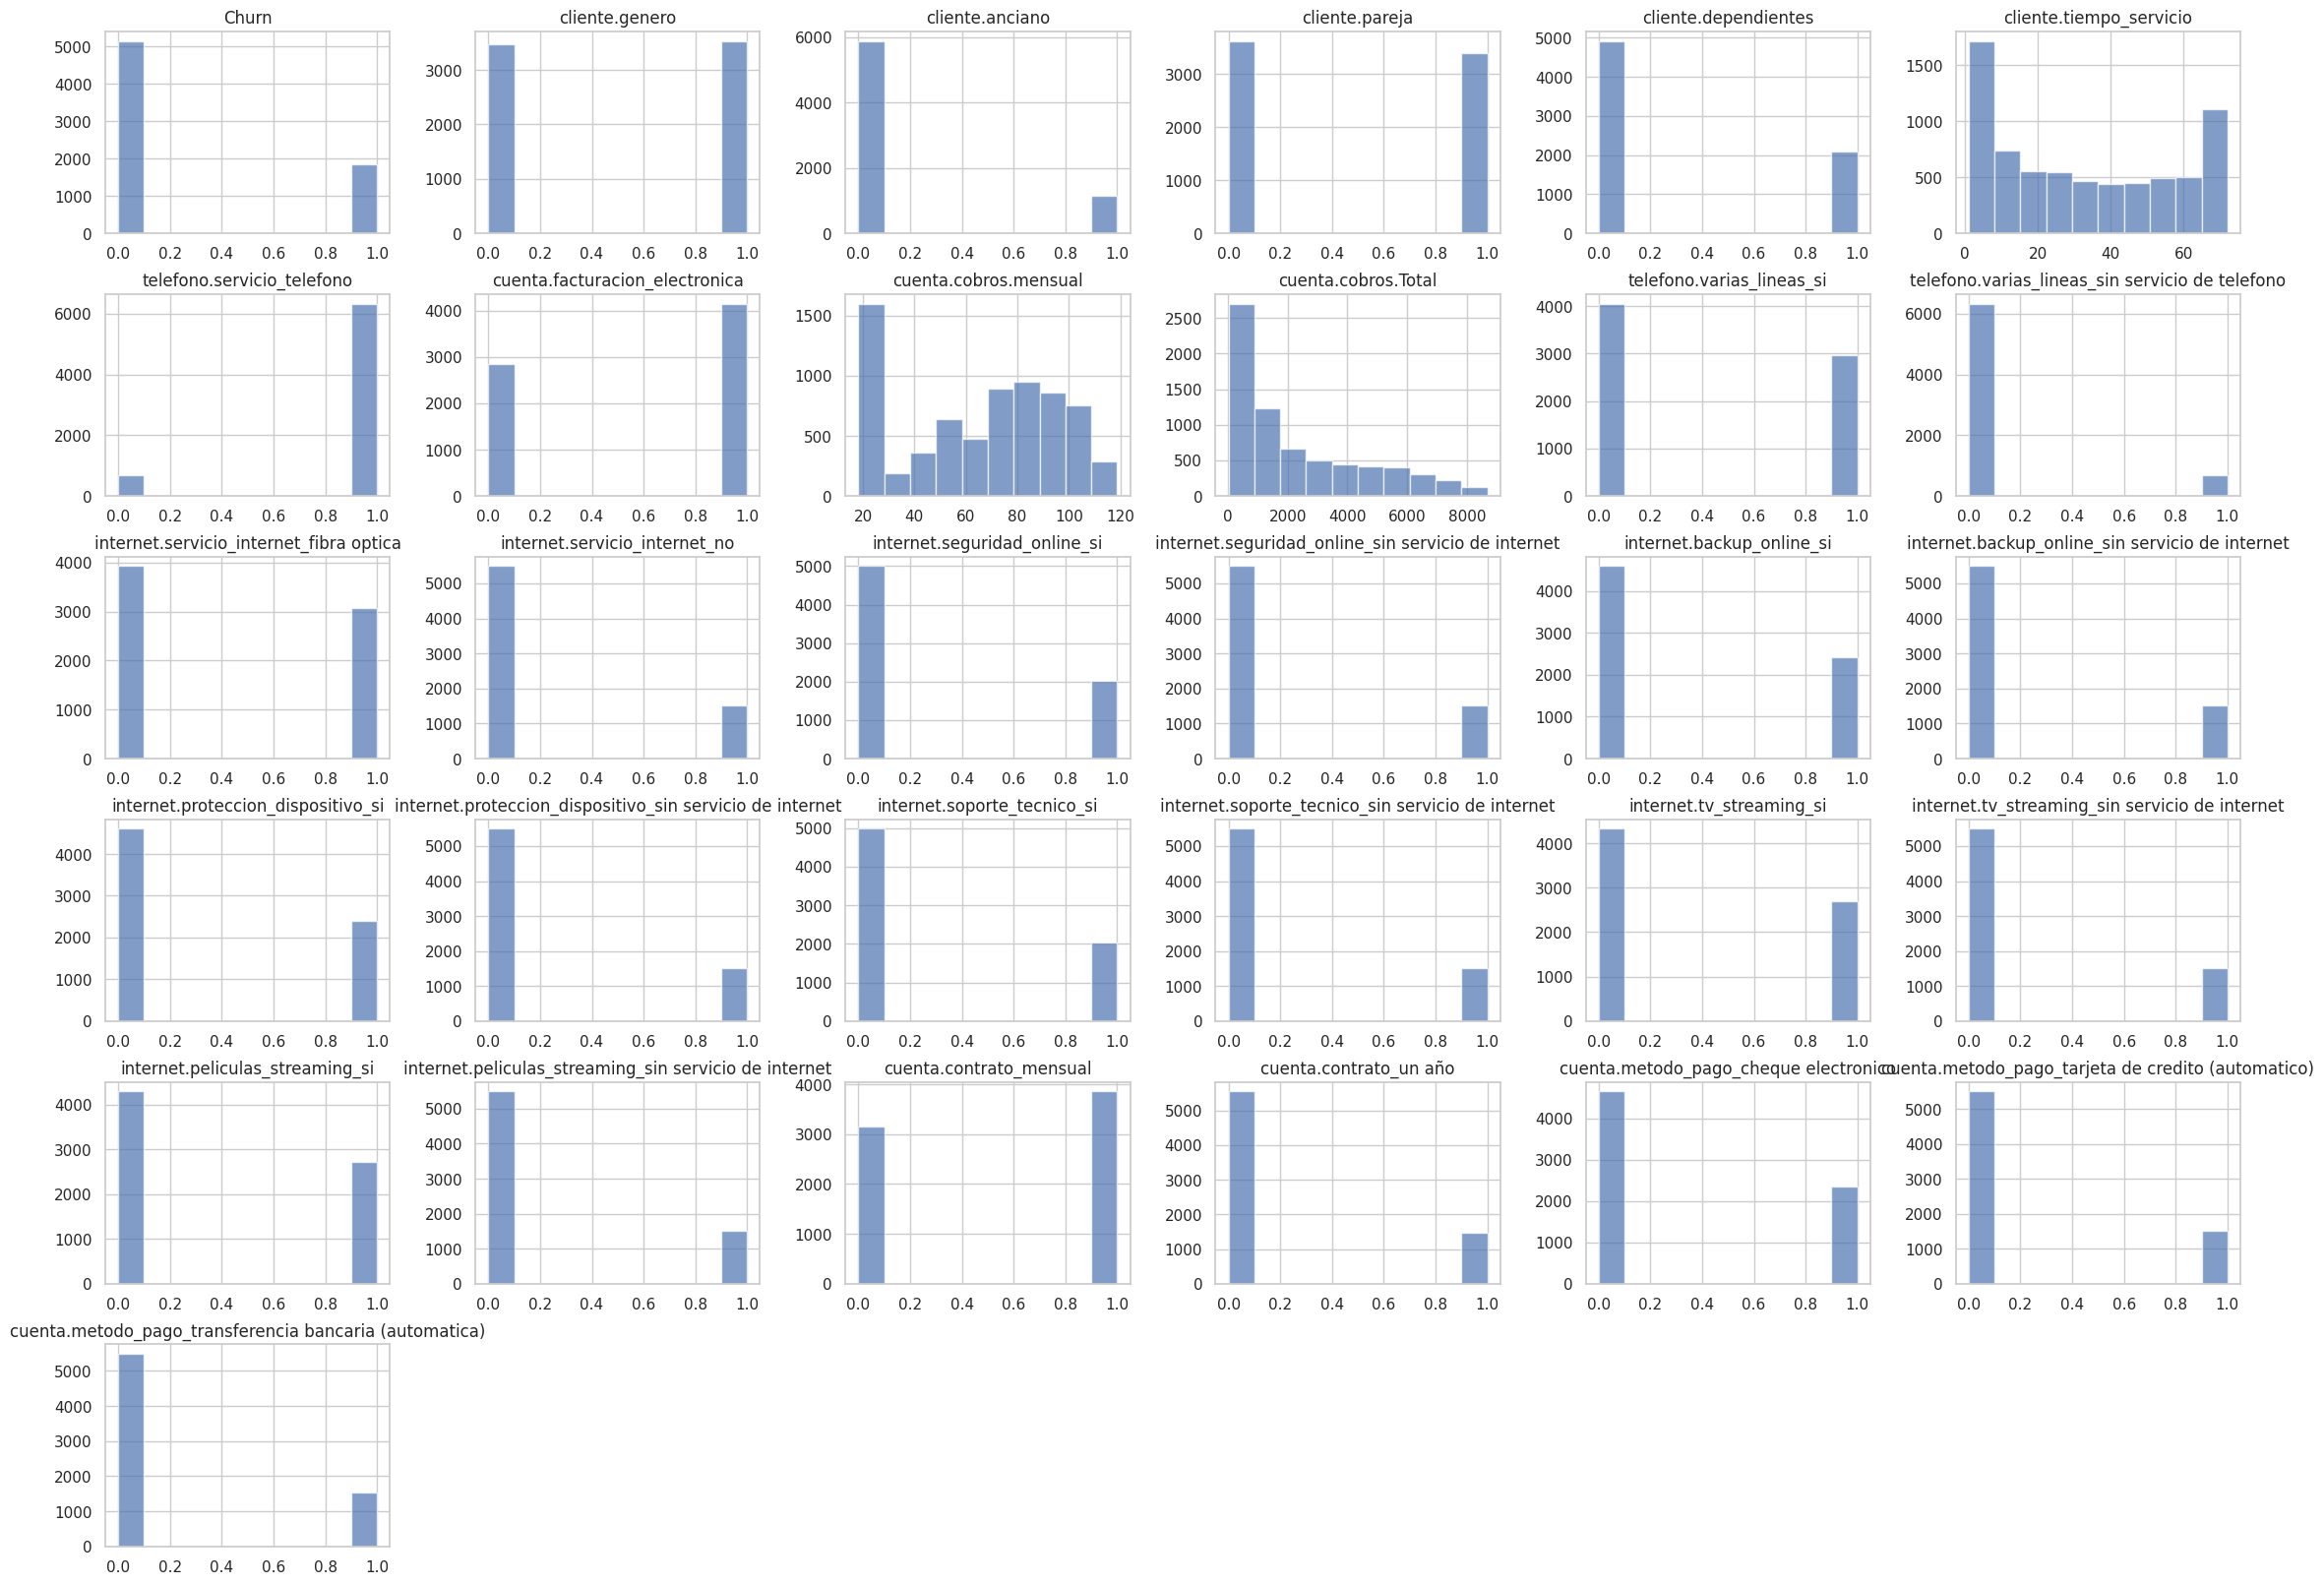

In [151]:
# Configuración de rcParams
plt.rcParams['axes.titlesize'] = 'large'    # Tamaño del título
plt.rcParams['axes.labelsize'] = 'medium'   # Tamaño de las etiquetas
plt.rcParams['xtick.labelsize'] = 'medium'   # Tamaño de las etiquetas del eje x
plt.rcParams['ytick.labelsize'] = 'medium'   # Tamaño de las etiquetas del eje y
plt.rcParams['legend.fontsize'] = 'medium'   # Tamaño de la leyenda
plt.rcParams['lines.linewidth'] = 2           # Ancho de línea
plt.rcParams['lines.color'] = 'blue'          # Color de las líneas

plt.rcParams['figure.figsize'] = [28,20];
sns.set(style="whitegrid")
datos_churn_norm_2.hist(alpha=0.7)
plt.show()

* Una variable a analizar es cliente.genero, ya que vemos en el histograma que practicamente tienen la misma proporción, lo cual nos indicaría que tenemos datos de ambos géneros. Sin embargo, si analizamos su relación con churn obtenemos:

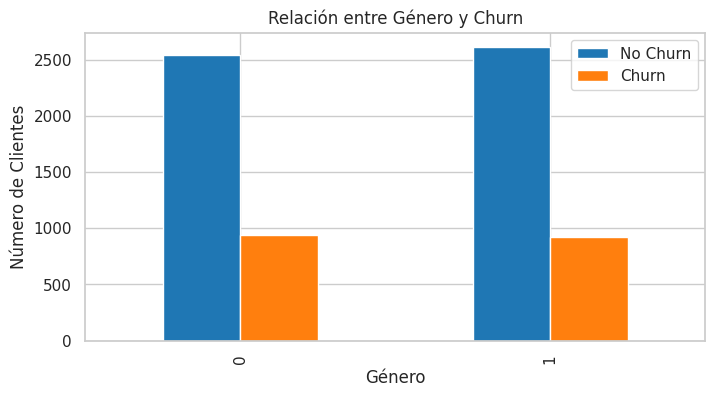

In [152]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['cliente.genero'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre Género y Churn')
plt.xlabel('Género')
plt.ylabel('Número de Clientes')
plt.show()

* Vemos que tienen la misma proporción en todo, por ende consideramos no relevante, ya que para cualquier clase tiene la misma proporción de churn, sea hombre o mujer tiene la misma razón de fuga.

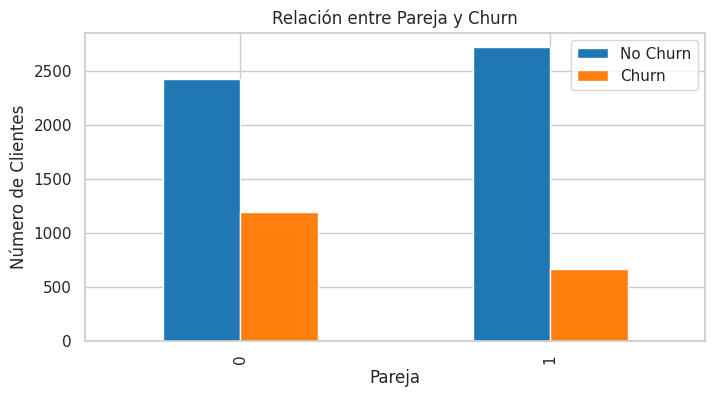

In [153]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['cliente.pareja'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre Pareja y Churn')
plt.xlabel('Pareja')
plt.ylabel('Número de Clientes')
plt.show()

* podemos observar que si tiene pareja se fuga menos, y cuando no tiene pareja se fuga más, esto podría darse debido a que en pareja se pasa más tiempo en casa y se usa más el servicio completo de telecomunicaciones y se tiende a cambiar menos. Variable a considerar.

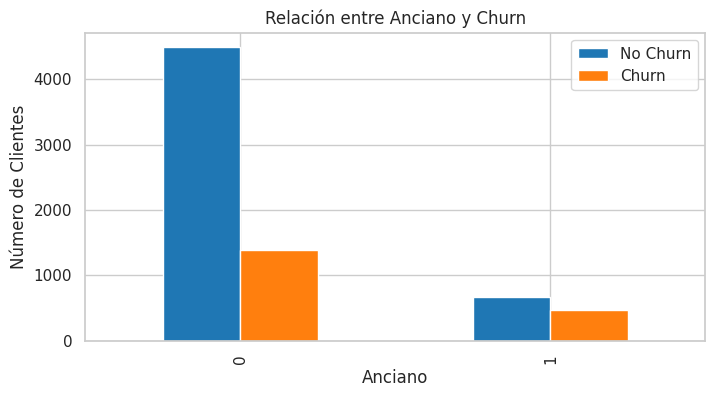

In [154]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['cliente.anciano'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre Anciano y Churn')
plt.xlabel('Anciano')
plt.ylabel('Número de Clientes')
plt.show()

* Esta variable es a considerar, ya que vemos que si bien hay pocos ancianos, notamos que practicamente todos los ancianos tienden a fugar.

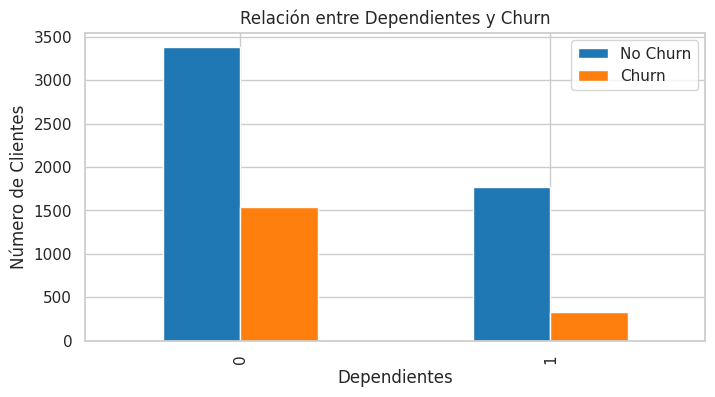

In [155]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['cliente.dependientes'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre Dependientes y Churn')
plt.xlabel('Dependientes')
plt.ylabel('Número de Clientes')
plt.show()

* Variable a considerar, ya que notamos que si tiene dependientes tiende a fugar menos en proporcion a su cantidad de valores, que comparado cuando no tiene dependientes, ya que ahi tiende a fugar más en proporción a su cantidad de valores. Variable que aporta valor para detectar CHURN SI.

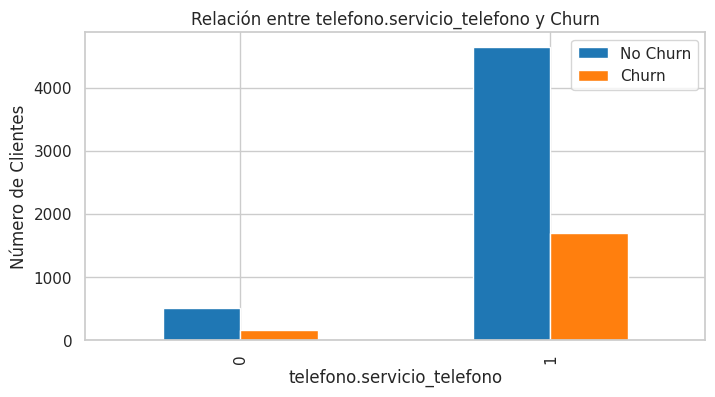

In [156]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['telefono.servicio_telefono'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre telefono.servicio_telefono y Churn')
plt.xlabel('telefono.servicio_telefono')
plt.ylabel('Número de Clientes')
plt.show()

* Observamos que los que tienen servicio de telefono, son casi todos y por ende aca es donde se observa mayor cantidad de gente que fuga. Sin embargo, las personas que no tienen telefono son pocos, pero en proporcion con personas que salen, se puede considerar y no despreciar. Recomendaría no eliminar esta variable.

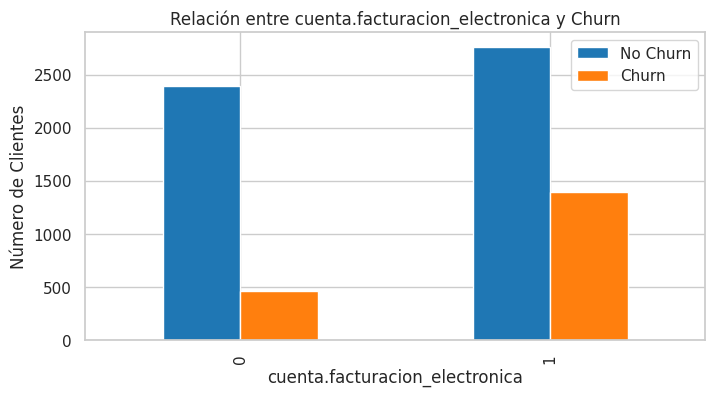

In [157]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['cuenta.facturacion_electronica'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre cuenta.facturacion_electronica y Churn')
plt.xlabel('cuenta.facturacion_electronica')
plt.ylabel('Número de Clientes')
plt.show()

* Variable a considerar, ya que para las dos clases se tiene los dos churn, en buena porción.

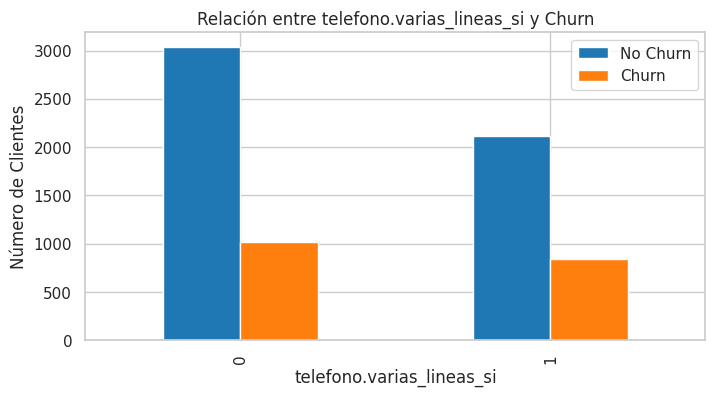

In [158]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['telefono.varias_lineas_si'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre telefono.varias_lineas_si y Churn')
plt.xlabel('telefono.varias_lineas_si')
plt.ylabel('Número de Clientes')
plt.show()

* Veo que existe casi la misma proporción de personas que se van, si tienen o no tienen linea, pero considero que esta variable si aporta valor al modelo.

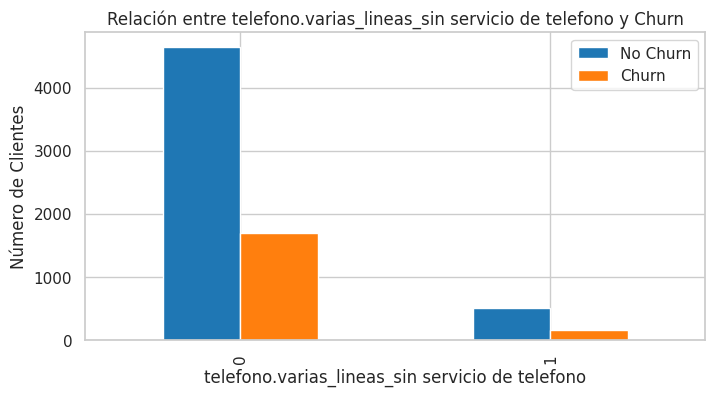

In [159]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['telefono.varias_lineas_sin servicio de telefono'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre telefono.varias_lineas_sin servicio de telefono y Churn')
plt.xlabel('telefono.varias_lineas_sin servicio de telefono')
plt.ylabel('Número de Clientes')
plt.show()

* Consideramos que esta variable puede que si aporte valor, pero en menor medida, analizando si descartarla.

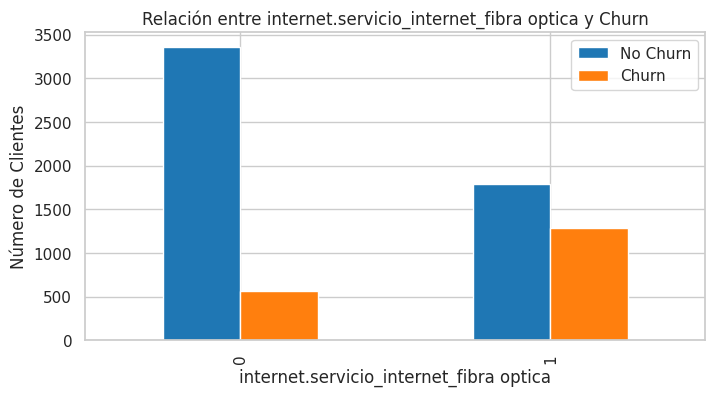

In [160]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['internet.servicio_internet_fibra optica'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre internet.servicio_internet_fibra optica y Churn')
plt.xlabel('internet.servicio_internet_fibra optica')
plt.ylabel('Número de Clientes')
plt.show()

* Esta variable si aporta valor, mayormente fugan las personas que están con fibra optica, comparado en proporción de su cantidad de valores, podría ser por costos altos.

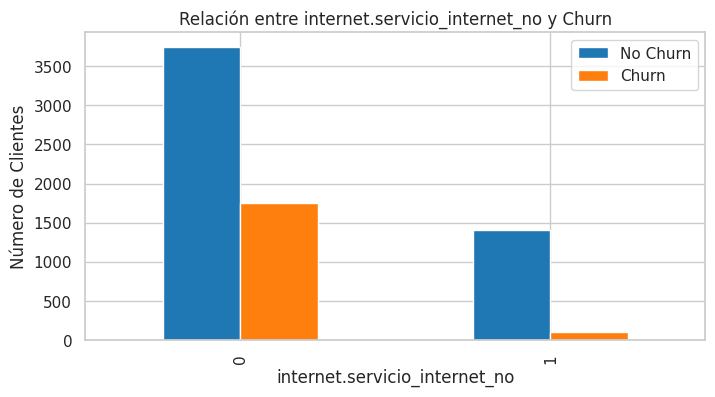

In [161]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['internet.servicio_internet_no'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre internet.servicio_internet_no y Churn')
plt.xlabel('internet.servicio_internet_no')
plt.ylabel('Número de Clientes')
plt.show()

* Vemos una desproporción en los datos, mayormente en esta variable fugan los que tienen servicio de internet, comparado con los que no tienen. Variable que por lo general tiende a una clase. Descartamos.

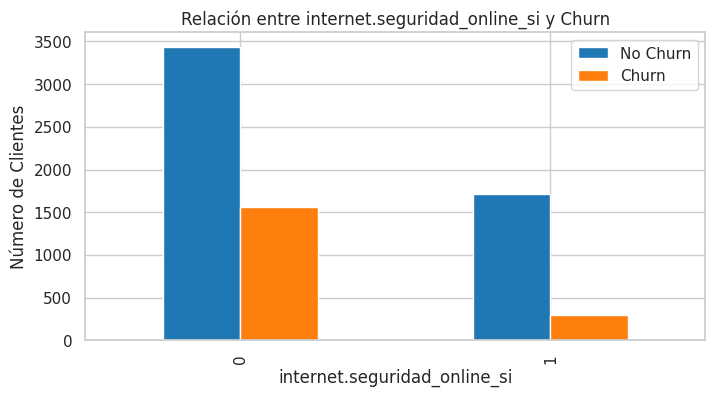

In [162]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['internet.seguridad_online_si'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre internet.seguridad_online_si y Churn')
plt.xlabel('internet.seguridad_online_si')
plt.ylabel('Número de Clientes')
plt.show()

* Variable a considerar, se observa relación en proporción.

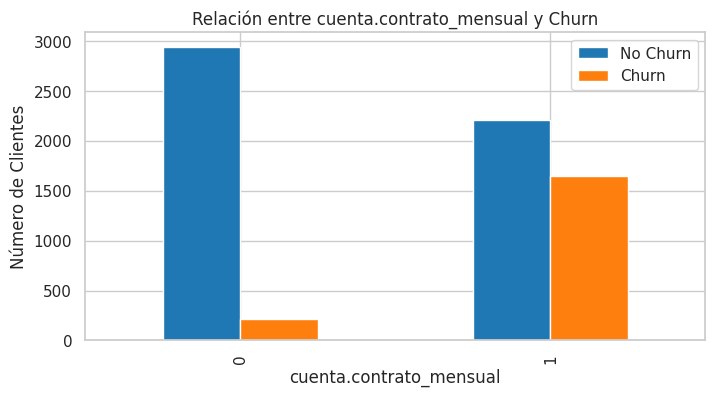

In [163]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['cuenta.contrato_mensual'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre cuenta.contrato_mensual y Churn')
plt.xlabel('cuenta.contrato_mensual')
plt.ylabel('Número de Clientes')
plt.show()

* Si bien vemos que el churn positivo se da cuando tienden a contratar por mes, esto no necesariamente es indicativo para elimianrlo, ya que para este aspecto tambien existen contratos por año y dos años, quizás esta variable si nos ayuda comparandola con las demás. Se mantiene.

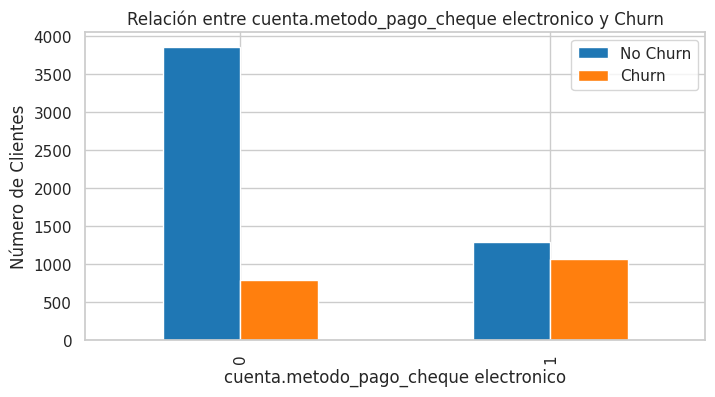

In [164]:
# Crear tabla de contingencia
tabla_contingencia = pd.crosstab(datos_churn_norm_2['cuenta.metodo_pago_cheque electronico'], datos_churn_norm_2['Churn'], margins=False)

# Renombrar las columnas para mayor claridad
tabla_contingencia.columns = ['No Churn', 'Churn']

# Graficar
tabla_contingencia.plot(kind='bar', figsize=(8, 4), color=['#1f77b4', '#ff7f0e'])
plt.title('Relación entre cuenta.metodo_pago_cheque electronico y Churn')
plt.xlabel('cuenta.metodo_pago_cheque electronico')
plt.ylabel('Número de Clientes')
plt.show()

* En los métodos de pago, consideramos que si aportan valor para determinar en el modelo si hay fuga o no. No se descarta ninguna.

In [165]:
variables_descartar = ['cliente.genero', 'internet.servicio_internet_no']

In [166]:
datos_churn_norm_2.drop(columns=variables_descartar, inplace=True)
datos_churn_norm_2.head()

Churn  cliente.anciano  cliente.pareja  cliente.dependientes  \
0      0                0               0                     0   
1      1                0               0                     0   
2      1                1               1                     0   
3      1                1               1                     0   
4      0                0               0                     1   

   cliente.tiempo_servicio  telefono.servicio_telefono  \
0                      9.0                           1   
1                      4.0                           1   
2                     13.0                           1   
3                      3.0                           1   
4                      9.0                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0                   59.9               542.40   
1                               1                   73.9               280.85   
2                               1                   98.0              1237.85   
3                               1                   83.9               267.40   
4                               1                   69.4               571.45   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.servicio_internet_fibra optica  internet.seguridad_online_si  \
0                                        0                             0   
1                                        1                             0   
2                                        1                             0   
3                                        1                             0   
4                                        0                             0   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   internet.backup_online_si  internet.backup_online_sin servicio de internet  \
0                          0                                                0   
1                          0                                                0   
2                          1                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.proteccion_dispositivo_si  \
0                                   0   
1                                   1   
2                                   1   
3                                   0   
4                                   0   

   internet.proteccion_dispositivo_sin servicio de internet  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   internet.soporte_tecnico_si  \
0                            0   
1                            0   
2                            0   
3                            1   
4                            1   

   internet.soporte_tecnico_sin servicio de internet  \
0                                                  0   
1                                              

* Sabemos que existe correlación entre las variables cliente.tiempo_servicio, cuenta.cobros.mensual y cuenta.cobros.Total, ya que el último es la múltiplicación de ambos.
* Esto genera una interdependencia lineal entre variables, por ende decidimos realizar un creación de una nueva variable que será tasa_cobro, la cual será la división de cobros.Total/cliente.tiempo_servicio, de esta manera podremos eliminar estas dos variables y no perder su aporte al modelo.

In [167]:
datos_churn_norm_2['tasa_cobro'] = round(datos_churn_norm_2['cuenta.cobros.Total']/datos_churn_norm_2['cliente.tiempo_servicio'], 2)
# datos_churn_norm_2.drop(columns=['cuenta.cobros.Total', 'cliente.tiempo_servicio'], inplace=True)
datos_churn_norm_2.head()

Churn  cliente.anciano  cliente.pareja  cliente.dependientes  \
0      0                0               0                     0   
1      1                0               0                     0   
2      1                1               1                     0   
3      1                1               1                     0   
4      0                0               0                     1   

   cliente.tiempo_servicio  telefono.servicio_telefono  \
0                      9.0                           1   
1                      4.0                           1   
2                     13.0                           1   
3                      3.0                           1   
4                      9.0                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0                   59.9               542.40   
1                               1                   73.9               280.85   
2                               1                   98.0              1237.85   
3                               1                   83.9               267.40   
4                               1                   69.4               571.45   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.servicio_internet_fibra optica  internet.seguridad_online_si  \
0                                        0                             0   
1                                        1                             0   
2                                        1                             0   
3                                        1                             0   
4                                        0                             0   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   internet.backup_online_si  internet.backup_online_sin servicio de internet  \
0                          0                                                0   
1                          0                                                0   
2                          1                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.proteccion_dispositivo_si  \
0                                   0   
1                                   1   
2                                   1   
3                                   0   
4                                   0   

   internet.proteccion_dispositivo_sin servicio de internet  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   internet.soporte_tecnico_si  \
0                            0   
1                            0   
2                            0   
3                            1   
4                            1   

   internet.soporte_tecnico_sin servicio de internet  \
0                                                  0   
1                                              

In [168]:
datos_churn_norm_2['tasa_cobro'].min(), datos_churn_norm_2['tasa_cobro'].max()

(13.78, 121.4)

* Ahora aplicaremos la Transformación Box-Cox de las variables contínuas.

In [169]:
from scipy import stats

# Aplicar la transformación Box-Cox
variables_continuas = ['cuenta.cobros.mensual', 'tasa_cobro', 'cuenta.cobros.Total', 'cliente.tiempo_servicio']
for col in variables_continuas:
    # # Asegú de que no haya valores negativos, ya que Box-Cox requiere datos positivos
    # if (df[col] <= 0).any():
    #     raise ValueError(f"La columna {col} contiene valores cero o negativos. Box-Cox no puede aplicarse.")
    datos_churn_norm_2[col], lambda_param = stats.boxcox(datos_churn_norm_2[col])
    print(f"Transformación de {col} realizada con lambda = {lambda_param}")

Transformación de cuenta.cobros.mensual realizada con lambda = 0.9186693800595223
Transformación de tasa_cobro realizada con lambda = 0.9087830169806577
Transformación de cuenta.cobros.Total realizada con lambda = 0.25418792223376596
Transformación de cliente.tiempo_servicio realizada con lambda = 0.4572353615331576


In [170]:
datos_churn_norm_2.head()

Churn  cliente.anciano  cliente.pareja  cliente.dependientes  \
0      0                0               0                     0   
1      1                0               0                     0   
2      1                1               1                     0   
3      1                1               1                     0   
4      0                0               0                     1   

   cliente.tiempo_servicio  telefono.servicio_telefono  \
0                 3.785683                           1   
1                 1.935278                           1   
2                 4.879282                           1   
3                 1.427182                           1   
4                 3.785683                           1   

   cuenta.facturacion_electronica  cuenta.cobros.mensual  cuenta.cobros.Total  \
0                               0              45.653584            15.558788   
1                               1              55.601564            12.555791   
2                               1              72.383016            20.107535   
3                               1              62.611841            12.351369   
4                               1              52.422254            15.819021   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.servicio_internet_fibra optica  internet.seguridad_online_si  \
0                                        0                             0   
1                                        1                             0   
2                                        1                             0   
3                                        1                             0   
4                                        0                             0   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   internet.backup_online_si  internet.backup_online_sin servicio de internet  \
0                          0                                                0   
1                          0                                                0   
2                          1                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.proteccion_dispositivo_si  \
0                                   0   
1                                   1   
2                                   1   
3                                   0   
4                                   0   

   internet.proteccion_dispositivo_sin servicio de internet  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   internet.soporte_tecnico_si  \
0                            0   
1                            0   
2                            0   
3                            1   
4                            1   

   internet.soporte_tecnico_sin servicio de internet  \
0                                                  0   
1                                              

#**3. Modelo Random Forest**


---

https://chatgpt.com/share/66fd9bca-9ce0-800f-8bef-e8c3909e7ac7

### **3.1 Modelo Random Forest con datos sin segmentar**

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y = datos_churn_new['Churn']
x = datos_churn_new.drop(columns = 'Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler = StandardScaler()
x_scaled = stdscaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.25, random_state=42)

rf = RandomForestClassifier(random_state=50)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.798745724059293


In [210]:
rf.score(x_test, y_test)

0.798745724059293

In [211]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1289
           1       0.66      0.49      0.56       465

    accuracy                           0.80      1754
   macro avg       0.75      0.70      0.72      1754
weighted avg       0.79      0.80      0.79      1754



### **3.2 Modelo Random Forest con datos segmentados**

In [174]:
y_2 = datos_churn_segmentado['Churn']
x_2 = datos_churn_segmentado.drop(columns = 'Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler_2 = StandardScaler()
x_scaled_2 = stdscaler_2.fit_transform(x_2)

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_scaled_2, y_2, test_size=0.25, random_state=42)

rf_2 = RandomForestClassifier(random_state=50)
rf_2.fit(x_train_2, y_train_2)

rf_2.score(x_test_2, y_test_2)

0.7884834663625998

In [175]:
y_pred_2 = rf_2.predict(x_test_2)
report_2 = classification_report(y_test_2, y_pred_2)
print(report_2)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1289
           1       0.63      0.48      0.55       465

    accuracy                           0.79      1754
   macro avg       0.73      0.69      0.70      1754
weighted avg       0.78      0.79      0.78      1754



### **3.3 Modelo Random Forest con aplicaciones logarítmicas en los datos**

In [176]:
y_3 = datos_churn_log['Churn']
x_3 = datos_churn_log.drop(columns = 'Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler_3 = StandardScaler()
x_scaled_3 = stdscaler_3.fit_transform(x_3)

x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_scaled_3, y_3, test_size=0.25, random_state=42)

rf_3 = RandomForestClassifier(random_state=50)
rf_3.fit(x_train_3, y_train_3)

rf_3.score(x_test_3, y_test_3)

0.7998859749144812

In [177]:
y_pred_3 = rf_3.predict(x_test_3)
report_3 = classification_report(y_test_3, y_pred_3)
print(report_3)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1289
           1       0.66      0.50      0.57       465

    accuracy                           0.80      1754
   macro avg       0.75      0.70      0.72      1754
weighted avg       0.79      0.80      0.79      1754



### **3.4 Modelo Random Forest con Transformación Box-Cox en los datos**

In [178]:
y_4 = datos_churn_box['Churn']
x_4 = datos_churn_box.drop(columns = 'Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler_4 = StandardScaler()
x_scaled_4 = stdscaler_4.fit_transform(x_4)

x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_4, y_4, test_size=0.25, random_state=42)

rf_4 = RandomForestClassifier(random_state=50)
rf_4.fit(x_train_4, y_train_4)

rf_4.score(x_test_4, y_test_4)

0.7998859749144812

In [179]:
y_pred_4 = rf_4.predict(x_test_4)
report_4 = classification_report(y_test_4, y_pred_4)
print(report_4)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1289
           1       0.66      0.50      0.57       465

    accuracy                           0.80      1754
   macro avg       0.75      0.70      0.72      1754
weighted avg       0.79      0.80      0.79      1754



### **3.5 Modelo Random Forest con Eliminación de variables y Transformación Box-Cox en los datos**

In [180]:
y_5 = datos_churn_norm['Churn']
x_5 = datos_churn_norm.drop(columns = 'Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler_5 = StandardScaler()
x_scaled_5 = stdscaler_5.fit_transform(x_5)

x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_scaled_5, y_5, test_size=0.25, random_state=42)

rf_5 = RandomForestClassifier(random_state=50)
rf_5.fit(x_train_5, y_train_5)

rf_5.score(x_test_5, y_test_5)

0.8027366020524516

In [181]:
y_pred_5 = rf_5.predict(x_test_5)
report_5 = classification_report(y_test_5, y_pred_5)
print(report_5)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1289
           1       0.67      0.51      0.58       465

    accuracy                           0.80      1754
   macro avg       0.75      0.71      0.72      1754
weighted avg       0.79      0.80      0.79      1754



### **3.6 Modelo Random Forest con Feature engineering, Eliminación de variables y Transformación Box-Cox en los datos**

In [212]:
import time
from sklearn.metrics import f1_score

y_6 = datos_churn_norm_2['Churn']
x_6 = datos_churn_norm_2.drop(columns = 'Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler_6 = StandardScaler()
x_scaled_6 = stdscaler_6.fit_transform(x_6)

x_train_6, x_test_6, y_train_6, y_test_6 = train_test_split(x_scaled_6, y_6, test_size=0.25, random_state=42)

rf_6 = RandomForestClassifier(random_state=50)

start_time = time.time()  # Iniciar temporizador
rf_6.fit(x_train_6, y_train_6)
end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_6 = end_time - start_time

# Evaluar el modelo en los datos de prueba
accuracy_test_propio = rf_6.score(x_test_6, y_test_6)
f1_score_test_propio = f1_score(y_test_6, rf_6.predict(x_test_6), average='weighted')
print(f"Accuracy: {accuracy_test_propio}")
print(f"F1-Score: {f1_score_test_propio}")
print(f"Tiempo de entrenamiento: {training_time_6} segundos")
print(f"Número de características seleccionadas: {len(x_6.columns)}")

Accuracy: 0.8044469783352337
F1-Score: 0.7958292078619782
Tiempo de entrenamiento: 0.6744706630706787 segundos
Número de características seleccionadas: 29


In [213]:
metricas_propio = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'Técnica': ['Feature_engineering'],
    'Accuracy': [accuracy_test_propio],
    'F1-Score': [f1_score_test_propio],
    'Tiempo de entrenamiento': [training_time_6],
    '# de features': [len(x_6.columns)]
})
metricas_propio

Modelo              Técnica  Accuracy  F1-Score  \
0  Random Forest  Feature_engineering  0.804447  0.795829   

   Tiempo de entrenamiento  # de features  
0                 0.674471             29

In [214]:
y_pred_6 = rf_6.predict(x_test_6)
report_6 = classification_report(y_test_6, y_pred_6)
print(report_6)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1289
           1       0.67      0.52      0.58       465

    accuracy                           0.80      1754
   macro avg       0.75      0.71      0.73      1754
weighted avg       0.79      0.80      0.80      1754



In [218]:
## Verificando si existe sobreajuste

# Predecir en el conjunto de entrenamiento y prueba
y_train_pred_6 = rf_6.predict(x_train_6)
y_test_pred_6 = rf_6.predict(x_test_6)

# Calcular métricas
accuracy_train = accuracy_score(y_train_6, y_train_pred_6)
f1_score_train = f1_score(y_train_6, y_train_pred_6, average='weighted')
accuracy_test = accuracy_score(y_test_6, y_test_pred_6)
f1_score_test = f1_score(y_test_6, y_test_pred_6, average='weighted')


# Imprimir resultados
print(f"Accuracy (Entrenamiento): {accuracy_train:.4f}, F1-Score (Entrenamiento): {f1_score_train:.4f}")
print(f"Accuracy (Prueba): {accuracy_test:.4f}, F1-Score (Prueba): {f1_score_test:.4f}")

Accuracy (Entrenamiento): 0.9973, F1-Score (Entrenamiento): 0.9973
Accuracy (Prueba): 0.8044, F1-Score (Prueba): 0.7958


In [219]:
# Calcular la diferencia entre las métricas de entrenamiento y prueba
accuracy_difference = accuracy_train - accuracy_test
f1_difference = f1_score_train - f1_score_test

print(f"Diferencia de Accuracy: {accuracy_difference:.4f}")
print(f"Diferencia de F1-Score: {f1_difference:.4f}")

# Evaluar el sobreajuste
if accuracy_difference > 0.1:  # Ajusta el umbral según tu criterio
    print("El modelo puede estar sobreajustado.")
else:
    print("El modelo no parece estar sobreajustado.")

Diferencia de Accuracy: 0.1929
Diferencia de F1-Score: 0.2015
El modelo puede estar sobreajustado.


#**4. Reducción de Dimensionalidad**

---

##**4.1 Métodos Gráficos**


In [173]:
def diagrama_puntos(df):
    df = df[df.select_dtypes(include='int').columns]
    # y = df['Churn']
    # x = df.drop(columns='Churn')
    # df = pd.concat([y, x.iloc[:, inicio:fin]], axis=1)
    df_melted = pd.melt(df, id_vars='Churn', var_name='features', value_name='valores')

    plt.figure(figsize=(12, 6))
    sns.pointplot(x="features", y="valores", hue="Churn", data=df_melted)
    plt.xticks(rotation=90)
    plt.title(f'Diagrama de Puntos de la distribución de características respecto al Churn', pad=10)
    plt.show()

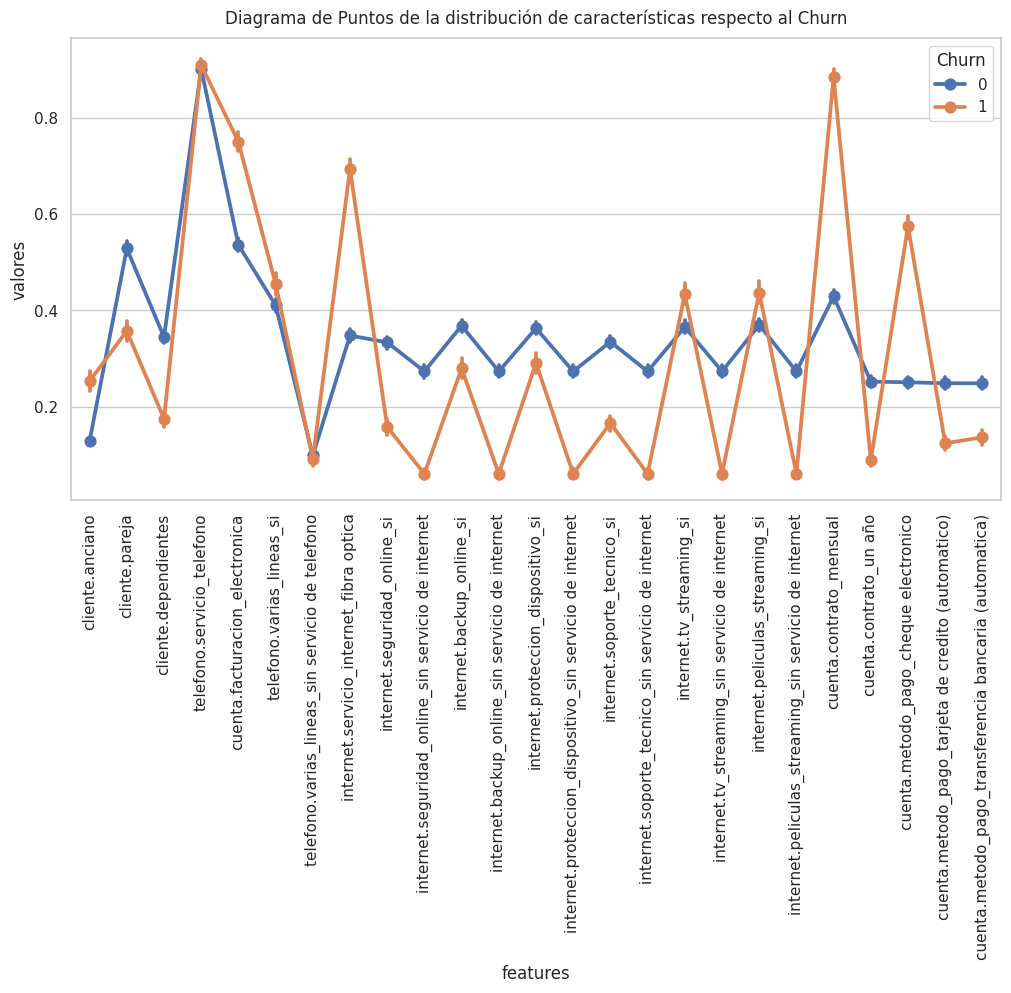

In [174]:
diagrama_puntos(datos_churn_norm_2)

In [175]:
df = datos_churn_norm_2[datos_churn_norm_2.select_dtypes(include='int').columns]
df.head()

Churn  cliente.anciano  cliente.pareja  cliente.dependientes  \
0      0                0               0                     0   
1      1                0               0                     0   
2      1                1               1                     0   
3      1                1               1                     0   
4      0                0               0                     1   

   telefono.servicio_telefono  cuenta.facturacion_electronica  \
0                           1                               0   
1                           1                               1   
2                           1                               1   
3                           1                               1   
4                           1                               1   

   telefono.varias_lineas_si  telefono.varias_lineas_sin servicio de telefono  \
0                          1                                                0   
1                          0                                                0   
2                          0                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.servicio_internet_fibra optica  internet.seguridad_online_si  \
0                                        0                             0   
1                                        1                             0   
2                                        1                             0   
3                                        1                             0   
4                                        0                             0   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   internet.backup_online_si  internet.backup_online_sin servicio de internet  \
0                          0                                                0   
1                          0                                                0   
2                          1                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.proteccion_dispositivo_si  \
0                                   0   
1                                   1   
2                                   1   
3                                   0   
4                                   0   

   internet.proteccion_dispositivo_sin servicio de internet  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   internet.soporte_tecnico_si  \
0                            0   
1                            0   
2                            0   
3                            1   
4                            1   

   internet.soporte_tecnico_sin servicio de internet  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   internet.tv_streaming_si  internet.tv_streaming_sin servicio de internet  \
0                         0                                               0   
1                         0                                               0   
2                         1   

In [176]:
##Realizamos un dataframe para hacer un formato largo con melt, facilitando la visualización
df_melted = pd.melt(df, id_vars='Churn', var_name='features', value_name='valores')
df_melted.head()

Churn         features  valores
0      0  cliente.anciano        0
1      1  cliente.anciano        0
2      1  cliente.anciano        1
3      1  cliente.anciano        1
4      0  cliente.anciano        0

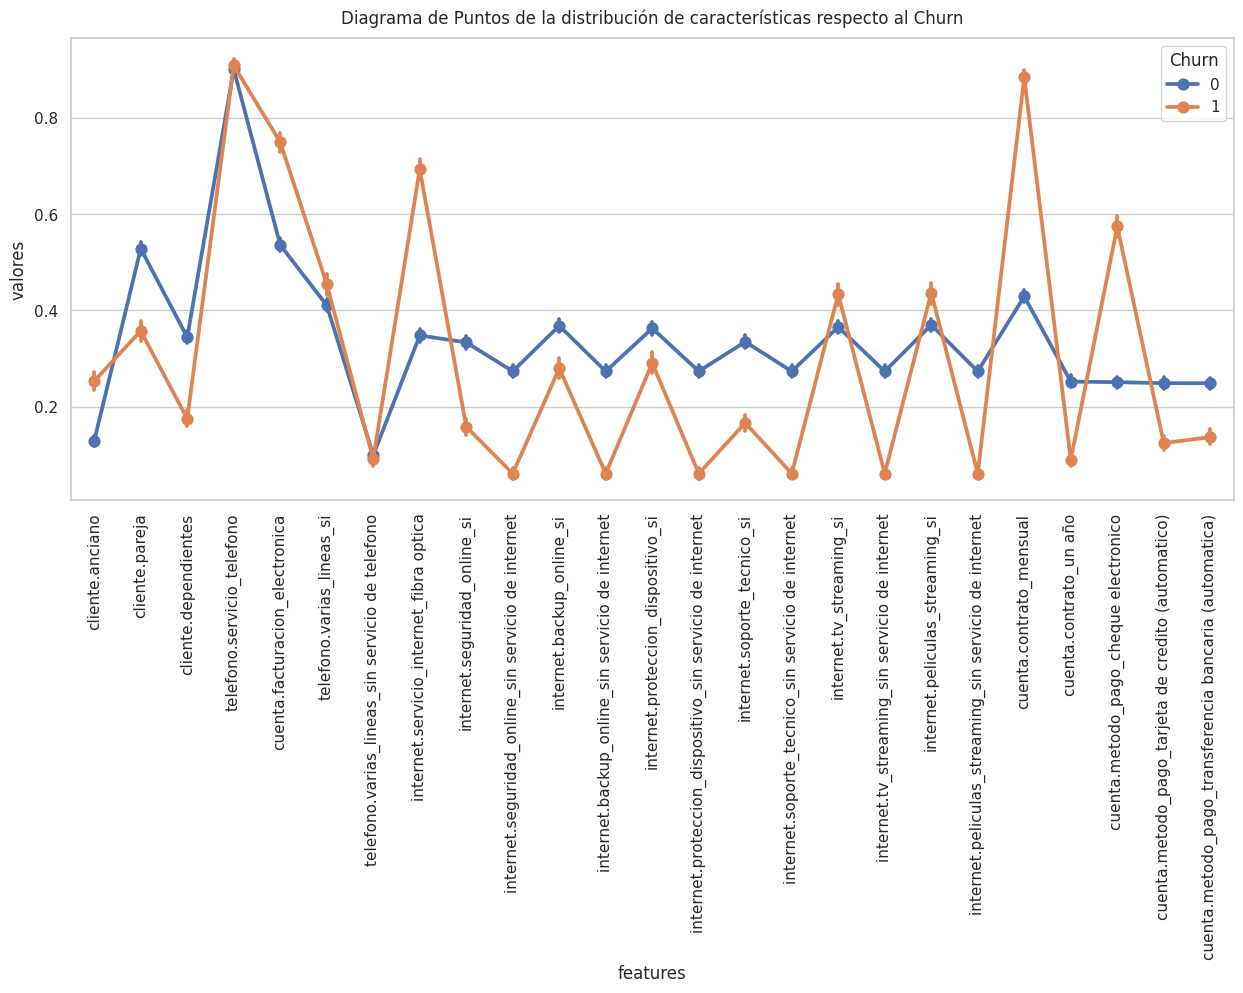

In [177]:
## Diagrama de puntos para analizar la distribución de características respecto al Churn.
plt.figure(figsize=(15, 6))
sns.pointplot(x="features", y="valores", hue="Churn", data=df_melted)
plt.xticks(rotation=90)
plt.title('Diagrama de Puntos de la distribución de características respecto al Churn', pad=10)
plt.show()

* Después de analizar el gráfico de distribución de características de los features con respecto al Churn, podemos concluir que algunas variables no aportan mucho valor al modelo, debido a que es indiferente al valor que resulte, puede salir un Churn 0 ó Churn 1. No nos da un resultado claro.
* Estas variables son: telefono.servicio_telefono, telefono.varias_lineas_si y telefono.varias_lineas_sin servicio de telefono.

In [178]:
## Eliminando esas variables del dataframe
df_grafic = df.drop(columns=['telefono.servicio_telefono', 'telefono.varias_lineas_si', 'telefono.varias_lineas_sin servicio de telefono'])
df_grafic.head()

Churn  cliente.anciano  cliente.pareja  cliente.dependientes  \
0      0                0               0                     0   
1      1                0               0                     0   
2      1                1               1                     0   
3      1                1               1                     0   
4      0                0               0                     1   

   cuenta.facturacion_electronica  internet.servicio_internet_fibra optica  \
0                               0                                        0   
1                               1                                        1   
2                               1                                        1   
3                               1                                        1   
4                               1                                        0   

   internet.seguridad_online_si  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   internet.seguridad_online_sin servicio de internet  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   internet.backup_online_si  internet.backup_online_sin servicio de internet  \
0                          0                                                0   
1                          0                                                0   
2                          1                                                0   
3                          0                                                0   
4                          0                                                0   

   internet.proteccion_dispositivo_si  \
0                                   0   
1                                   1   
2                                   1   
3                                   0   
4                                   0   

   internet.proteccion_dispositivo_sin servicio de internet  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   internet.soporte_tecnico_si  \
0                            0   
1                            0   
2                            0   
3                            1   
4                            1   

   internet.soporte_tecnico_sin servicio de internet  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   internet.tv_streaming_si  internet.tv_streaming_sin servicio de internet  \
0                         0                                               0   
1                         0                                               0   
2                         1                                               0   
3                         1                                               0   
4                         1                                               0   

   internet.peliculas_streaming_si  \
0                                1   
1                                0   
2                                1   
3                                0   
4                                1   

   internet.peliculas_streaming_sin servicio de internet  \
0                                                  0       
1                                                  0       
2                                     

**RANDOM FOREST SIN BALANCEO**

In [180]:
import time
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

df_grafic = datos_churn_norm_2.drop(columns=['telefono.servicio_telefono', 'telefono.varias_lineas_si', 'telefono.varias_lineas_sin servicio de telefono'])

## Aplicando el modelo Random Forest y viendo la mejora
y_grafic = df_grafic['Churn']
x_grafic = df_grafic.drop(columns='Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler_grafic = StandardScaler()
x_scaled_grafic = stdscaler_grafic.fit_transform(x_grafic)

x_train_grafic, x_test_grafic, y_train_grafic, y_test_grafic = train_test_split(x_scaled_grafic, y_grafic, test_size=0.25, random_state=42)

rf_grafic = RandomForestClassifier(random_state=50)

start_time = time.time()  # Iniciar temporizador
rf_grafic.fit(x_train_grafic, y_train_grafic)
end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_grafic = end_time - start_time

# Evaluar el modelo en los datos de prueba
accuracy_test_grafic = rf_grafic.score(x_test_grafic, y_test_grafic)
f1_score_test_grafic = f1_score(y_test_grafic, rf_grafic.predict(x_test_grafic), average='weighted')
print(f"Accuracy: {accuracy_test_grafic}")
print(f"F1-Score: {f1_score_test_grafic}")
print(f"Tiempo de entrenamiento: {training_time_grafic} segundos")
print(f"Número de características seleccionadas: {len(x_grafic.columns)}")

Accuracy: 0.7998859749144812
F1-Score: 0.7916661034191252
Tiempo de entrenamiento: 1.113940954208374 segundos
Número de características seleccionadas: 26


* Vemos que no mejoro el modelo, pero tampoco bajó en valor de accuracy, eso quiere decir que las variables que eliminamos, en realidad no aportaban valor. De esta manera tenemos un modelo con menos variables, menor coste computacional.

In [181]:
metricas_grafic = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'Técnica': ['Graficos'],
    'Accuracy': [accuracy_test_grafic],
    'F1-Score': [f1_score_test_grafic],
    'Tiempo de entrenamiento': [training_time_grafic],
    '# de features': [len(x_grafic.columns)]
})
metricas_grafic

Modelo   Técnica  Accuracy  F1-Score  Tiempo de entrenamiento  \
0  Random Forest  Graficos  0.799886  0.791666                 1.113941   

   # de features  
0             26

**RANDOM FOREST CON BALANCEO**

In [182]:
from imblearn.over_sampling import SMOTE
## Aplicando el modelo Random Forest y viendo la mejora
y_grafic = datos_churn_norm_2['Churn']
x_grafic = datos_churn_norm_2.drop(columns='Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
stdscaler_grafic = StandardScaler()
x_scaled_grafic = stdscaler_grafic.fit_transform(x_grafic)

x_train_grafic, x_test_grafic, y_train_grafic, y_test_grafic = train_test_split(x_scaled_grafic, y_grafic, test_size=0.25, random_state=42)

# Aplicar SMOTE para balancear el conjunto de entrenamiento
smo = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smo.fit_resample(x_train_grafic, y_train_grafic)

rf_grafic = RandomForestClassifier(random_state=50)
rf_grafic.fit(x_train_balanced, y_train_balanced)

rf_grafic.score(x_test_grafic, y_test_grafic)

0.7976054732041049

##**4.2 Mapa de Calor**

In [183]:
corr = datos_churn_norm_2.corr()
corr

Churn  cliente.anciano  \
Churn                                               1.000000         0.148901   
cliente.anciano                                     0.148901         1.000000   
cliente.pareja                                     -0.151093         0.016921   
cliente.dependientes                               -0.163444        -0.210151   
cliente.tiempo_servicio                            -0.376238         0.018339   
telefono.servicio_telefono                          0.012212         0.007713   
cuenta.facturacion_electronica                      0.192021         0.155528   
cuenta.cobros.mensual                               0.194716         0.219090   
cuenta.cobros.Total                                -0.238610         0.104526   
telefono.varias_lineas_si                           0.039400         0.142494   
telefono.varias_lineas_sin servicio de telefono    -0.012212        -0.007713   
internet.servicio_internet_fibra optica             0.307689         0.255099   
internet.seguridad_online_si                       -0.171299        -0.038198   
internet.seguridad_online_sin servicio de internet -0.227739        -0.182400   
internet.backup_online_si                          -0.082314         0.066798   
internet.backup_online_sin servicio de internet    -0.227739        -0.182400   
internet.proteccion_dispositivo_si                 -0.067000         0.057031   
internet.proteccion_dispositivo_sin servicio de... -0.227739        -0.182400   
internet.soporte_tecnico_si                        -0.164225        -0.061589   
internet.soporte_tecnico_sin servicio de internet  -0.227739        -0.182400   
internet.tv_streaming_si                            0.061880         0.103223   
internet.tv_streaming_sin servicio de internet     -0.227739        -0.182400   
internet.peliculas_streaming_si                     0.060813         0.118495   
internet.peliculas_streaming_sin servicio de in... -0.227739        -0.182400   
cuenta.contrato_mensual                             0.404742         0.139124   
cuenta.contrato_un año                             -0.176800        -0.046618   
cuenta.metodo_pago_cheque electronico               0.302387         0.170317   
cuenta.metodo_pago_tarjeta de credito (automatico) -0.133685        -0.022317   
cuenta.metodo_pago_transferencia bancaria (auto... -0.119761        -0.016318   
tasa_cobro                                          0.193950         0.216816   

                                                    cliente.pareja  \
Churn                                                    -0.151093   
cliente.anciano                                           0.016921   
cliente.pareja                                            1.000000   
cliente.dependientes                                      0.452277   
cliente.tiempo_servicio                                   0.381385   
telefono.servicio_telefono                                0.018267   
cuenta.facturacion_electronica                           -0.015786   
cuenta.cobros.mensual                                     0.094119   
cuenta.cobros.Total                                       0.343296   
telefono.varias_lineas_si                                 0.141519   
telefono.varias_lineas_sin servicio de telefono          -0.018267   
internet.servicio_internet_fibra optica                  -0.000556   
internet.seguridad_online_si                              0.142756   
internet.seguridad_online_sin servicio de internet        0.001674   
internet.backup_online_si                                 0.140012   
internet.backup_online_sin servicio de internet           0.001674   
internet.proteccion_dispositivo_si                        0.154454   
internet.proteccion_dispositivo_sin servicio de...        0.001674   
internet.soporte_tecnico_si                               0.119893   
internet.soporte_tecnico_sin servicio de internet         0.001674   
internet.tv_streaming_si                                  0.123726   
int

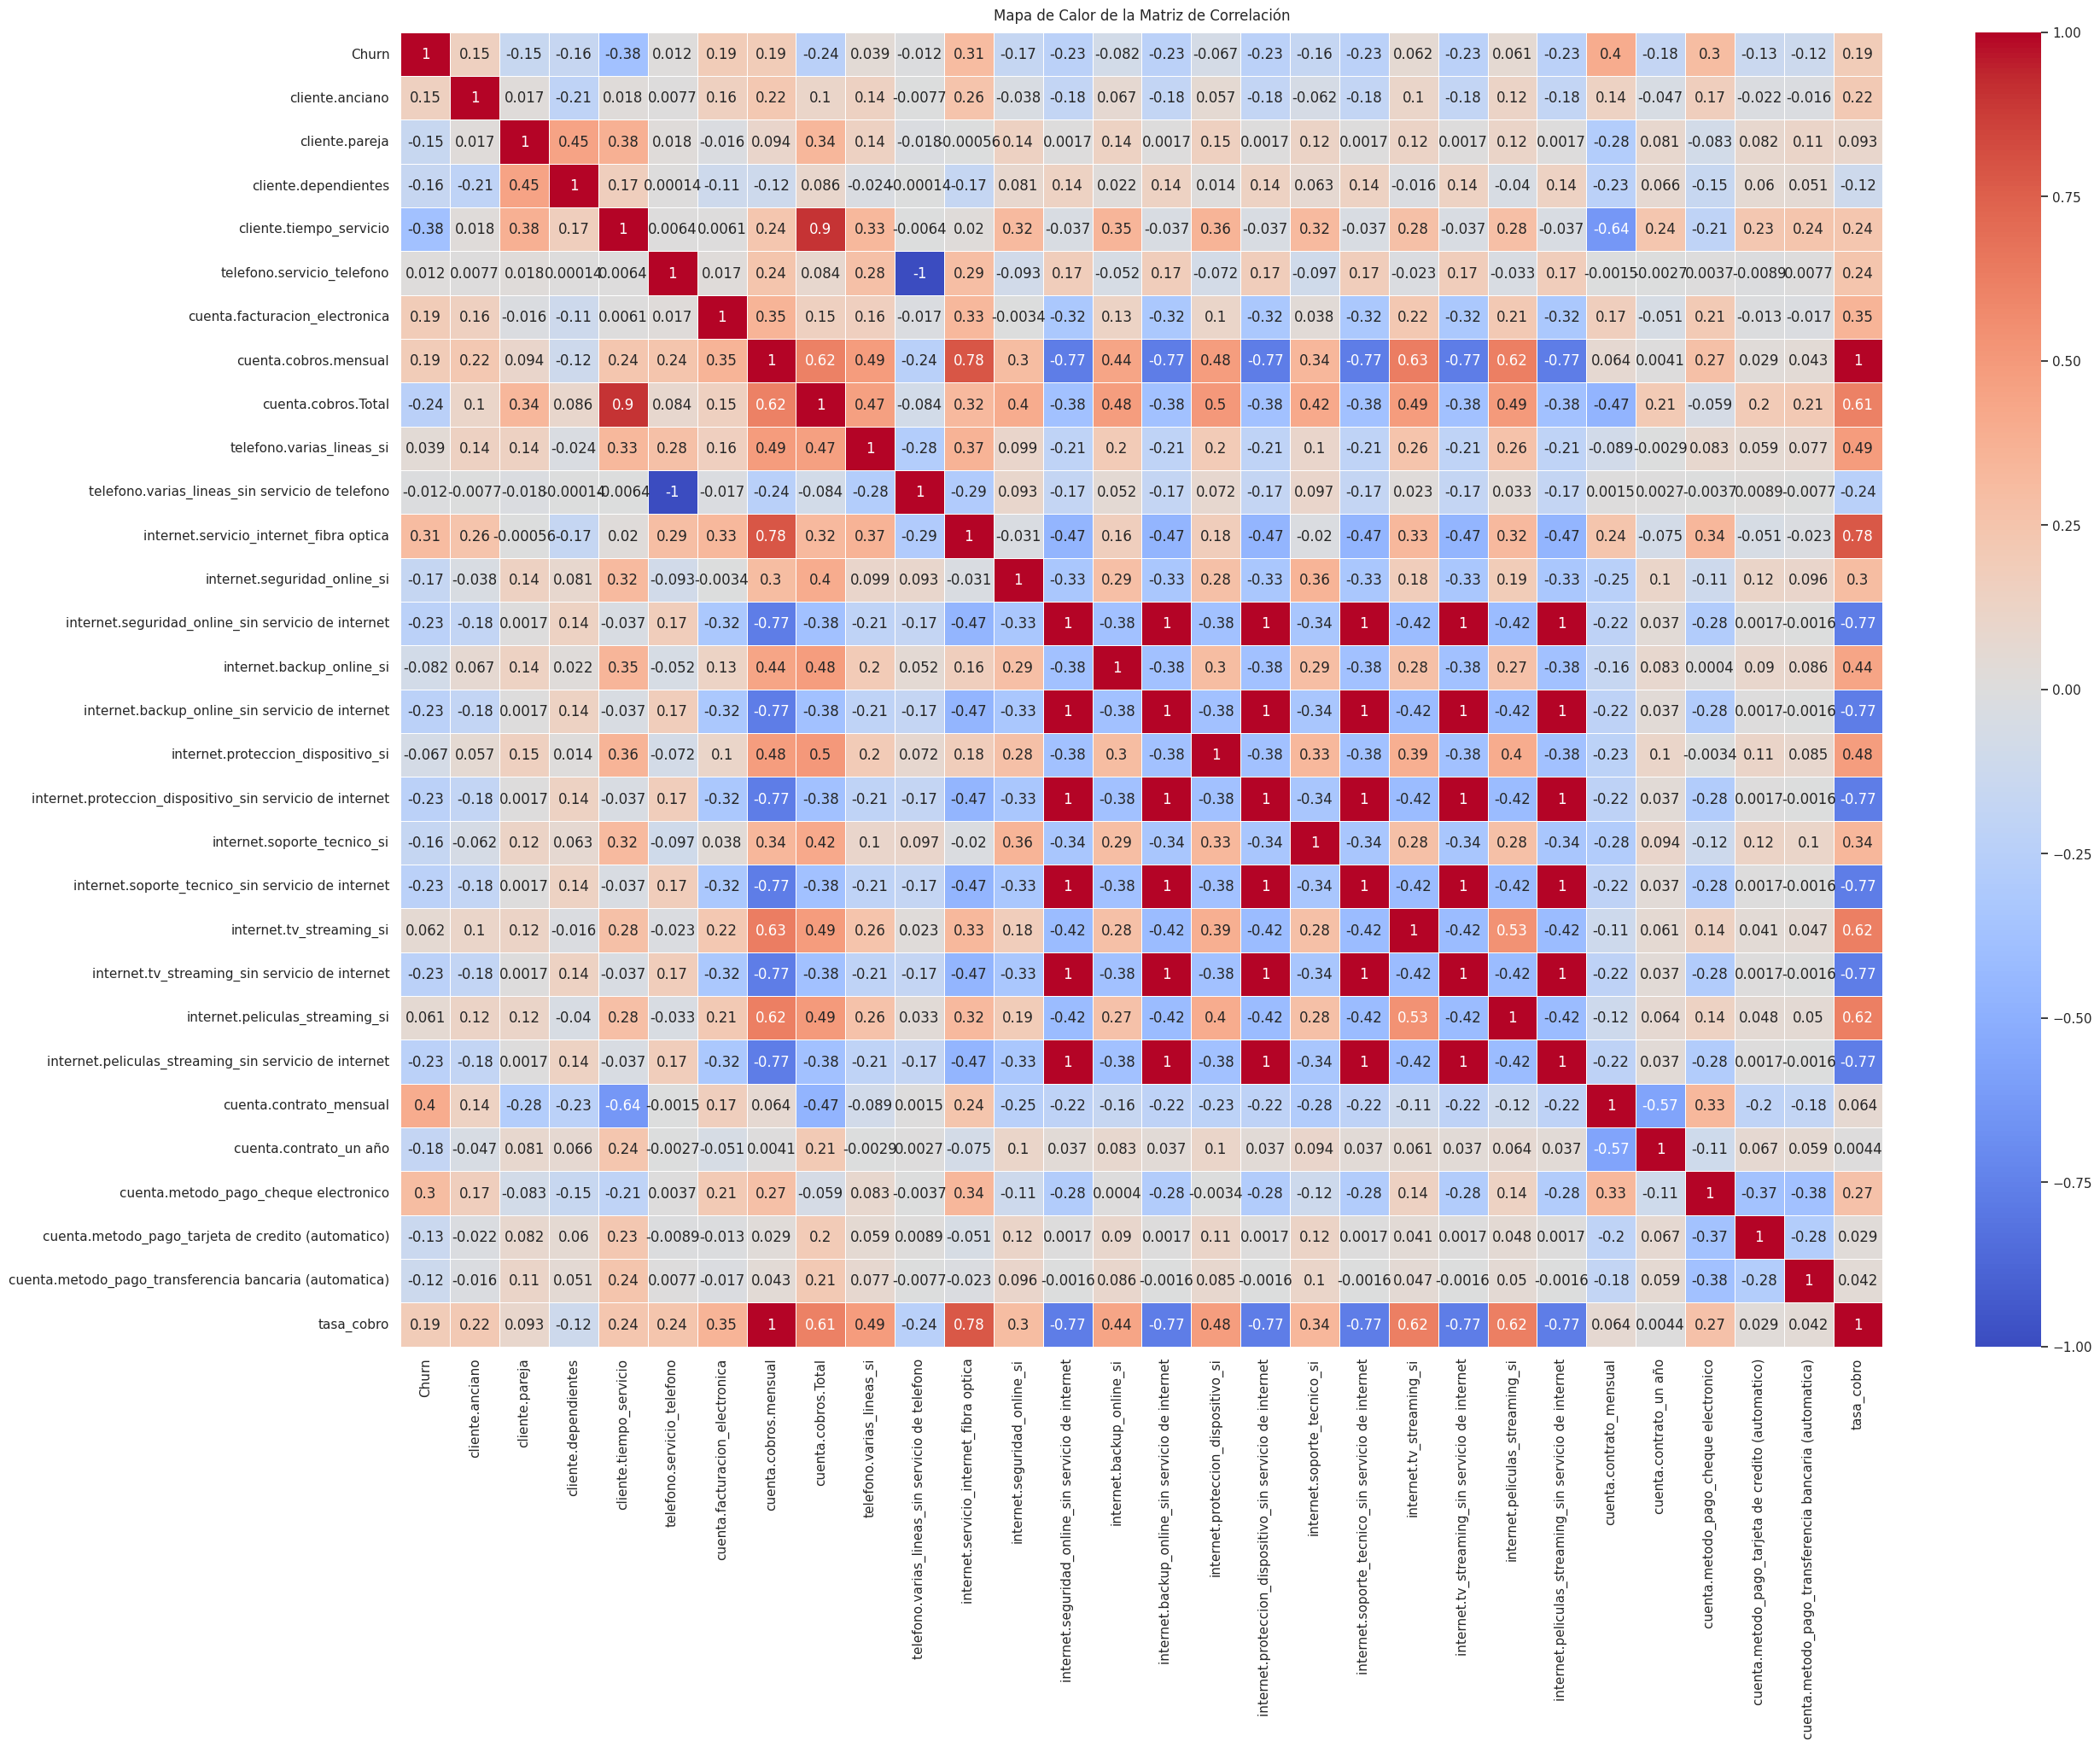

In [184]:
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de la Matriz de Correlación', pad=10)
plt.show()

* Observamos que tenemos variables que se correlacionan perfectamente unas de otras. Esto nos muestra que existe multicolinealidad, la cual debemos de trabajar para evitar que afecte a nuestro rendimiento del modelo.

In [185]:
corr_new = corr.drop(columns='Churn')
corr_new.columns

Index(['cliente.anciano', 'cliente.pareja', 'cliente.dependientes',
       'cliente.tiempo_servicio', 'telefono.servicio_telefono',
       'cuenta.facturacion_electronica', 'cuenta.cobros.mensual',
       'cuenta.cobros.Total', 'telefono.varias_lineas_si',
       'telefono.varias_lineas_sin servicio de telefono',
       'internet.servicio_internet_fibra optica',
       'internet.seguridad_online_si',
       'internet.seguridad_online_sin servicio de internet',
       'internet.backup_online_si',
       'internet.backup_online_sin servicio de internet',
       'internet.proteccion_dispositivo_si',
       'internet.proteccion_dispositivo_sin servicio de internet',
       'internet.soporte_tecnico_si',
       'internet.soporte_tecnico_sin servicio de internet',
       'internet.tv_streaming_si',
       'internet.tv_streaming_sin servicio de internet',
       'internet.peliculas_streaming_si',
       'internet.peliculas_streaming_sin servicio de internet',
       'cuenta.contrato_mensual',

In [186]:
## Agrupamos las variables que tienen un valor de correlación mayor de 70
lista_variables_correlacionadas = []
corr_new = corr.drop(columns='Churn')
for i in corr_new.columns:
  ## Consiguiendo un dataframe individual para cada columna
  new = corr_new[i].sort_values(ascending=False).drop(labels=i)
  ## Sacando el index de todos los valores mayores que la condición para esta variable
  variables = new[new>0.7].index
  if variables.empty:
    continue
  lista_variables_correlacionadas.extend(list(variables))
  print(f'Variable correlacionadas > 70 con la varaible {i}: \n {list(variables)}')

print('*********'*10)
lista_variables_correlacionadas = list(set(lista_variables_correlacionadas))
lista_variables_correlacionadas

Variable correlacionadas > 70 con la varaible cliente.tiempo_servicio: 
 ['cuenta.cobros.Total']
Variable correlacionadas > 70 con la varaible cuenta.cobros.mensual: 
 ['tasa_cobro', 'internet.servicio_internet_fibra optica']
Variable correlacionadas > 70 con la varaible cuenta.cobros.Total: 
 ['cliente.tiempo_servicio']
Variable correlacionadas > 70 con la varaible internet.servicio_internet_fibra optica: 
 ['cuenta.cobros.mensual', 'tasa_cobro']
Variable correlacionadas > 70 con la varaible internet.seguridad_online_sin servicio de internet: 
 ['internet.peliculas_streaming_sin servicio de internet', 'internet.soporte_tecnico_sin servicio de internet', 'internet.tv_streaming_sin servicio de internet', 'internet.proteccion_dispositivo_sin servicio de internet', 'internet.backup_online_sin servicio de internet']
Variable correlacionadas > 70 con la varaible internet.backup_online_sin servicio de internet: 
 ['internet.seguridad_online_sin servicio de internet', 'internet.peliculas_stre

['cliente.tiempo_servicio',
 'cuenta.cobros.mensual',
 'internet.seguridad_online_sin servicio de internet',
 'tasa_cobro',
 'internet.proteccion_dispositivo_sin servicio de internet',
 'internet.peliculas_streaming_sin servicio de internet',
 'internet.servicio_internet_fibra optica',
 'cuenta.cobros.Total',
 'internet.tv_streaming_sin servicio de internet',
 'internet.soporte_tecnico_sin servicio de internet',
 'internet.backup_online_sin servicio de internet']

Text(0.5, 1.0, 'Mapa de Calor de la Matriz de Correlación - Variables correlacionadas >70')

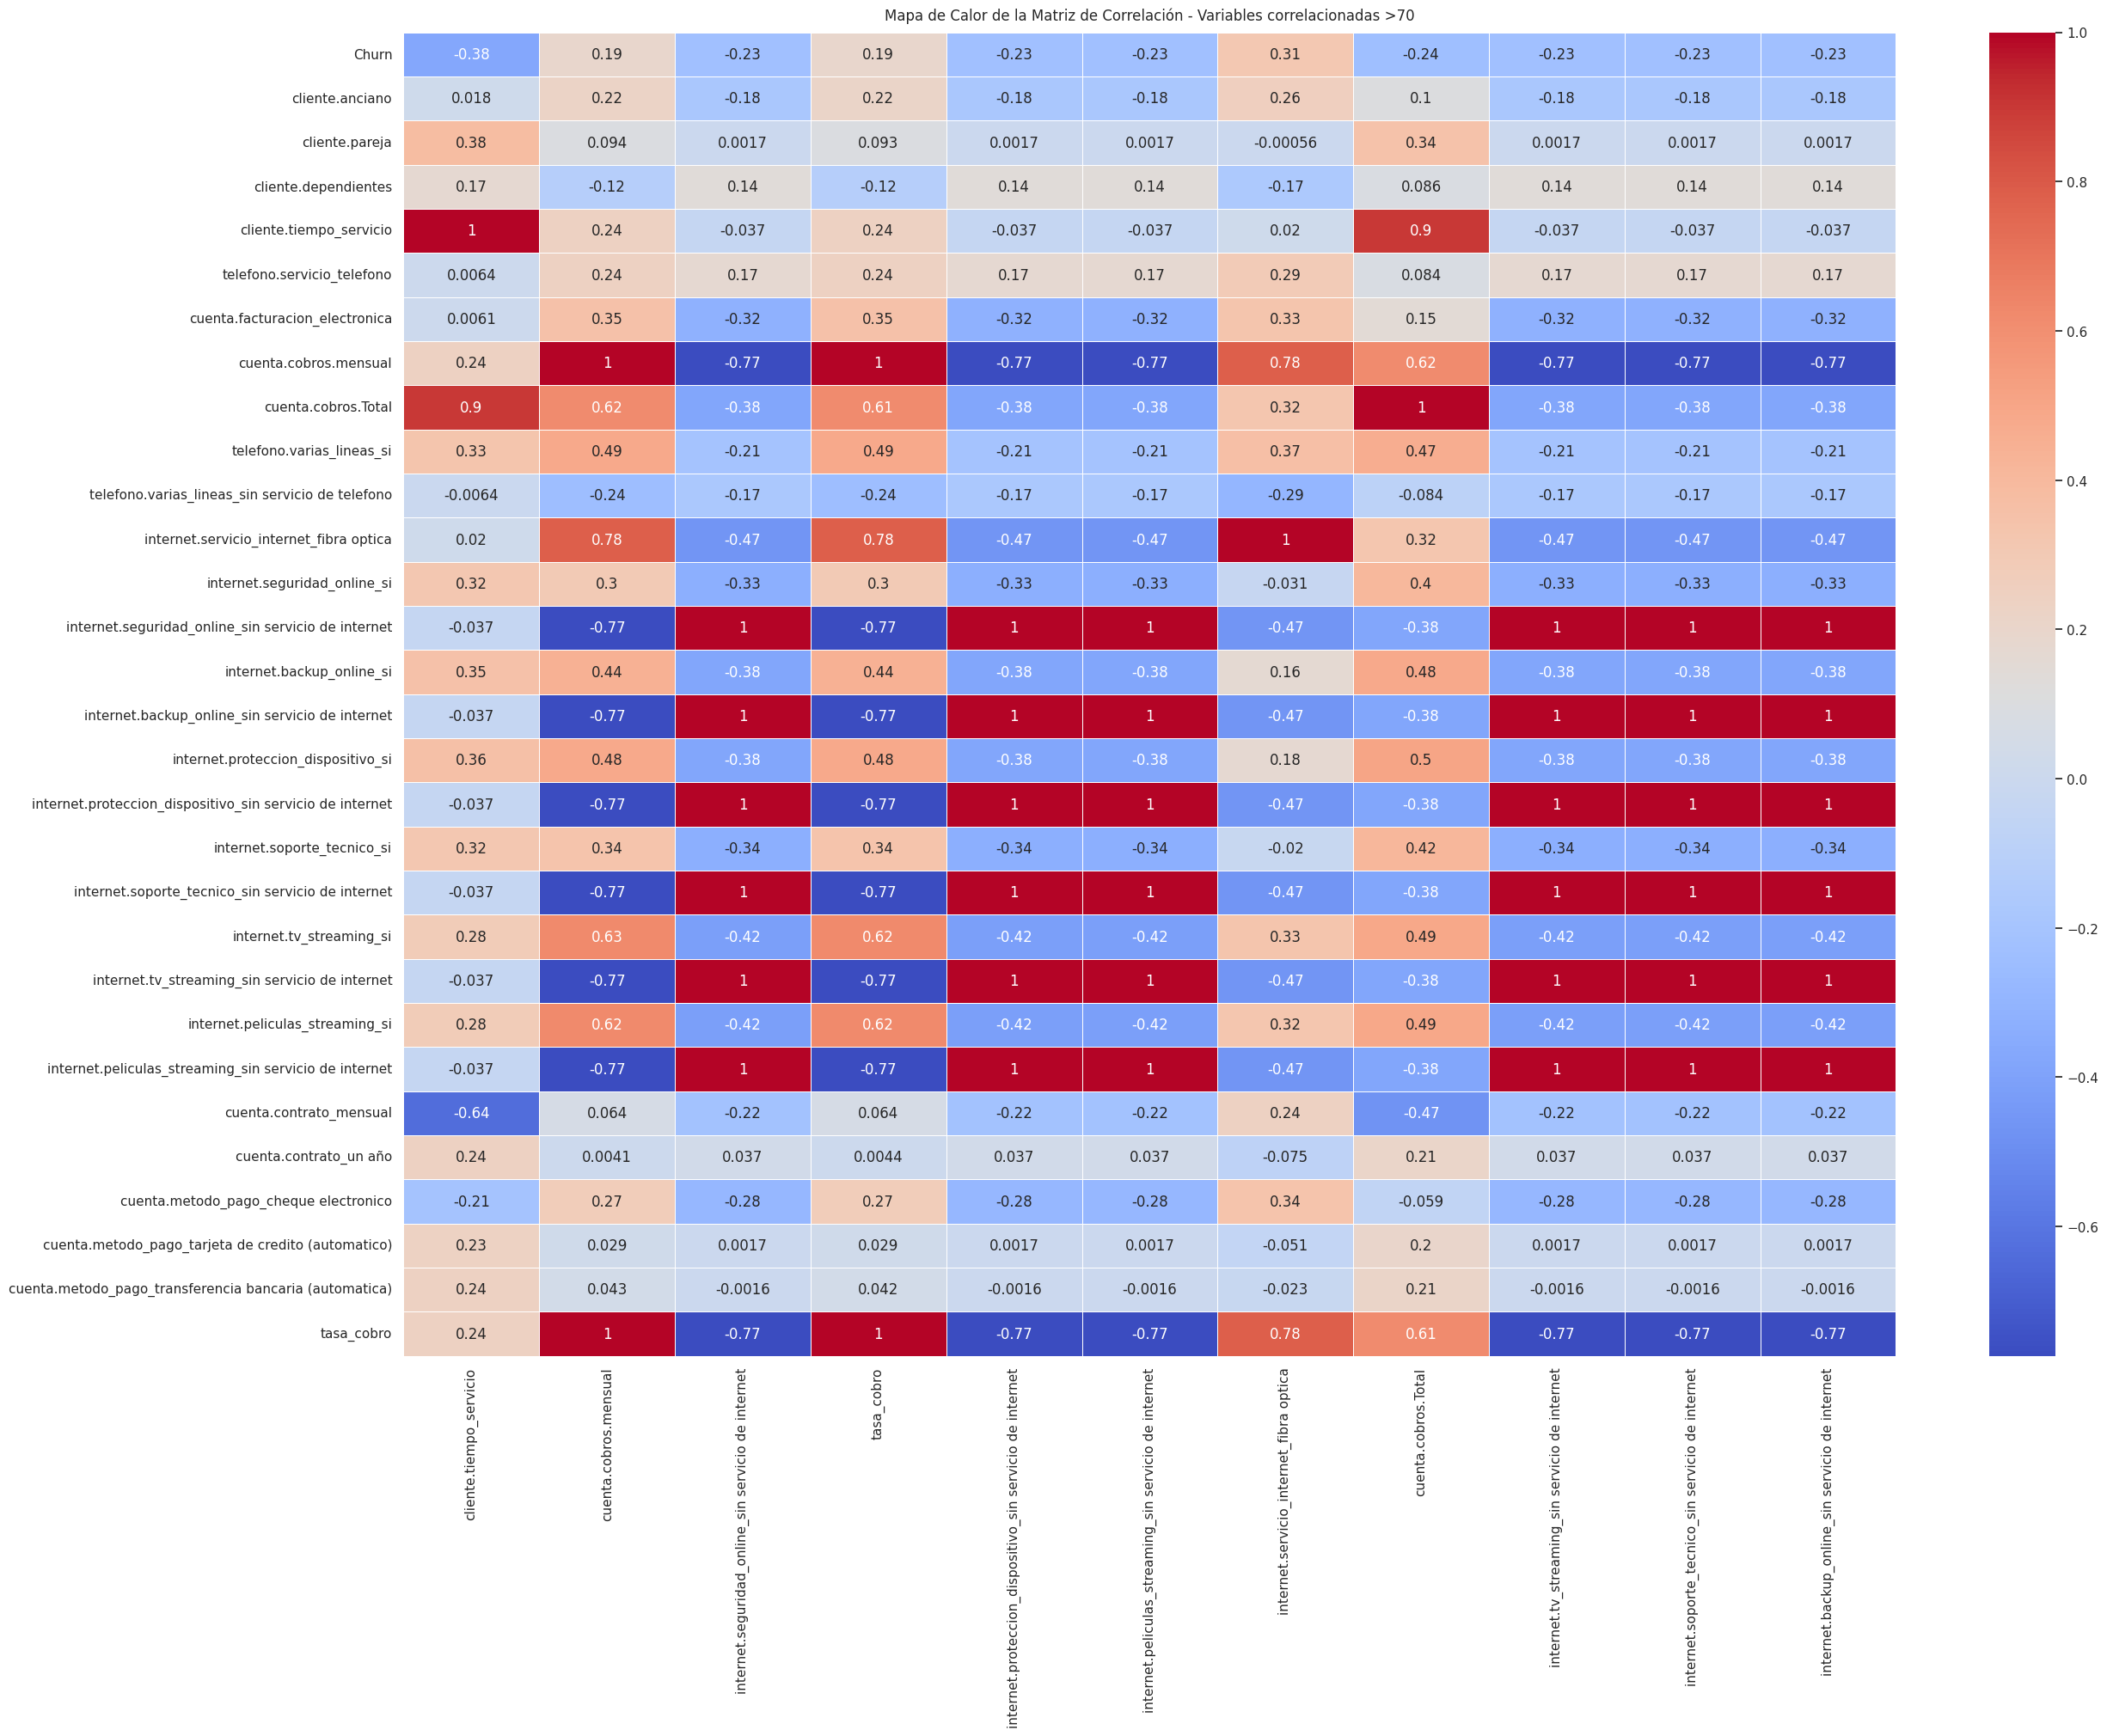

In [187]:
## Analizamos las variables que tienen mayor correlación > 70, para ver cual se puede descartar y cual mantendremos
sns.heatmap(corr_new[lista_variables_correlacionadas], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de la Matriz de Correlación - Variables correlacionadas >70', pad=10)

* Observamos que todas las variables que indican sin servicio de internet se encuentran muy correlacionadas, generando multicolinealidad en el modelo. Es por eso que decidimos descartarlos.

* Notamos también que estas variables se relacionan de cierta manera con internet fibra óptica, tasa cobro, seguridad online si, entre otras. Nos aportan mucha multicolinealidad.

* Entendemos del negocio, que normalmente las personas que tienen un servicio adicional sin tener servicio de internet, es poco probable que abandonen por ese motivo, ya que estan teniendo ventajas sin tener otro servicio adicional, asi que no aportarían valor para nuestro objetivo a determinar.

* Además notamos que tas de cobro y cobro mensual, practicamente son variables con mismos valores de correlación con las demás variables. Se considera eliminar cobro mensual, que por más que aporta cierto valor, al haber creado tasa de cobro y al aportar lo mismo, no vemos la necesidad de mantener esa variable.

* Las demás variables si bien es cierto, también tienen multicolinealidad, consideramos importante para determinar nuestra variable objetivo, consideramos no eliminarlas.


In [188]:
variables_eliminar = ['internet.backup_online_sin servicio de internet',
 'internet.proteccion_dispositivo_sin servicio de internet',
 'internet.peliculas_streaming_sin servicio de internet',
 'internet.soporte_tecnico_sin servicio de internet',
 'internet.tv_streaming_sin servicio de internet',
 'internet.seguridad_online_sin servicio de internet',
 'cuenta.cobros.mensual']

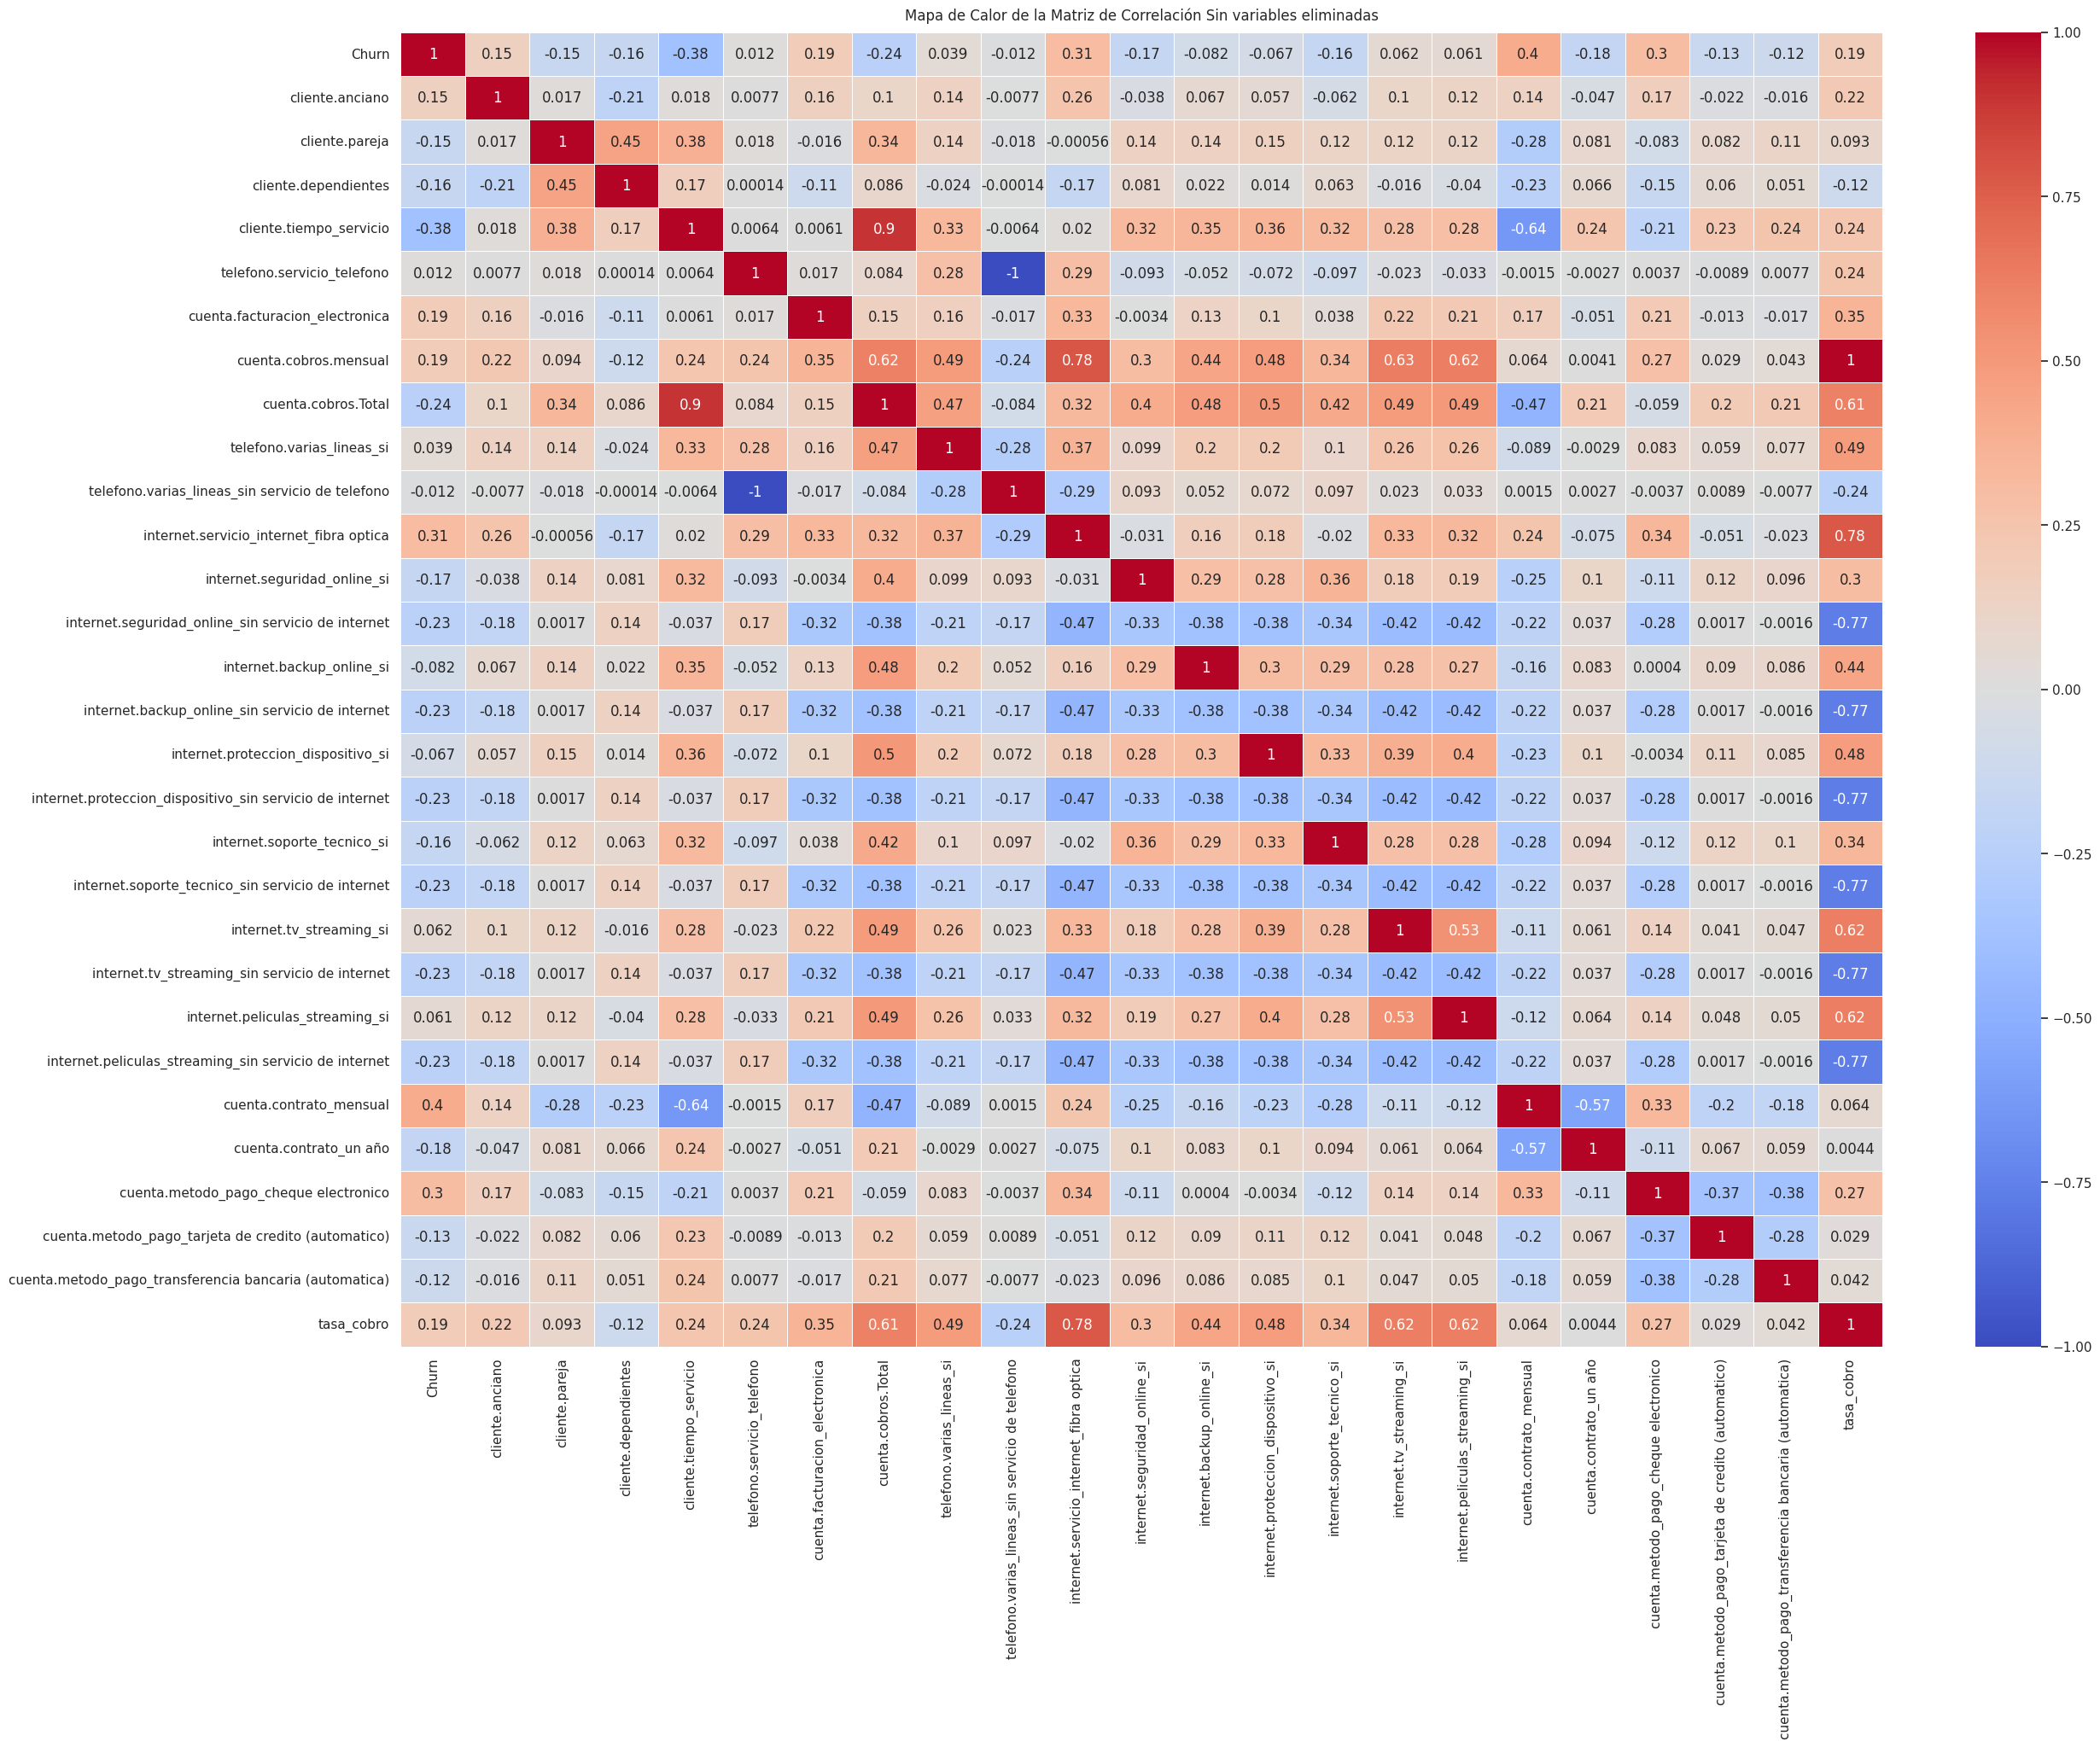

In [189]:
corr_new_2 = corr.drop(columns=variables_eliminar)
sns.heatmap(corr_new_2, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de la Matriz de Correlación Sin variables eliminadas', pad=10)
plt.show()

* Si bien es cierto, todavia existe correlación entre varais variables, pero estas correlaciones ya son menores que las que teniamos antes. Consideramos que nuestro modelo puede mejorar solo considerando estas variables.

* Tener en cuenta, que si nuestro modelo mejora o se mantiene en accuracy, también sería positivo, ya que con menos variables, se esta consiguiendo los mismo valores, y esto es beneficioso en términos de producción.

**RANDOM FOREST SIN BALANCEO**

In [190]:
from sklearn.metrics import f1_score
import time

## Aplicando el modelo Random Forest y viendo la mejora
df_heat = datos_churn_norm_2.drop(columns=variables_eliminar)

y_heat = df_heat['Churn']
x_heat = df_heat.drop(columns='Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
standar_scaler_heat = StandardScaler()
x_scaled_heat = standar_scaler_heat.fit_transform(x_heat)

x_train_heat, x_test_heat, y_train_heat, y_test_heat = train_test_split(x_scaled_heat, y_heat, test_size=0.25, random_state=42)

rf_heat = RandomForestClassifier(random_state=50)

start_time = time.time()  # Iniciar temporizador
rf_heat.fit(x_train_heat, y_train_heat)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_heat = end_time - start_time

# Evaluar el modelo en los datos de prueba
accuracy_test_heat = rf_heat.score(x_test_heat, y_test_heat)
f1_score_test_heat = f1_score(y_test_heat, rf_heat.predict(x_test_heat), average='weighted')
print(f"Accuracy: {accuracy_test_heat}")
print(f"F1-Score: {f1_score_test_heat}")
print(f"Tiempo de entrenamiento: {training_time_heat} segundos")
print(f"Número de características seleccionadas: {len(x_heat.columns)}")

Accuracy: 0.806157354618016
F1-Score: 0.7965187719944903
Tiempo de entrenamiento: 0.9829127788543701 segundos
Número de características seleccionadas: 22


* Observamos que nuestro modelo mejoró ligeramente, subiendo de 0.8044 a 0.8061

In [191]:
metricas_heat = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'Técnica': ['HeatMap'],
    'Accuracy': [accuracy_test_heat],
    'F1-Score': [f1_score_test_heat],
    'Tiempo de entrenamiento': [training_time_heat],
    '# de features': [len(x_heat.columns)]
})
metricas_heat

Modelo  Técnica  Accuracy  F1-Score  Tiempo de entrenamiento  \
0  Random Forest  HeatMap  0.806157  0.796519                 0.982913   

   # de features  
0             22

**RANDOM FOREST CON BALANCEO**

In [220]:
from imblearn.over_sampling import SMOTE
## Aplicando el modelo Random Forest y viendo la mejora
df_heat = datos_churn_norm_2.drop(columns=variables_eliminar)

y_heat = df_heat['Churn']
x_heat = df_heat.drop(columns='Churn')

## estandarizando nuestro dataframe previo a ingresarlo al modelo
standar_scaler_heat = StandardScaler()
x_scaled_heat = standar_scaler_heat.fit_transform(x_heat)

x_train_heat, x_test_heat, y_train_heat, y_test_heat = train_test_split(x_scaled_heat, y_heat, test_size=0.25, random_state=42)

# Aplicar SMOTE para balancear el conjunto de entrenamiento
smo = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smo.fit_resample(x_train_heat, y_train_heat)

rf_heat = RandomForestClassifier(random_state=50)
rf_heat.fit(x_train_balanced, y_train_balanced)

rf_heat.score(x_test_heat, y_test_heat)

0.7953249714937286

In [221]:
# Calcular y mostrar métricas
# Hacer predicciones
y_pred_train = rf_heat.predict(x_train_balanced)
y_pred_test = rf_heat.predict(x_test_heat)

train_accuracy = accuracy_score(y_train_balanced, y_pred_train)
train_f1 = f1_score(y_train_balanced, y_pred_train, average='weighted')
test_accuracy = accuracy_score(y_test_heat, y_pred_test)
test_f1 = f1_score(y_test_heat, y_pred_test, average='weighted')

print(f"Accuracy (Entrenamiento): {train_accuracy}")
print(f"F1-Score (Entrenamiento): {train_f1}")
print(f"Accuracy (Prueba): {test_accuracy}")
print(f"F1-Score (Prueba): {test_f1}")

Accuracy (Entrenamiento): 0.9981879368366554
F1-Score (Entrenamiento): 0.9981879348937827
Accuracy (Prueba): 0.7953249714937286
F1-Score (Prueba): 0.7958108674542252


##**4.3 Feature Importances**

## **4.3.1 SelectKBest:**

In [193]:
datos_churn_norm_2.shape

(7013, 30)

**SCORE FUNCTION CHI2 - DATOS NO NEGATIVOS**

In [224]:
from sklearn.metrics import f1_score
import time
from sklearn.feature_selection import SelectKBest, chi2, f_classif

x_selector = datos_churn_norm_2.drop(columns='Churn')
y_selector = datos_churn_norm_2['Churn']

## estandarizando nuestro dataframe previo a ingresarlo al modelo
# stdscaler_selector = StandardScaler()
# x_scaled_selector = stdscaler_selector.fit_transform(x_selector)

x_train_selector, x_test_selector, y_train_selector, y_test_selector = train_test_split(x_selector, y_selector, test_size=0.25, random_state=42)

selector = SelectKBest(score_func=chi2, k=23)

start_time = time.time()  # Iniciar temporizador

x_train_selector_new = selector.fit_transform(x_train_selector, y_train_selector)
x_test_selector_new = selector.transform(x_test_selector)

rf_selector = RandomForestClassifier(random_state=50)
rf_selector.fit(x_train_selector_new, y_train_selector)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_selector = end_time - start_time

# Evaluar el modelo en los datos de prueba
accuracy_selector = rf_selector.score(x_test_selector_new, y_test_selector)
f1_score_test_selector = f1_score(y_test_selector, rf_selector.predict(x_test_selector_new), average='weighted')
print(f"Accuracy: {accuracy_selector}")
print(f"F1-Score: {f1_score_test_selector}")
print(f"Tiempo de entrenamiento: {training_time_selector} segundos")
print(f"Número de características seleccionadas: {selector.k}")

Accuracy: 0.8038768529076397
F1-Score: 0.7955289982095866
Tiempo de entrenamiento: 0.7161972522735596 segundos
Número de características seleccionadas: 23


In [225]:
## Verificando el Sobreajuste

# Hacer predicciones
y_pred_train = rf_selector.predict(x_train_selector_new)
y_pred_test = rf_selector.predict(x_test_selector_new)

# Calcular y mostrar métricas
train_accuracy_selector = accuracy_score(y_train_selector, y_pred_train)
train_f1_selector = f1_score(y_train_selector, y_pred_train, average='weighted')
test_accuracy_selector = accuracy_score(y_test_selector, y_pred_test)
test_f1_selector = f1_score(y_test_selector, y_pred_test, average='weighted')

print(f"Accuracy (Entrenamiento): {train_accuracy_selector}")
print(f"F1-Score (Entrenamiento): {train_f1_selector}")
print(f"Accuracy (Prueba): {test_accuracy_selector}")
print(f"F1-Score (Prueba): {test_f1_selector}")

Accuracy (Entrenamiento): 0.9973378969385814
F1-Score (Entrenamiento): 0.9973360632428494
Accuracy (Prueba): 0.8038768529076397
F1-Score (Prueba): 0.7955289982095866


In [227]:
info_selectkbest_overfitting = {
        'Accuracy (Entrenamiento)': train_accuracy_selector,
    'F1-Score (Entrenamiento)': train_f1_selector,
    'Accuracy (Prueba)': test_accuracy_selector,
    'F1-Score (Prueba)': test_f1_selector
}
overfitting_metrics_selectkbest = pd.DataFrame(info_selectkbest_overfitting, index=['SelectKBest'])
overfitting_metrics_selectkbest

Accuracy (Entrenamiento)  F1-Score (Entrenamiento)  \
SelectKBest                  0.997338                  0.997336   

             Accuracy (Prueba)  F1-Score (Prueba)  
SelectKBest           0.803877           0.795529

In [195]:
# Obtener las puntuaciones de cada característica
feature_scores = selector.scores_

# Crear un DataFrame para ver las puntuaciones junto a los nombres de las características
feature_importances = pd.DataFrame({'Feature': x_selector.columns, 'Score': feature_scores})

# Ordenar por las puntuaciones más altas
feature_importances = feature_importances.sort_values(by='Score', ascending=False)

# Mostrar las características más relevantes
print(feature_importances)

                                              Feature        Score
6                               cuenta.cobros.mensual  2012.944681
28                                         tasa_cobro  1909.478789
3                             cliente.tiempo_servicio  1834.042148
7                                 cuenta.cobros.Total   956.287029
23                            cuenta.contrato_mensual   385.688176
25              cuenta.metodo_pago_cheque electronico   316.272348
10            internet.servicio_internet_fibra optica   292.091026
18  internet.soporte_tecnico_sin servicio de internet   208.809863
22  internet.peliculas_streaming_sin servicio de i...   208.809863
14    internet.backup_online_sin servicio de internet   208.809863
20     internet.tv_streaming_sin servicio de internet   208.809863
16  internet.proteccion_dispositivo_sin servicio d...   208.809863
12  internet.seguridad_online_sin servicio de inte...   208.809863
24                             cuenta.contrato_un año   127.74

* Notamos que para 23 características funciona muy bien el modelo. Si bien es cierto que para 29 o 30 variables, el modelo nos da 0.8044, con menos variables conseguimos casi los mismos niveles, lo cual resultará en menos coste computacional.

In [228]:
metricas_selector = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'Técnica': ['SelectKBest'],
    'Accuracy': [accuracy_selector],
    'F1-Score': [f1_score_test_selector],
    'Tiempo de entrenamiento': [training_time_selector],
    '# de features': [selector.k]
})
metricas_selector

Modelo      Técnica  Accuracy  F1-Score  Tiempo de entrenamiento  \
0  Random Forest  SelectKBest  0.803877  0.795529                 0.716197   

   # de features  
0             23

**CON BALANCEO DE DATOS**

In [197]:

# Separar las características y la variable objetivo
x_selector = datos_churn_norm_2.drop(columns='Churn')
y_selector = datos_churn_norm_2['Churn']

# Dividir el conjunto de datos en entrenamiento y prueba
x_train_selector, x_test_selector, y_train_selector, y_test_selector = train_test_split(x_selector, y_selector, test_size=0.25, random_state=42)

# Aplicar SMOTE para balancear los datos de entrenamiento
smo = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smo.fit_resample(x_train_selector, y_train_selector)

# Estandarizar los datos (opcional, descomentar si es necesario)
# stdscaler_selector = StandardScaler()
# x_train_balanced = stdscaler_selector.fit_transform(x_train_balanced)
# x_test_selector = stdscaler_selector.transform(x_test_selector)

# Aplicar SelectKBest para seleccionar las mejores características
selector = SelectKBest(score_func=chi2, k=23)
x_train_selector_new = selector.fit_transform(x_train_balanced, y_train_balanced)
x_test_selector_new = selector.transform(x_test_selector)

# Entrenar el modelo Random Forest
rf_selector = RandomForestClassifier(random_state=50)
rf_selector.fit(x_train_selector_new, y_train_balanced)

# Evaluar el modelo en los datos de prueba
accuracy = rf_selector.score(x_test_selector_new, y_test_selector)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7850627137970353


**CON HIPERPARÁMETROS**

{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

In [230]:
from sklearn.metrics import f1_score
import time
from sklearn.feature_selection import SelectKBest, chi2, f_classif

x_selector = datos_churn_norm_2.drop(columns='Churn')
y_selector = datos_churn_norm_2['Churn']

x_train_selector, x_test_selector, y_train_selector, y_test_selector = train_test_split(x_selector, y_selector, test_size=0.25, random_state=42)

selector = SelectKBest(score_func=chi2, k=23)

start_time = time.time()  # Iniciar temporizador

x_train_selector_new = selector.fit_transform(x_train_selector, y_train_selector)
x_test_selector_new = selector.transform(x_test_selector)

rf_selector = RandomForestClassifier(random_state=50,
                                     n_estimators=200,
                                     max_depth=10,
                                     min_samples_leaf=2,
                                     min_samples_split=10,
                                     bootstrap=True)
rf_selector.fit(x_train_selector_new, y_train_selector)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_selector = end_time - start_time

# Evaluar el modelo en los datos de prueba
accuracy_selector = rf_selector.score(x_test_selector_new, y_test_selector)
f1_score_test_selector = f1_score(y_test_selector, rf_selector.predict(x_test_selector_new), average='weighted')
print(f"Accuracy: {accuracy_selector}")
print(f"F1-Score: {f1_score_test_selector}")
print(f"Tiempo de entrenamiento: {training_time_selector} segundos")
print(f"Número de características seleccionadas: {selector.k}")

Accuracy: 0.8118586088939567
F1-Score: 0.8051321014871436
Tiempo de entrenamiento: 1.6277697086334229 segundos
Número de características seleccionadas: 23


In [231]:
## Verificando el Sobreajuste

# Hacer predicciones
y_pred_train = rf_selector.predict(x_train_selector_new)
y_pred_test = rf_selector.predict(x_test_selector_new)

# Calcular y mostrar métricas
train_accuracy_hiper = accuracy_score(y_train_selector, y_pred_train)
train_f1_hiper = f1_score(y_train_selector, y_pred_train, average='weighted')
test_accuracy_hiper = accuracy_score(y_test_selector, y_pred_test)
test_f1_hiper = f1_score(y_test_selector, y_pred_test, average='weighted')

print(f"Accuracy (Entrenamiento): {train_accuracy_hiper}")
print(f"F1-Score (Entrenamiento): {train_f1_hiper}")
print(f"Accuracy (Prueba): {test_accuracy_hiper}")
print(f"F1-Score (Prueba): {test_f1_hiper}")

Accuracy (Entrenamiento): 0.8497813272485263
F1-Score (Entrenamiento): 0.8440361240920997
Accuracy (Prueba): 0.8118586088939567
F1-Score (Prueba): 0.8051321014871436


In [232]:
info_selectkbest_overfitting_hiper = {
        'Accuracy (Entrenamiento)': train_accuracy_hiper,
    'F1-Score (Entrenamiento)': train_f1_hiper,
    'Accuracy (Prueba)': test_accuracy_hiper,
    'F1-Score (Prueba)': test_f1
        }

overfitting_metrics_selectkbest_hiper = pd.DataFrame(info_selectkbest_overfitting_hiper, index=['SelectKBest Hiper'])
overfitting_metrics_selectkbest_hiper

Accuracy (Entrenamiento)  F1-Score (Entrenamiento)  \
SelectKBest Hiper                  0.849781                  0.844036   

                   Accuracy (Prueba)  F1-Score (Prueba)  
SelectKBest Hiper           0.811859           0.805132

In [235]:
## Concatenando

overfitting_metrics_selectkbest_concat = pd.concat([overfitting_metrics_selectkbest, overfitting_metrics_selectkbest_hiper])
overfitting_metrics_selectkbest_concat

Accuracy (Entrenamiento)  F1-Score (Entrenamiento)  \
SelectKBest                        0.997338                  0.997336   
SelectKBest Hiper                  0.849781                  0.844036   

                   Accuracy (Prueba)  F1-Score (Prueba)  
SelectKBest                 0.803877           0.795529  
SelectKBest Hiper           0.811859           0.805132

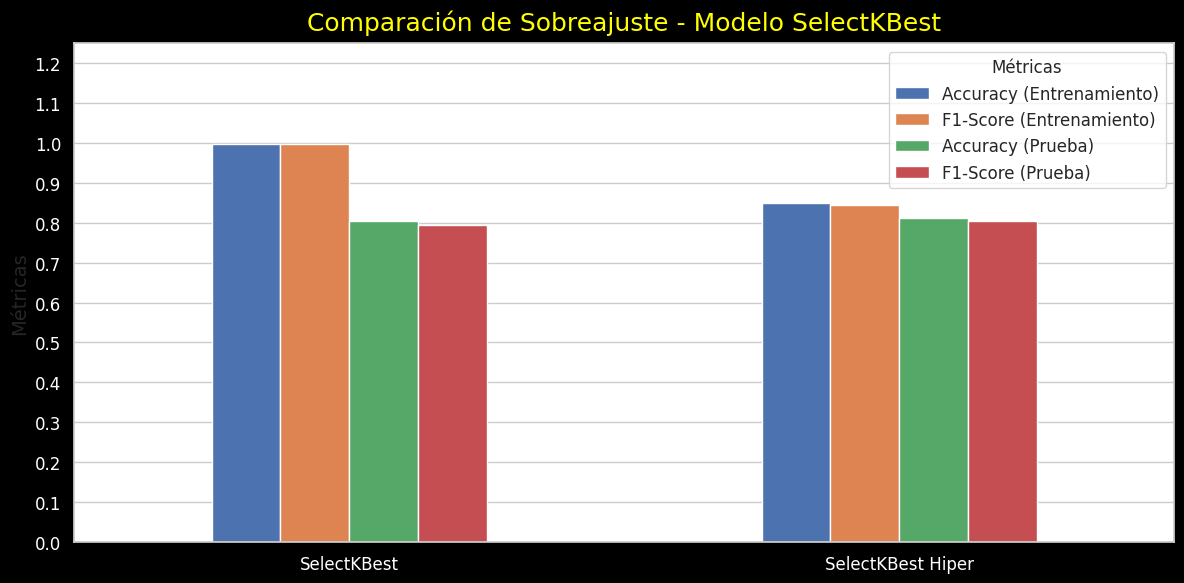

In [262]:
# Graficar
ax = overfitting_metrics_selectkbest_concat.plot(kind='bar', figsize=(12, 6))

# Personalizar gráfico
plt.title('Comparación de Sobreajuste - Modelo SelectKBest', fontsize=18, pad=10, color = 'yellow')
plt.ylabel('Métricas', fontsize=14)
plt.xticks(rotation=0)  # Para que las etiquetas del eje x no se giren
plt.legend(title='Métricas', fontsize=12, loc = 'upper right')
plt.grid(axis='x')
plt.ylim(0,1.25)
plt.tick_params(axis='both', labelsize=12, colors= 'white')
# Definir ticks del eje y de 0 a 1.2 con incrementos de 0.1
plt.yticks([i * 0.1 for i in range(13)], fontsize=12, color='white')  # De 0 a 1.2

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('black')
plt.gcf().set_edgecolor('black')

# Mostrar gráfico
plt.tight_layout()
plt.show()

## **4.3.2 RFE (Recursive Feature Elimination):**

**SIN BALANCEO DE DATOS**

In [198]:
import time
from sklearn.metrics import f1_score
# Separar las características y la variable objetivo
x_rfe = datos_churn_norm_2.drop(columns='Churn')
y_rfe = datos_churn_norm_2['Churn']

x_train_rfe, x_test_rfe, y_train_rfe, y_test_rfe = train_test_split(x_rfe, y_rfe, test_size=0.25, random_state=42)

model = RandomForestClassifier(random_state=50)
selector = RFE(estimator = model, n_features_to_select=18)

# Medir el tiempo de ajuste del modelo
start_time = time.time()  # Iniciar temporizador

x_train_rfe_new = selector.fit_transform(x_train_rfe, y_train_rfe)
x_test_rfe_new = selector.transform(x_test_rfe)

model.fit(x_train_rfe_new, y_train_rfe)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_rfe = end_time - start_time

accuracy_rfe = model.score(x_test_rfe_new, y_test_rfe)
f1_score_test_rfe = f1_score(y_test_rfe, model.predict(x_test_rfe_new), average='weighted')
print(f"Accuracy: {accuracy_rfe}")
print(f"F1-Score: {f1_score_test_rfe}")
print(f"Tiempo de entrenamiento: {training_time_rfe} segundos")
print(f"Número de características seleccionadas: {selector.n_features_}")

Accuracy: 0.8101482326111744
F1-Score: 0.8012012925026922
Tiempo de entrenamiento: 10.047680854797363 segundos
Número de características seleccionadas: 18


In [199]:
# Obtener los índices de las características seleccionadas
selected_features_indices = selector.get_support(indices=True)

# Obtener los nombres de las características seleccionadas
selected_features = x_rfe.columns[selected_features_indices]

print(f"Características seleccionadas por RFE: {selected_features}")

Características seleccionadas por RFE: Index(['cliente.anciano', 'cliente.pareja', 'cliente.dependientes',
       'cliente.tiempo_servicio', 'cuenta.facturacion_electronica',
       'cuenta.cobros.mensual', 'cuenta.cobros.Total',
       'telefono.varias_lineas_si', 'internet.servicio_internet_fibra optica',
       'internet.seguridad_online_si', 'internet.backup_online_si',
       'internet.proteccion_dispositivo_si', 'internet.soporte_tecnico_si',
       'internet.tv_streaming_si', 'internet.peliculas_streaming_si',
       'cuenta.contrato_mensual', 'cuenta.metodo_pago_cheque electronico',
       'tasa_cobro'],
      dtype='object')


In [200]:
metricas_rfe = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'Técnica': ['RFE'],
    'Accuracy': [accuracy_rfe],
    'F1-Score': [f1_score_test_rfe],
    'Tiempo de entrenamiento': [training_time_rfe],
    '# de features': [selector.n_features_]
})

metricas_rfe

Modelo Técnica  Accuracy  F1-Score  Tiempo de entrenamiento  \
0  Random Forest     RFE  0.810148  0.801201                10.047681   

   # de features  
0             18

**CON BALANCEO DE DATOS**

In [201]:
import time
from sklearn.metrics import f1_score
# Separar las características y la variable objetivo
x_rfe = datos_churn_norm_2.drop(columns='Churn')
y_rfe = datos_churn_norm_2['Churn']

x_train_rfe, x_test_rfe, y_train_rfe, y_test_rfe = train_test_split(x_rfe, y_rfe, test_size=0.25, random_state=42)

model = RandomForestClassifier(random_state=50)
selector = RFE(estimator = model, n_features_to_select=18)

# Aplicar SMOTE para balancear los datos de entrenamiento
smo = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smo.fit_resample(x_train_rfe, y_train_rfe)

# Medir el tiempo de ajuste del modelo
start_time = time.time()  # Iniciar temporizador

x_train_rfe_new = selector.fit_transform(x_train_balanced, y_train_balanced)
x_test_rfe_new = selector.transform(x_test_rfe)

model.fit(x_train_rfe_new, y_train_balanced)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time = end_time - start_time

accuracy_rfe = model.score(x_test_rfe_new, y_test_rfe)
f1_score_test = f1_score(y_test_rfe, model.predict(x_test_rfe_new), average='weighted')
print(f"Accuracy: {accuracy_rfe}")
print(f"F1-Score: {f1_score_test}")
print(f"Tiempo de entrenamiento: {training_time} segundos")
print(f"Número de características seleccionadas: {selector.n_features_}")

Accuracy: 0.7873432155074116
F1-Score: 0.787848060056897
Tiempo de entrenamiento: 13.6382737159729 segundos
Número de características seleccionadas: 18


## **4.3.3 PCA (Principal Component Analysis):**

**SIN BALANCEO DE DATOS**

In [249]:
import time
from sklearn.metrics import f1_score
# Separar las características y la variable objetivo
x_pca = datos_churn_norm_2.drop(columns='Churn')
y_pca = datos_churn_norm_2['Churn']

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y_pca, test_size=0.25, random_state=42)

pca = PCA(n_components=9)

start_time = time.time()  # Iniciar temporizador

x_train_pca_new = pca.fit_transform(x_train_pca)
x_test_pca_new = pca.transform(x_test_pca)

model = RandomForestClassifier(random_state=50)
model.fit(x_train_pca_new, y_train_pca)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_pca = end_time - start_time

score_test_pca = model.score(x_test_pca_new, y_test_pca)
f1_score_test_pca = f1_score(y_test_pca, model.predict(x_test_pca_new), average='weighted')
print(f"Accuracy: {score_test_pca}")
print(f"F1-Score: {f1_score_test_pca}")
print(f"Tiempo de entrenamiento: {training_time_pca} segundos")
print(f"Número de características seleccionadas: {pca.n_components_}")

Accuracy: 0.8027366020524516
F1-Score: 0.7925113791074726
Tiempo de entrenamiento: 1.779294490814209 segundos
Número de características seleccionadas: 9


* Si bien es cierto, quizás bajo un poco la precisión con este modelo, pero tener en cuenta que solo estamos usando 9 componentes, los cuales nos ayudarían si estamos en ambientes de producción con muchos datos. Asimismo, notamos que el tiempo de entrenamiento del modelo con la cantidad de datos que poseemos es de 2.96 segundos, el cual es mucho menor que el de RFE.

In [250]:
metricas_pca = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'Técnica': ['PCA'],
    'Accuracy': [score_test_pca],
    'F1-Score': [f1_score_test_pca],
    'Tiempo de entrenamiento': [training_time_pca],
    '# de features': [pca.n_components_]
})
metricas_pca

Modelo Técnica  Accuracy  F1-Score  Tiempo de entrenamiento  \
0  Random Forest     PCA  0.802737  0.792511                 1.779294   

   # de features  
0              9

In [251]:
## VERIFICANDO EL SOBREAJUSTE

y_pred_train = model.predict(x_train_pca_new)
y_pred_test = model.predict(x_test_pca_new)

accuracy_train = accuracy_score(y_train_pca, y_pred_train)
f1_score_train = f1_score(y_train_pca, y_pred_train, average='weighted')
accuracy_test = accuracy_score(y_test_pca, y_pred_test)
f1_score_test = f1_score(y_test_pca, y_pred_test, average='weighted')

print(f"Accuracy (Entrenamiento): {accuracy_train}")
print(f"F1-Score (Entrenamiento): {f1_score_train}")
print(f"Accuracy (Prueba): {accuracy_test}")
print(f"F1-Score (Prueba): {f1_score_test}")

Accuracy (Entrenamiento): 0.9973378969385814
F1-Score (Entrenamiento): 0.9973366760238379
Accuracy (Prueba): 0.8027366020524516
F1-Score (Prueba): 0.7925113791074726


In [252]:
overfitting_metrics_pca = {
        'Accuracy (Entrenamiento)': accuracy_train,
    'F1-Score (Entrenamiento)': f1_score_train,
    'Accuracy (Prueba)': accuracy_test,
    'F1-Score (Prueba)': f1_score_test
        }

overfitting_metrics_pca = pd.DataFrame(overfitting_metrics_pca, index=['PCA'])
overfitting_metrics_pca

Accuracy (Entrenamiento)  F1-Score (Entrenamiento)  Accuracy (Prueba)  \
PCA                  0.997338                  0.997337           0.802737   

     F1-Score (Prueba)  
PCA           0.792511

**CON BALANCEO DE DATOS**

In [204]:
import time
from sklearn.metrics import f1_score
# Separar las características y la variable objetivo
x_pca = datos_churn_norm_2.drop(columns='Churn')
y_pca = datos_churn_norm_2['Churn']

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y_pca, test_size=0.25, random_state=42)

pca = PCA(n_components=7)

# Aplicar SMOTE para balancear los datos de entrenamiento
smo = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smo.fit_resample(x_train_pca, y_train_pca)

start_time = time.time()  # Iniciar temporizador

x_train_pca_new = pca.fit_transform(x_train_balanced)
x_test_pca_new = pca.transform(x_test_pca)

model = RandomForestClassifier(random_state=50)
model.fit(x_train_pca_new, y_train_balanced)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time = end_time - start_time

score_test = model.score(x_test_pca_new, y_test_pca)
f1_score_test = f1_score(y_test_pca, model.predict(x_test_pca_new), average='weighted')
print(f"Accuracy: {score_test}")
print(f"F1-Score: {f1_score_test}")
print(f"Tiempo de entrenamiento: {training_time} segundos")
print(f"Número de características seleccionadas: {pca.n_components_}")

Accuracy: 0.7810718358038768
F1-Score: 0.7866657396466169
Tiempo de entrenamiento: 1.8529963493347168 segundos
Número de características seleccionadas: 7


* f1_score(y_test_rfe, y_pred_rfe, average='weighted'): Calcula el F1-score usando las etiquetas reales (y_test_rfe) y las predicciones del modelo (y_pred_rfe).
1. average='weighted': Calcula el F1-score ponderado teniendo en cuenta el soporte (número de muestras de cada clase). Es útil para clases desbalanceadas.
2. average='binary': Se usa para problemas de clasificación binaria.
3. average='macro': Calcula el F1-score de cada clase y devuelve la media (sin ponderación por clase).
4. average='micro': Calcula las métricas globalmente (considerando el total de verdaderos positivos, falsos negativos y falsos positivos).

**CON HIPERPARÁMETROS**

{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

In [256]:
import time
from sklearn.metrics import f1_score
# Separar las características y la variable objetivo
x_pca = datos_churn_norm_2.drop(columns='Churn')
y_pca = datos_churn_norm_2['Churn']

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y_pca, test_size=0.25, random_state=42)

pca = PCA(n_components=9)

start_time = time.time()  # Iniciar temporizador

x_train_pca_new = pca.fit_transform(x_train_pca)
x_test_pca_new = pca.transform(x_test_pca)

model = RandomForestClassifier(random_state=50,
                               max_depth=10,
                               min_samples_leaf=2,
                               min_samples_split=10,
                               n_estimators=200,
                               bootstrap=True)

model.fit(x_train_pca_new, y_train_pca)

end_time = time.time()  # Finalizar temporizador

# Calcular el tiempo total en segundos
training_time_pca = end_time - start_time

score_test_pca = model.score(x_test_pca_new, y_test_pca)
f1_score_test_pca = f1_score(y_test_pca, model.predict(x_test_pca_new), average='weighted')
print(f"Accuracy: {score_test_pca}")
print(f"F1-Score: {f1_score_test_pca}")
print(f"Tiempo de entrenamiento: {training_time_pca} segundos")
print(f"Número de características seleccionadas: {pca.n_components_}")

Accuracy: 0.80672748004561
F1-Score: 0.7961907850554154
Tiempo de entrenamiento: 2.8073952198028564 segundos
Número de características seleccionadas: 9


In [257]:
## VERIFICANDO EL SOBREAJUSTE

y_pred_train = model.predict(x_train_pca_new)
y_pred_test = model.predict(x_test_pca_new)

accuracy_train_hiper = accuracy_score(y_train_pca, y_pred_train)
f1_score_train_hiper = f1_score(y_train_pca, y_pred_train, average='weighted')
accuracy_test_hiper = accuracy_score(y_test_pca, y_pred_test)
f1_score_test_hiper = f1_score(y_test_pca, y_pred_test, average='weighted')

print(f"Accuracy (Entrenamiento): {accuracy_train_hiper}")
print(f"F1-Score (Entrenamiento): {f1_score_train_hiper}")
print(f"Accuracy (Prueba): {accuracy_test_hiper}")
print(f"F1-Score (Prueba): {f1_score_test_hiper}")

Accuracy (Entrenamiento): 0.8796349115801483
F1-Score (Entrenamiento): 0.8740129060847145
Accuracy (Prueba): 0.80672748004561
F1-Score (Prueba): 0.7961907850554154


In [258]:
overfitting_metrics_pca_hiper = {
        'Accuracy (Entrenamiento)': accuracy_train_hiper,
    'F1-Score (Entrenamiento)': f1_score_train_hiper,
    'Accuracy (Prueba)': accuracy_test_hiper,
    'F1-Score (Prueba)': f1_score_test_hiper
        }

overfitting_metrics_pca_hiper = pd.DataFrame(overfitting_metrics_pca_hiper, index=['PCA Hiper'])
overfitting_metrics_pca_hiper

Accuracy (Entrenamiento)  F1-Score (Entrenamiento)  \
PCA Hiper                  0.879635                  0.874013   

           Accuracy (Prueba)  F1-Score (Prueba)  
PCA Hiper           0.806727           0.796191

In [259]:
## PCA concat Overfitting
overfitting_metrics_pca_concat = pd.concat([overfitting_metrics_pca, overfitting_metrics_pca_hiper])
overfitting_metrics_pca_concat

Accuracy (Entrenamiento)  F1-Score (Entrenamiento)  \
PCA                        0.997338                  0.997337   
PCA Hiper                  0.879635                  0.874013   

           Accuracy (Prueba)  F1-Score (Prueba)  
PCA                 0.802737           0.792511  
PCA Hiper           0.806727           0.796191

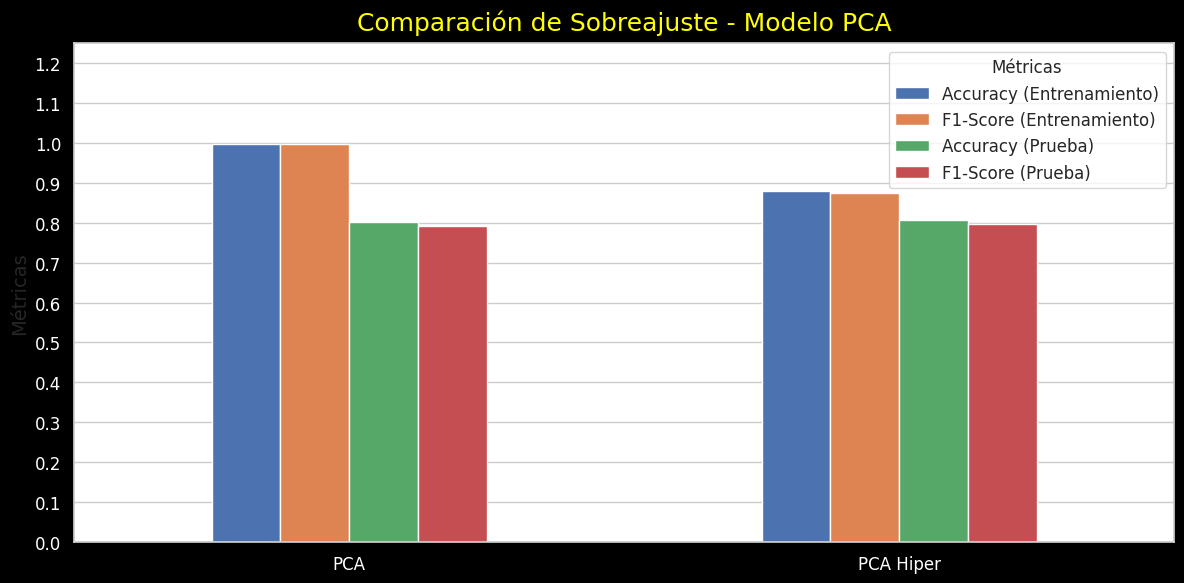

In [261]:
## Graficando
# Graficar
ax = overfitting_metrics_pca_concat.plot(kind='bar', figsize=(12, 6))

# Personalizar gráfico
plt.title('Comparación de Sobreajuste - Modelo PCA', fontsize=18, pad=10, color = 'yellow')
plt.ylabel('Métricas', fontsize=14)
plt.xticks(rotation=0)  # Para que las etiquetas del eje x no se giren
plt.legend(title='Métricas', fontsize=12, loc = 'upper right')
plt.grid(axis='x')
plt.ylim(0,1.25)
plt.tick_params(axis='both', labelsize=12, colors= 'white')
# Definir ticks del eje y de 0 a 1.2 con incrementos de 0.1
plt.yticks([i * 0.1 for i in range(13)], fontsize=12, color='white')  # De 0 a 1.2

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('black')
plt.gcf().set_edgecolor('black')

# Mostrar gráfico
plt.tight_layout()
plt.show()

# **5. COMPARANDO MODELOS DE RANDON FOREST - TODAS LAS TÉCNICAS**

* Hemos observado que hemos obtenido mejores resultados con nuestra data desbalanceada, de acuerdo a nuestro análisis desarrollado en las partes iniciales.

* Se han considerado tres métricas para evaluar nuestros modelos, para todas las técnicas utilizadas. Estas métricas son: Accuracy, F1-score y time de entrenamiento modelo.

* El tiempo de ejecución del entrenamiento es importante por si se requiere escalar el proyecto. Por ejemplo si queremos trabajar con data real, que nos ingresa continuamente, ya que cada cierto periodo de tiempo se requerirá reentrenar el modelo, y de acuerdo a la cantidad de datos, consideramos que este aspecto es muy importante.

In [263]:
metricas = pd.concat([metricas_propio, metricas_grafic, metricas_heat, metricas_selector, metricas_rfe, metricas_pca], ignore_index=True)
metricas

Modelo              Técnica  Accuracy  F1-Score  \
0  Random Forest  Feature_engineering  0.804447  0.795829   
1  Random Forest             Graficos  0.799886  0.791666   
2  Random Forest              HeatMap  0.806157  0.796519   
3  Random Forest          SelectKBest  0.803877  0.795529   
4  Random Forest                  RFE  0.810148  0.801201   
5  Random Forest                  PCA  0.802737  0.792511   

   Tiempo de entrenamiento  # de features  
0                 0.674471             29  
1                 1.113941             26  
2                 0.982913             22  
3                 0.716197             23  
4                10.047681             18  
5                 1.779294              9

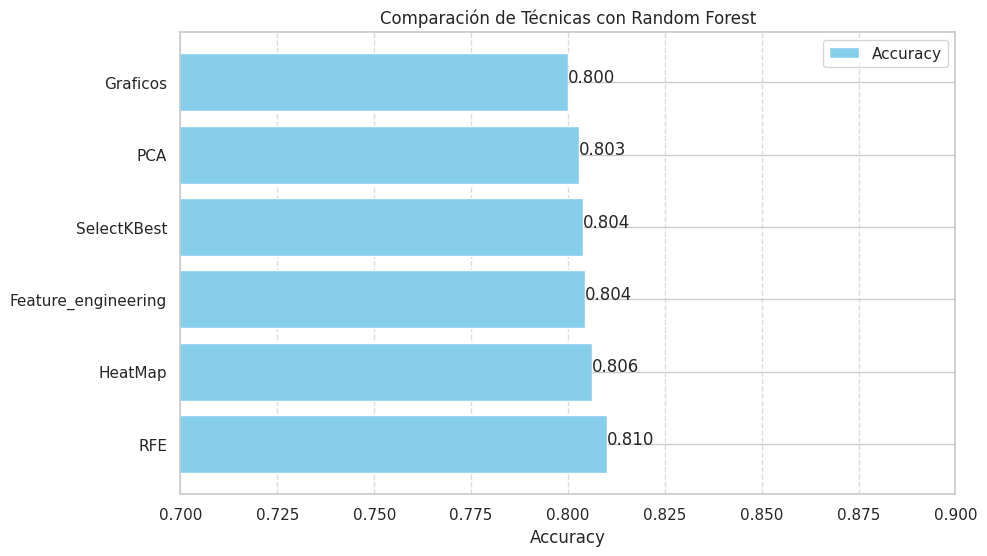

In [264]:
# Ordenar el DataFrame por Accuracy
df_sorted = metricas.sort_values(by='Accuracy', ascending=False)

# Configurar el gráfico de barras
plt.figure(figsize=(10, 6))

# Gráfico de barras para Accuracy
plt.barh(df_sorted['Técnica'], df_sorted['Accuracy'], color='skyblue', label='Accuracy')

# Añadir etiquetas
plt.xlabel('Accuracy')
plt.title('Comparación de Técnicas con Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0.7, 0.9)  # Ajusta los límites según tu rango de datos

# Mostrar valores encima de las barras
for index, value in enumerate(df_sorted['Accuracy']):
    plt.text(value, index, f"{value:.3f}")

plt.legend()
plt.show()

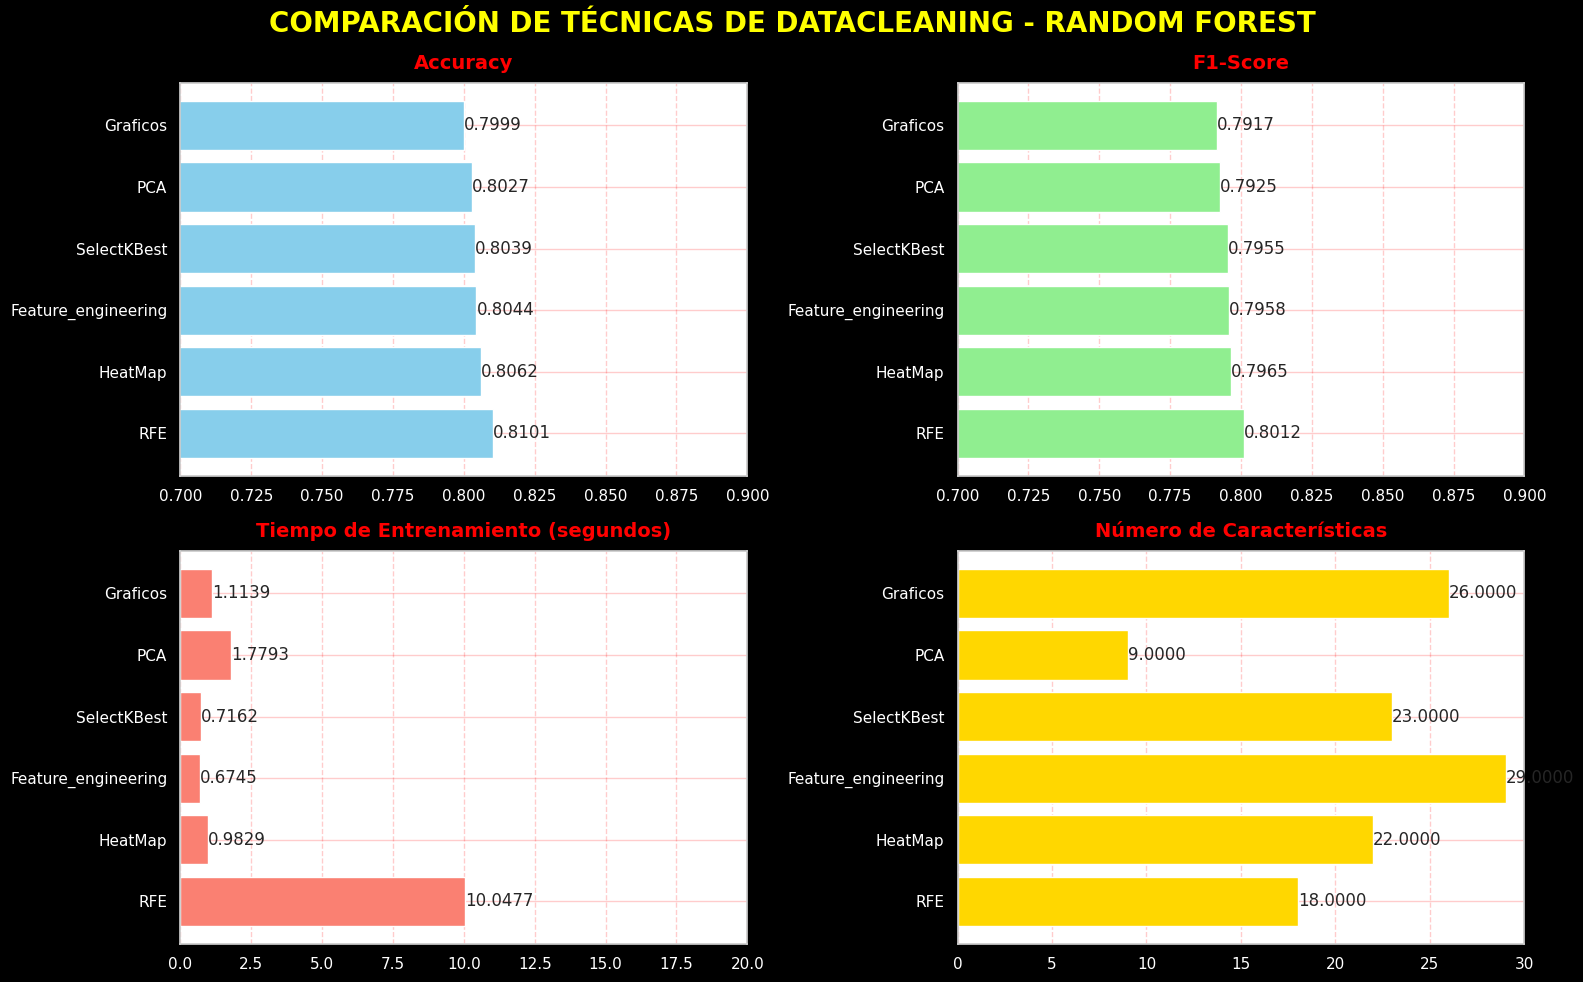

In [265]:
# Ordenar el DataFrame por Accuracy
df_sorted = metricas.sort_values(by='Accuracy', ascending=False)

# Crear subgráficos
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('COMPARACIÓN DE TÉCNICAS DE DATACLEANING - RANDOM FOREST',
             fontsize=20,
             color='yellow',
             fontweight='bold')

# Configuraciones para ticks
tick_params_config = {
    'axis': 'both',        # Afecta tanto a x como y
    'labelcolor': 'white', # Color de las etiquetas
    'width': 2,            # Grosor de los ticks
    'colors': 'red',         # Color de los ticks
    'grid_color': 'red',     # Color de las líneas de la rejilla
    'grid_alpha': 0.2      # Transparencia de la rejilla
}

# Gráfico 1: Accuracy
axs[0, 0].barh(df_sorted['Técnica'], df_sorted['Accuracy'], color='skyblue')
axs[0, 0].set_title('Accuracy', color = 'red', fontsize=14, fontweight='heavy', pad=10)
axs[0, 0].set_xlim(0.7, 0.9)
axs[0, 0].grid(axis='x', color='red', linestyle='--', alpha=0.2)
axs[0, 0].grid(axis='x', color='red', linestyle='--', alpha=0.2)  # Agregar rejilla horizontal
axs[0, 0].tick_params(**tick_params_config)  # Aplicar tick_params

# Gráfico 2: F1-Score
axs[0, 1].barh(df_sorted['Técnica'], df_sorted['F1-Score'], color='lightgreen')
axs[0, 1].set_title('F1-Score', color = 'red', fontsize=14, fontweight='heavy', pad=10)
axs[0, 1].set_xlim(0.7, 0.9)
axs[0, 1].grid(axis='x', color='red', linestyle='--', alpha=0.2)
# axs[0, 1].grid(axis='x', linestyle='--', alpha=0.7)
axs[0, 1].tick_params(**tick_params_config)  # Aplicar tick_params

# Gráfico 3: Tiempo de entrenamiento
axs[1, 0].barh(df_sorted['Técnica'], df_sorted['Tiempo de entrenamiento'], color='salmon')
axs[1, 0].set_title('Tiempo de Entrenamiento (segundos)', color = 'red', fontsize=14, fontweight='heavy', pad=10)
axs[1, 0].set_xlim(0, 20)  # Ajustar el límite según tus datos
axs[1, 0].grid(axis='x', color='red', linestyle='--', alpha=0.2)
axs[1, 0].tick_params(**tick_params_config)  # Aplicar tick_params

# Gráfico 4: Número de características
axs[1, 1].barh(df_sorted['Técnica'], df_sorted['# de features'], color='gold')
axs[1, 1].set_title('Número de Características', color = 'red', fontsize=14, fontweight='heavy', pad=10)
axs[1, 1].set_xlim(0, 30)  # Ajustar el límite según tus datos
axs[1, 1].grid(axis='x', color='red', linestyle='--', alpha=0.2)
axs[1, 1].tick_params(**tick_params_config)  # Aplicar tick_params

# Mostrar valores en las barras (opcional)
for ax in axs.flat:
    for index, value in enumerate(ax.patches):
        ax.text(value.get_width(), value.get_y() + value.get_height()/2, f"{value.get_width():.4f}",
                va='center')

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('black')
plt.gcf().set_edgecolor('black')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar el layout
plt.show()

# **6. CONCLUSIONES Y RECOMENDACIONES**

1. <ins>**Mejores Métricas para Data No Balanceada:**</ins> Se observó que las técnicas aplicadas dieron mejores resultados en la data sin balancear. Sin embargo, es importante considerar que en escenarios reales, donde el desbalanceo de clases puede influir en el sesgo del modelo, sería conveniente realizar pruebas adicionales con técnicas de balanceo de datos (como SMOTE o subsampling) para evaluar si se obtienen mejoras adicionales en las métricas, particularmente en datasets de menor tamaño.

2. <ins>**RFE**</ins>: Un Caso de Estudio para Compromisos: Si bien RFE presenta los mejores resultados en términos de accuracy (0.8101) y F1-Score (0.8012), su mayor costo en tiempo de entrenamiento (10.0477 segundos) lo convierte en una opción menos ideal para aplicaciones en tiempo real o con datasets más grandes. Esto indica que, aunque el rendimiento es superior, la escalabilidad de esta técnica debe evaluarse antes de su uso en producción.

3. <ins>**Análisis Manual:</ins>** Heatmap y Gráficos: A pesar de los tiempos de entrenamiento reducidos que ofrecen Heatmap y Gráficos, su dependencia de análisis manual puede limitar su aplicabilidad en entornos automatizados. Además, aunque el número de características es alto en ambos casos, los resultados métricos son aceptables, lo que sugiere que pueden ser opciones útiles en entornos donde el análisis rápido sea más importante que la precisión máxima.

4. <ins>**SelectKBest:**</ins> Balance Entre Métricas y Tiempo: SelectKBest parece ser una técnica intermedia, con un equilibrio razonable entre el número de características seleccionadas y los tiempos de entrenamiento. Su eficiencia en términos de tiempo lo posiciona como una opción viable en situaciones donde el tiempo es crítico, pero se requiere un número considerable de características para mantener la precisión. Sin embargo, sería interesante evaluar si se pueden optimizar aún más los parámetros del algoritmo para reducir el número de características sin sacrificar la precisión.

5. <ins>**PCA:**</ins> Eficiencia y Robustez: PCA emerge como la técnica más equilibrada, logrando reducir significativamente el número de características a 9, lo que es notablemente menor en comparación con las demás técnicas. Esto, sumado a tiempos de entrenamiento aceptables (1.7793 segundos) y métricas que superan el umbral del 80%, lo convierte en una opción sólida para entornos de desarrollo donde la eficiencia es una prioridad. No obstante, sería prudente validar este enfoque en un ambiente de pruebas más riguroso, sobre todo en tareas que requieran procesamiento de grandes volúmenes de datos o en aplicaciones en tiempo real.

6. <ins>**Selección de Modelos:**</ins> Si bien RFE proporciona las mejores métricas, el análisis sugiere que PCA y SelectKBest son los métodos más adecuados para llevar a producción por su equilibrio entre rendimiento y eficiencia. Se recomienda realizar pruebas adicionales en un entorno de desarrollo, considerando la carga de datos en tiempo real, para determinar la técnica más adecuada dependiendo de los requisitos específicos del sistema.

7. <ins>**Escalabilidad y Rendimiento en Producción:**</ins> Además de los resultados presentados, es fundamental realizar una evaluación del rendimiento de cada técnica en entornos de producción, especialmente considerando datasets más grandes y la posibilidad de ejecutar el modelo en servidores con recursos limitados.

8. <ins>**Aplicabilidad en Tiempo Real:**</ins> Las técnicas como RFE, aunque muestran excelentes métricas, deben someterse a pruebas adicionales para evaluar su aplicabilidad en aplicaciones en tiempo real, donde el tiempo de respuesta es crítico.

9. <ins>**Impacto de la Reducción de Características en el Modelo:**</ins> La reducción de características a través de PCA y SelectKBest es prometedora no solo por la mejora en tiempos de entrenamiento, sino también porque simplifica el modelo, lo que podría mejorar la interpretabilidad sin comprometer demasiado la precisión.

# 7. APLICACIÓN DE HIPERPARÁMETROS - TÉCNICAS ** PCA Y SELECTKBEST **

## 7.1 PCA - HIPERPARÁMETROS

In [221]:
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

# Separar las características y la variable objetivo
x_pca_hiper = datos_churn_norm_2.drop(columns='Churn')
y_pca_hiper = datos_churn_norm_2['Churn']

# Dividir el dataset en conjunto de entrenamiento y prueba
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca_hiper, y_pca_hiper, test_size=0.25, random_state=42)

# Aplicar PCA para reducir a 9 componentes
pca = PCA(n_components=9)
x_train_pca_hiper = pca.fit_transform(x_train_pca)
x_test_pca_hiper = pca.transform(x_test_pca)

# Definir el modelo base (RandomForest)
model_rf = RandomForestClassifier(random_state=50)

# Definir el espacio de hiperparámetros para optimizar
param_grid = {
    'n_estimators': [50, 100, 200],     # Número de árboles en el bosque
    'max_depth': [10, 20, None],        # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],    # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],      # Número mínimo de muestras en una hoja
    'bootstrap': [True, False]          # Si usar muestreo con reemplazo
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Iniciar el temporizador
start_time = time.time()

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(x_train_pca_hiper, y_train_pca)

# Calcular el tiempo de entrenamiento
end_time = time.time()
training_time_pca = end_time - start_time

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred_pca = best_model.predict(x_test_pca_hiper)

# Calcular accuracy y F1-score
accuracy_test_pca = accuracy_score(y_test_pca, y_pred_pca)
f1_score_test_pca = f1_score(y_test_pca, y_pred_pca, average='weighted')

print(f"Accuracy después de optimización: {accuracy_test_pca}")
print(f"F1-Score después de optimización: {f1_score_test_pca}")
print(f"Tiempo de entrenamiento total: {training_time_pca} segundos")
print(f"Número de características seleccionadas por PCA: {pca.n_components_}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Mejores hiperparámetros encontrados por GridSearchCV:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy después de optimización: 0.80672748004561
F1-Score después de optimización: 0.7961907850554154
Tiempo de entrenamiento total: 1262.1946666240692 segundos
Número de características seleccionadas por PCA: 9


## 7.2 SELECTKBEST - HIPERPARÁMETROS

In [223]:
import time
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Separar las características y la variable objetivo
x_selector_hiper = datos_churn_norm_2.drop(columns='Churn')
y_selector_hiper = datos_churn_norm_2['Churn']

# Dividir el dataset en conjunto de entrenamiento y prueba
x_train_selector, x_test_selector, y_train_selector, y_test_selector = train_test_split(x_selector_hiper, y_selector_hiper, test_size=0.25, random_state=42)

# Aplicar SelectKBest para seleccionar las mejores 23 características
selector = SelectKBest(score_func=chi2, k=23)
x_train_selector_new = selector.fit_transform(x_train_selector, y_train_selector)
x_test_selector_new = selector.transform(x_test_selector)

# Definir el modelo base (RandomForest)
model_rf = RandomForestClassifier(random_state=50)

# Definir el espacio de hiperparámetros para optimizar
param_grid = {
    'n_estimators': [50, 100, 200],     # Número de árboles en el bosque
    'max_depth': [10, 20, None],        # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],    # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],      # Número mínimo de muestras en una hoja
    'bootstrap': [True, False]          # Si usar muestreo con reemplazo
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='f1_weighted')

# Iniciar el temporizador
start_time = time.time()

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(x_train_selector_new, y_train_selector)

# Calcular el tiempo de entrenamiento
end_time = time.time()
training_time_selector = end_time - start_time

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred_selector = best_model.predict(x_test_selector_new)

# Calcular accuracy y F1-score
accuracy_test_selector = accuracy_score(y_test_selector, y_pred_selector)
f1_score_test_selector = f1_score(y_test_selector, y_pred_selector, average='weighted')

print(f"Accuracy después de optimización: {accuracy_test_selector}")
print(f"F1-Score después de optimización: {f1_score_test_selector}")
print(f"Tiempo de entrenamiento total: {training_time_selector} segundos")
print(f"Número de características seleccionadas: {selector.k}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Mejores hiperparámetros encontrados por GridSearchCV:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy después de optimización: 0.8118586088939567
F1-Score después de optimización: 0.8051321014871436
Tiempo de entrenamiento total: 465.9628975391388 segundos
Número de características seleccionadas: 23


## 7.3 Gráfico de comparación

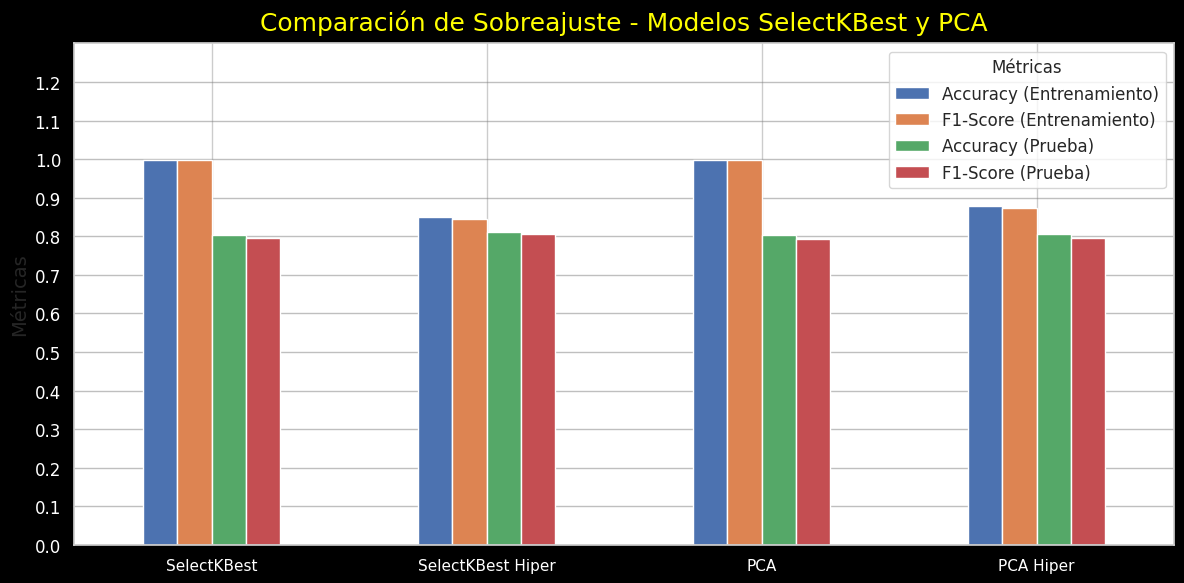

In [270]:
# Combinar ambos DataFrames
combined_df = pd.concat([overfitting_metrics_selectkbest_concat, overfitting_metrics_pca_concat], axis=0)

# Graficar
ax = combined_df.plot(kind='bar', figsize=(12, 6))

# Personalizar gráfico
plt.title('Comparación de Sobreajuste - Modelos SelectKBest y PCA', fontsize=18, pad=10, color='yellow')
plt.ylabel('Métricas', fontsize=14)
plt.xticks(rotation=0, color='white')  # Para que las etiquetas del eje x no se giren
plt.legend(title='Métricas', fontsize=12, loc='upper right')
plt.grid(axis='y', color='gray', alpha=0.5)  # Cambiar a 'y' para líneas horizontales
plt.ylim(0, 1.3)

# Definir ticks del eje y de 0 a 1.2 con incrementos de 0.1
plt.yticks([i * 0.1 for i in range(13)], fontsize=12, color='white')  # De 0 a 1.2

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('black')

# Mostrar gráfico
plt.tight_layout()
plt.show()

## CONCLUSIONES

1. <INS>**Alto Sobreajuste:**</INS> Ambos modelos, SelectKBest y PCA, presentan altos valores en las métricas de entrenamiento, mientras que en las métricas de prueba se observa una notable diferencia. Esto indica una posible tendencia al sobreajuste, donde los modelos están aprendiendo de manera más efectiva solo de los datos de entrenamiento, pero no se desempeñan bien con datos nuevos.

2. <INS>**Impacto de los Hiperparámetros:**</INS> Tras la aplicación de hiperparámetros, aunque las métricas absolutas no mostraron una mejora significativa, la diferencia entre los valores de las métricas de entrenamiento y prueba se redujo. Esto sugiere que se ha mejorado el sobreajuste, permitiendo que los modelos generalicen mejor a datos no vistos.

3. <INS>**Mejoras en el Rendimiento:**</INS> La optimización mediante hiperparámetros ha permitido una mejora en el rendimiento general de los modelos al reducir el riesgo de sobreajuste, lo que es un paso positivo hacia un modelo más robusto.

4. <INS>**Necesidad de Más Evaluación:**</INS> Para incrementar aún más los valores de las métricas, sería beneficioso recopilar más información o evaluar características adicionales. Esto podría ayudar a enriquecer el modelo y mejorar su capacidad de generalización.

## A CONTINUAR ............ PARA PROBAR CON OTROS MODELOS
# 8. PROBANDO MODELOS ENSEMBLE

In [233]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Separar las características y la variable objetivo
x_ensemble = datos_churn_norm_2.drop(columns='Churn')
y_ensemble = datos_churn_norm_2['Churn']

x_train_ensemble, x_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(x_ensemble, y_ensemble, test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train_ensemble = scaler.fit_transform(x_train_ensemble)
x_test_ensemble = scaler.transform(x_test_ensemble)

## 8.1 Bagging (Bootstrap Aggregating)

El Bagging consiste en entrenar varios modelos en diferentes subconjuntos del conjunto de datos original y luego promediar las predicciones (para regresión) o votar (para clasificación).

In [234]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Definir el modelo base
base_model = DecisionTreeClassifier(random_state=42)

# Crear el modelo de Bagging
bagging_model = BaggingClassifier(estimator=base_model,
                                  n_estimators=50,
                                   random_state=42)

# Ajustar el modelo
bagging_model.fit(x_train_ensemble, y_train_ensemble)

# Predecir
y_pred_bagging = bagging_model.predict(x_test_ensemble)

# Evaluar
accuracy_bagging = bagging_model.score(x_test_ensemble, y_test_ensemble)
f1_score_bagging = f1_score(y_test_ensemble, y_pred_bagging, average='weighted')
print(f"Accuracy (Bagging): {accuracy_bagging}")
print(f"F1-Score (Bagging): {f1_score_bagging}")

Accuracy (Bagging): 0.7919042189281642
F1-Score (Bagging): 0.7833564893104864


## 8.2 Boosting

El Boosting es un método que ajusta los modelos secuencialmente, donde cada modelo nuevo corrige los errores del modelo anterior.

In [236]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(random_state=42)

# Crear el modelo de AdaBoost
adaboost_model = AdaBoostClassifier(estimator=base_model,
                                    n_estimators=100,
                                    random_state=42)

adaboost_model.fit(x_train_ensemble, y_train_ensemble)

y_pred_adaboost = adaboost_model.predict(x_test_ensemble)

accuracy_adaboost = adaboost_model.score(x_test_ensemble, y_test_ensemble)
f1_score_adaboost = f1_score(y_test_ensemble, y_pred_adaboost, average='weighted')
print(f"Accuracy (AdaBoost): {accuracy_adaboost}")
print(f"F1-Score (AdaBoost): {f1_score_adaboost}")

Accuracy (AdaBoost): 0.7462941847206386
F1-Score (AdaBoost): 0.7485304849643182


## 8.3 XGBoost

XGBoost (Extreme Gradient Boosting) es una implementación optimizada de Gradient Boosting y es muy popular debido a su rendimiento y velocidad.

In [237]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(x_train_ensemble, y_train_ensemble)

y_pred_xgb = xgb_model.predict(x_test_ensemble)

accuracy_xgb = xgb_model.score(x_test_ensemble, y_test_ensemble)
f1_score_xgb = f1_score(y_test_ensemble, y_pred_xgb, average='weighted')

print(f"Accuracy (XGBoost): {accuracy_xgb}")
print(f"F1-Score (XGBoost): {f1_score_xgb}")

Accuracy (XGBoost): 0.7879133409350056
F1-Score (XGBoost): 0.7809281559463298


## 8.4 Gradient Boosting

El Gradient Boosting es un método que utiliza la técnica de Boosting y ajusta el modelo en función de la dirección del gradiente.

In [242]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(x_train_ensemble, y_train_ensemble)

y_pred_gb = gb_model.predict(x_test_ensemble)

accuracy_gb = gb_model.score(x_test_ensemble, y_test_ensemble)
f1_score_gb = f1_score(y_test_ensemble, y_pred_gb, average='weighted')

print(f"Accuracy (Gradient Boosting): {accuracy_gb}")
print(f"F1-Score (Gradient Boosting): {f1_score_gb}")


Accuracy (Gradient Boosting): 0.8078677309007982
F1-Score (Gradient Boosting): 0.800538586977841
